In [235]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor,\
    AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import optuna

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history, AdaBoost_creator 
from library.XGBoost import XGBoost_creator
from library.LightGBM import LightGBM_creator
from library.CatBoost import CatBoost_creator
from library.Random_Forest import RandomForest_creator
from library.Extra_Trees import ExtraTrees_creator
from library.StackingCV_Scheme3 import stratified_data, runall_LR, runall_RidgeR, stackingCV_creator, vif, \
    correlation_plot, rank_importance

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

ImportError: cannot import name 'vif' from 'library.StackingCV_Scheme3' (C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\StackingCV_Scheme3.py)

## 

### load hyperparameters from all the base learners

In [2]:
def load_hyper(num_set, date, model_list, iter_list, filename, mode, TPE_multi) :
    
    sampler = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
    allset_dict = {}
    for j in range(num_set) :
        
        model_dict = {}
        for i, model in enumerate(model_list) :

            with open(f'hyperparameter/{date}/{filename}_{model}{mode}_{sampler}_{iter_list[i]}.data', 'rb') as f:
                temp_dict = pickle.load(f)
                model_dict[model] = temp_dict[f'set{j}']
                
        allset_dict[f'set{j}'] = model_dict
        
    return allset_dict

### transform data by base learner

In [3]:
def transform_train(train_data, mode, base_param, cv):
    
    set_name = list(base_param.keys())
    num_set = len(set_name)
    model_list = list(base_param[set_name[0]].keys())
    set_dict = {}
    for i in tqdm(range(num_set)):
        
        print(f'Dataset {i}:\n')
        train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train_data[f'set{i}'], cv = cv)
        all_cv = pd.DataFrame()
        for j in tqdm(range(cv)):

            model_predict = pd.DataFrame()
            if mode == 'C':

                if 'XGBoost' in model_list:                     
                    clf = XGBClassifier(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:                        
                    clf = LGBMClassifier(**base_param[f'set{i}']['LightGBM'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    clf = CatBoostClassifier(**base_param[f'set{i}']['CatBoost'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeClassifier(
                            max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    clf = AdaBoostClassifier(**boost_param)
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    clf = RandomForestClassifier(**base_param[f'set{i}']['RandomForest'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    clf = ExtraTreesClassifier(**base_param[f'set{i}']['ExtraTrees'])
                    clf.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = clf.predict_proba(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y[:, 0]})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            elif mode == 'R':

                if 'XGBoost' in model_list:
                    reg = XGBRegressor(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'X': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'LightGBM' in model_list:
                    reg = LGBMRegressor(**base_param[f'set{i}']['LightGBM'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'L': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'CatBoost' in model_list:
                    reg = CatBoostRegressor(**base_param[f'set{i}']['CatBoost'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'C': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'AdaBoost' in model_list:
                    tree_param = {
                        'base_estimator': DecisionTreeRegressor(
                            max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                        )}
                    boost_param = dict(
                        (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                    )
                    boost_param.update(tree_param)
                    reg = AdaBoostRegressor(**boost_param)
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'A': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'RandomForest' in model_list:
                    reg = RandomForestRegressor(**base_param[f'set{i}']['RandomForest'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'R': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

                if 'ExtraTrees' in model_list:
                    reg = ExtraTreesRegressor(**base_param[f'set{i}']['ExtraTrees'])
                    reg.fit(train_x_dict[j], train_y_dict[j])
                    predict_y = reg.predict(valid_x_dict[j])
                    predict = pd.DataFrame({'E': predict_y})
                    model_predict = pd.concat([model_predict, predict], axis = 1)

            test_label = valid_y_dict[j].reset_index(drop = True)
            done_cv = pd.concat([model_predict, test_label], axis = 1)
            all_cv = pd.concat([all_cv, done_cv], axis = 0)

        set_dict[f'set{i}'] = all_cv
    
    return set_dict


def transform_test(train_data, test_data, mode, base_param):
    
    set_name = list(base_param.keys())
    num_set = len(set_name)
    model_list = list(base_param[set_name[0]].keys())
    test_dict = {}
    for i in tqdm(range(num_set)):
        
        print(f'Dataset {i}:\n')
        train_x, train_y, test_x, test_y = label_divide(train_data[f'set{i}'], test_data, train_only = False)
        model_predict = pd.DataFrame()
        if mode == 'C':

            if 'XGBoost' in model_list:
                clf = XGBClassifier(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'X': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                clf = LGBMClassifier(**base_param[f'set{i}']['LightGBM'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'L': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                clf = CatBoostClassifier(**base_param[f'set{i}']['CatBoost'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'C': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeClassifier(
                        max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                clf = AdaBoostClassifier(**boost_param)
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'A': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                clf = RandomForestClassifier(**base_param[f'set{i}']['RandomForest'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'R': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                clf = ExtraTreesClassifier(**base_param[f'set{i}']['ExtraTrees'])
                clf.fit(train_x, train_y)
                predict_y = clf.predict_proba(test_x)
                predict = pd.DataFrame({'E': predict_y[:, 0]})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        elif mode == 'R':

            if 'XGBoost' in model_list:
                reg = XGBRegressor(**base_param[f'set{i}']['XGBoost'], n_jobs = -1)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'X': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'LightGBM' in model_list:
                reg = LGBMRegressor(**base_param[f'set{i}']['LightGBM'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'L': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'CatBoost' in model_list:
                reg = CatBoostRegressor(**base_param[f'set{i}']['CatBoost'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'C': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'AdaBoost' in model_list:
                tree_param = {
                    'base_estimator': DecisionTreeRegressor(
                        max_depth = base_param[f'set{i}']['AdaBoost']['max_depth']
                    )}
                boost_param = dict(
                    (key, base_param[f'set{i}']['AdaBoost'][key]) for key in ['learning_rate', 'n_estimators']
                )
                boost_param.update(tree_param)
                reg = AdaBoostRegressor(**boost_param)
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'A': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'RandomForest' in model_list:
                reg = RandomForestRegressor(**base_param[f'set{i}']['RandomForest'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'R': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

            if 'ExtraTrees' in model_list:
                reg = ExtraTreesRegressor(**base_param[f'set{i}']['ExtraTrees'])
                reg.fit(train_x, train_y)
                predict_y = reg.predict(test_x)
                predict = pd.DataFrame({'E': predict_y})
                model_predict = pd.concat([model_predict, predict], axis = 1)

        model_done = pd.concat([model_predict, test_y], axis = 1)
        test_dict[f'set{i}'] = model_done
        
    return test_dict

## 

### loading training data & testing data & hyperparameters generating from previous files

In [4]:
### training data ### 
training_month = [2, 3, 4]

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (38022, 96)  balance ratio: 863.0
Dimension of dataset 1 : (1128, 96)  balance ratio: 1.0
Dimension of dataset 2 : (962, 96)  balance ratio: 1.0
Dimension of dataset 3 : (1226, 96)  balance ratio: 1.0
Dimension of dataset 4 : (1138, 96)  balance ratio: 1.0
Dimension of dataset 5 : (883, 96)  balance ratio: 1.0
Dimension of dataset 6 : (921, 96)  balance ratio: 1.0
Dimension of dataset 7 : (880, 96)  balance ratio: 1.0
Dimension of dataset 8 : (880, 96)  balance ratio: 1.0
Dimension of dataset 9 : (484, 96)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60607, 107)  balance ratio: 550.0
Dimension of dataset 1 : (1800, 107)  balance ratio: 1.0
Dimension of dataset 2 : (2948, 107)  balance ratio: 1.0
Dimension of dataset 3 : (2030, 107)  balance ratio: 1.0
Dimension of dataset 4 : (1814, 107)  balance ratio: 1.0
Dimension of dataset 5 : (2203, 107)  balance ratio: 1.0
Dimension of

## base learner

In [6]:
##### loading hyperparameters #####
hyper_info = {
    'num_set': 10,
    'date': '20211019',
    'model_list': ['LightGBM', 'XGBoost', 'CatBoost', 'AdaBoost', 'RandomForest', 'ExtraTrees'],
    'iter_list': [200, 200, 200, 25, 50, 50],
    'filename': 'runhist_array_m2m5_4selection',
    'TPE_multi': True
}

base_paramC = load_hyper(**hyper_info, mode = 'C')
base_paramR = load_hyper(**hyper_info, mode = 'R')

### data transform for scheme 1

In [7]:
train_firstC = transform_train(run_train, 
                               mode = 'C', 
                               base_param = base_paramC, 
                               cv = 5)
test_firstC = transform_test(run_train, 
                             run_test, 
                             mode = 'C', 
                             base_param = base_paramC)
train_firstC_x, train_firstC_y = train_set(train_firstC, num_set = 10)
test_firstC_x, test_firstC_y = train_set(test_firstC, num_set = 10) 


train_firstR = transform_train(run_train, 
                               mode = 'R', 
                               base_param = base_paramR, 
                               cv = 5)
test_firstR = transform_test(run_train, 
                             run_test, 
                             mode = 'R', 
                             base_param = base_paramR)
train_firstR_x, train_firstR_y = train_set(train_firstR, num_set = 10)
test_firstR_x, test_firstR_y = train_set(test_firstR, num_set = 10) 

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset 0:



  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.1604415	total: 257ms	remaining: 51.2s
1:	learn: 0.0512844	total: 337ms	remaining: 33.4s
2:	learn: 0.0249251	total: 347ms	remaining: 22.8s
3:	learn: 0.0173001	total: 383ms	remaining: 18.8s
4:	learn: 0.0143972	total: 414ms	remaining: 16.1s
5:	learn: 0.0130356	total: 464ms	remaining: 15s
6:	learn: 0.0124460	total: 474ms	remaining: 13.1s
7:	learn: 0.0121141	total: 547ms	remaining: 13.1s
8:	learn: 0.0120168	total: 616ms	remaining: 13.1s
9:	learn: 0.0118773	total: 693ms	remaining: 13.2s
10:	learn: 0.0115863	total: 755ms	remaining: 13s
11:	learn: 0.0113442	total: 801ms	remaining: 12.6s
12:	learn: 0.0112658	total: 810ms	remaining: 11.7s
13:	learn: 0.0112201	total: 859ms	remaini

155:	learn: 0.0004078	total: 9.42s	remaining: 2.66s
156:	learn: 0.0003971	total: 9.51s	remaining: 2.6s
157:	learn: 0.0003882	total: 9.61s	remaining: 2.55s
158:	learn: 0.0003800	total: 9.7s	remaining: 2.5s
159:	learn: 0.0003771	total: 9.73s	remaining: 2.43s
160:	learn: 0.0003724	total: 9.79s	remaining: 2.37s
161:	learn: 0.0003654	total: 9.89s	remaining: 2.32s
162:	learn: 0.0003576	total: 9.97s	remaining: 2.26s
163:	learn: 0.0003535	total: 10s	remaining: 2.2s
164:	learn: 0.0003488	total: 10.1s	remaining: 2.14s
165:	learn: 0.0003436	total: 10.2s	remaining: 2.08s
166:	learn: 0.0003350	total: 10.3s	remaining: 2.03s
167:	learn: 0.0003291	total: 10.3s	remaining: 1.96s
168:	learn: 0.0003227	total: 10.3s	remaining: 1.9s
169:	learn: 0.0003110	total: 10.4s	remaining: 1.83s
170:	learn: 0.0003003	total: 10.5s	remaining: 1.77s
171:	learn: 0.0002969	total: 10.5s	remaining: 1.72s
172:	learn: 0.0002896	total: 10.6s	remaining: 1.65s
173:	learn: 0.0002796	total: 10.6s	remaining: 1.59s
174:	learn: 0.00027

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.1596070	total: 34.3ms	remaining: 6.83s
1:	learn: 0.0494890	total: 83.2ms	remaining: 8.23s
2:	learn: 0.0239458	total: 129ms	remaining: 8.45s
3:	learn: 0.0158965	total: 176ms	remaining: 8.64s
4:	learn: 0.0134021	total: 189ms	remaining: 7.36s
5:	learn: 0.0124612	total: 240ms	remaining: 7.76s
6:	learn: 0.0116083	total: 274ms	remaining: 7.56s
7:	learn: 0.0111725	total: 307ms	remaining: 7.38s
8:	learn: 0.0108153	total: 336ms	remaining: 7.14s
9:	learn: 0.0106148	total: 345ms	remaining: 6.55s
10:	learn: 0.0103192	total: 384ms	remaining: 6.6s
11:	learn: 0.0100469	total: 416ms	remaining: 6.52s
12:	learn: 0.0099181	total: 444ms	remaining: 6.38s
13:	learn: 0.0096521	total: 483ms	re

156:	learn: 0.0003535	total: 5.77s	remaining: 1.58s
157:	learn: 0.0003450	total: 5.81s	remaining: 1.54s
158:	learn: 0.0003393	total: 5.86s	remaining: 1.51s
159:	learn: 0.0003341	total: 5.88s	remaining: 1.47s
160:	learn: 0.0003307	total: 5.93s	remaining: 1.44s
161:	learn: 0.0003236	total: 5.96s	remaining: 1.4s
162:	learn: 0.0003157	total: 6.01s	remaining: 1.36s
163:	learn: 0.0003123	total: 6.04s	remaining: 1.33s
164:	learn: 0.0003108	total: 6.07s	remaining: 1.29s
165:	learn: 0.0003072	total: 6.11s	remaining: 1.25s
166:	learn: 0.0003018	total: 6.14s	remaining: 1.21s
167:	learn: 0.0002902	total: 6.17s	remaining: 1.17s
168:	learn: 0.0002875	total: 6.21s	remaining: 1.14s
169:	learn: 0.0002836	total: 6.23s	remaining: 1.1s
170:	learn: 0.0002733	total: 6.28s	remaining: 1.06s
171:	learn: 0.0002687	total: 6.33s	remaining: 1.03s
172:	learn: 0.0002665	total: 6.34s	remaining: 990ms
173:	learn: 0.0002639	total: 6.37s	remaining: 952ms
174:	learn: 0.0002614	total: 6.39s	remaining: 913ms
175:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.1567935	total: 37.1ms	remaining: 7.38s
1:	learn: 0.0488517	total: 84.6ms	remaining: 8.37s
2:	learn: 0.0243415	total: 129ms	remaining: 8.46s
3:	learn: 0.0169458	total: 162ms	remaining: 7.94s
4:	learn: 0.0142900	total: 193ms	remaining: 7.52s
5:	learn: 0.0134653	total: 298ms	remaining: 9.63s
6:	learn: 0.0124078	total: 309ms	remaining: 8.51s
7:	learn: 0.0122978	total: 341ms	remaining: 8.19s
8:	learn: 0.0116965	total: 410ms	remaining: 8.7s
9:	learn: 0.0114378	total: 465ms	remaining: 8.84s
10:	learn: 0.0112239	total: 475ms	remaining: 8.16s
11:	learn: 0.0110197	total: 567ms	remaining: 8.89s
12:	learn: 0.0107871	total: 632ms	remaining: 9.09s
13:	learn: 0.0106452	total: 659ms	re

157:	learn: 0.0003546	total: 7.41s	remaining: 1.97s
158:	learn: 0.0003422	total: 7.46s	remaining: 1.92s
159:	learn: 0.0003324	total: 7.54s	remaining: 1.88s
160:	learn: 0.0003281	total: 7.59s	remaining: 1.84s
161:	learn: 0.0003177	total: 7.6s	remaining: 1.78s
162:	learn: 0.0003142	total: 7.69s	remaining: 1.75s
163:	learn: 0.0003086	total: 7.71s	remaining: 1.69s
164:	learn: 0.0003049	total: 7.72s	remaining: 1.64s
165:	learn: 0.0002962	total: 7.77s	remaining: 1.59s
166:	learn: 0.0002924	total: 7.82s	remaining: 1.54s
167:	learn: 0.0002887	total: 7.83s	remaining: 1.49s
168:	learn: 0.0002846	total: 7.92s	remaining: 1.45s
169:	learn: 0.0002791	total: 7.95s	remaining: 1.4s
170:	learn: 0.0002732	total: 7.96s	remaining: 1.35s
171:	learn: 0.0002684	total: 8.06s	remaining: 1.31s
172:	learn: 0.0002636	total: 8.08s	remaining: 1.26s
173:	learn: 0.0002591	total: 8.09s	remaining: 1.21s
174:	learn: 0.0002537	total: 8.13s	remaining: 1.16s
175:	learn: 0.0002491	total: 8.17s	remaining: 1.11s
176:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.1584341	total: 47.8ms	remaining: 9.51s
1:	learn: 0.0479540	total: 96.3ms	remaining: 9.53s
2:	learn: 0.0233231	total: 143ms	remaining: 9.39s
3:	learn: 0.0159209	total: 209ms	remaining: 10.2s
4:	learn: 0.0137385	total: 274ms	remaining: 10.7s
5:	learn: 0.0123268	total: 364ms	remaining: 11.8s
6:	learn: 0.0117039	total: 446ms	remaining: 12.3s
7:	learn: 0.0114203	total: 513ms	remaining: 12.3s
8:	learn: 0.0111368	total: 545ms	remaining: 11.6s
9:	learn: 0.0109156	total: 593ms	remaining: 11.3s
10:	learn: 0.0107912	total: 665ms	remaining: 11.4s
11:	learn: 0.0106215	total: 676ms	remaining: 10.6s
12:	learn: 0.0103345	total: 717ms	remaining: 10.3s
13:	learn: 0.0103147	total: 776ms	r

155:	learn: 0.0002736	total: 9.94s	remaining: 2.8s
156:	learn: 0.0002669	total: 9.98s	remaining: 2.73s
157:	learn: 0.0002650	total: 10.1s	remaining: 2.68s
158:	learn: 0.0002603	total: 10.1s	remaining: 2.61s
159:	learn: 0.0002586	total: 10.1s	remaining: 2.54s
160:	learn: 0.0002551	total: 10.2s	remaining: 2.47s
161:	learn: 0.0002521	total: 10.3s	remaining: 2.42s
162:	learn: 0.0002485	total: 10.3s	remaining: 2.35s
163:	learn: 0.0002443	total: 10.4s	remaining: 2.29s
164:	learn: 0.0002389	total: 10.5s	remaining: 2.22s
165:	learn: 0.0002357	total: 10.6s	remaining: 2.17s
166:	learn: 0.0002317	total: 10.6s	remaining: 2.1s
167:	learn: 0.0002282	total: 10.7s	remaining: 2.04s
168:	learn: 0.0002250	total: 10.8s	remaining: 1.97s
169:	learn: 0.0002212	total: 10.8s	remaining: 1.91s
170:	learn: 0.0002204	total: 10.9s	remaining: 1.85s
171:	learn: 0.0002180	total: 11s	remaining: 1.79s
172:	learn: 0.0002144	total: 11.1s	remaining: 1.74s
173:	learn: 0.0002132	total: 11.2s	remaining: 1.67s
174:	learn: 0.00

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.1593661	total: 38.2ms	remaining: 7.6s
1:	learn: 0.0492352	total: 86.5ms	remaining: 8.57s
2:	learn: 0.0236212	total: 117ms	remaining: 7.71s
3:	learn: 0.0159620	total: 210ms	remaining: 10.3s
4:	learn: 0.0135838	total: 297ms	remaining: 11.6s
5:	learn: 0.0127195	total: 305ms	remaining: 9.88s
6:	learn: 0.0123237	total: 375ms	remaining: 10.3s
7:	learn: 0.0117700	total: 437ms	remaining: 10.5s
8:	learn: 0.0116759	total: 498ms	remaining: 10.6s
9:	learn: 0.0115680	total: 550ms	remaining: 10.4s
10:	learn: 0.0112493	total: 577ms	remaining: 9.92s
11:	learn: 0.0110639	total: 615ms	remaining: 9.63s
12:	learn: 0.0108995	total: 630ms	remaining: 9.07s
13:	learn: 0.0108512	total: 690ms	re

156:	learn: 0.0004682	total: 7.94s	remaining: 2.17s
157:	learn: 0.0004558	total: 8.01s	remaining: 2.13s
158:	learn: 0.0004493	total: 8.04s	remaining: 2.07s
159:	learn: 0.0004402	total: 8.07s	remaining: 2.02s
160:	learn: 0.0004379	total: 8.11s	remaining: 1.96s
161:	learn: 0.0004289	total: 8.21s	remaining: 1.93s
162:	learn: 0.0004239	total: 8.28s	remaining: 1.88s
163:	learn: 0.0004178	total: 8.32s	remaining: 1.83s
164:	learn: 0.0004071	total: 8.34s	remaining: 1.77s
165:	learn: 0.0003942	total: 8.37s	remaining: 1.71s
166:	learn: 0.0003800	total: 8.44s	remaining: 1.67s
167:	learn: 0.0003755	total: 8.53s	remaining: 1.62s
168:	learn: 0.0003659	total: 8.54s	remaining: 1.57s
169:	learn: 0.0003596	total: 8.62s	remaining: 1.52s
170:	learn: 0.0003510	total: 8.63s	remaining: 1.46s
171:	learn: 0.0003447	total: 8.69s	remaining: 1.41s
172:	learn: 0.0003350	total: 8.78s	remaining: 1.37s
173:	learn: 0.0003266	total: 8.81s	remaining: 1.32s
174:	learn: 0.0003224	total: 8.82s	remaining: 1.26s
175:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:04:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5588386	total: 5.93ms	remaining: 1.77s
1:	learn: 0.4624672	total: 12.2ms	remaining: 1.81s
2:	learn: 0.3754731	total: 18.2ms	remaining: 1.8s
3:	learn: 0.2832961	total: 24.3ms	remaining: 1.8s
4:	learn: 0.2386569	total: 30.2ms	remaining: 1.78s
5:	learn: 0.2076116	total: 36.3ms	remaining: 1.78s
6:	learn: 0.1882035	total: 42.1ms	remaining: 1.76s
7:	learn: 0.1658475	total: 48.7ms	remaining: 1.78s
8:	learn: 0.1460907	total: 55.1ms	remaining: 1.78s
9:	learn: 0.1308416	total: 61ms	remaining: 1.77s
10:	learn: 0.1165572	total: 67.3ms	remaining: 1.77s
11:	learn: 0.1046474	total: 72.8ms	remaining: 1.75s
12:	learn: 0.0972314	total: 78.5ms	remaining: 1.73s
13:	learn: 0.0867773	total: 

158:	learn: 0.0004603	total: 759ms	remaining: 673ms
159:	learn: 0.0004603	total: 763ms	remaining: 668ms
160:	learn: 0.0004603	total: 768ms	remaining: 663ms
161:	learn: 0.0004603	total: 772ms	remaining: 657ms
162:	learn: 0.0004603	total: 776ms	remaining: 652ms
163:	learn: 0.0004603	total: 780ms	remaining: 647ms
164:	learn: 0.0004603	total: 784ms	remaining: 642ms
165:	learn: 0.0004603	total: 788ms	remaining: 636ms
166:	learn: 0.0004603	total: 793ms	remaining: 631ms
167:	learn: 0.0004603	total: 797ms	remaining: 626ms
168:	learn: 0.0004603	total: 801ms	remaining: 621ms
169:	learn: 0.0004603	total: 806ms	remaining: 616ms
170:	learn: 0.0004603	total: 810ms	remaining: 611ms
171:	learn: 0.0004603	total: 814ms	remaining: 606ms
172:	learn: 0.0004602	total: 818ms	remaining: 601ms
173:	learn: 0.0004602	total: 822ms	remaining: 595ms
174:	learn: 0.0004602	total: 826ms	remaining: 590ms
175:	learn: 0.0004602	total: 831ms	remaining: 585ms
176:	learn: 0.0004602	total: 834ms	remaining: 580ms
177:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5718959	total: 5.96ms	remaining: 1.78s
1:	learn: 0.4662943	total: 12.2ms	remaining: 1.82s
2:	learn: 0.3806392	total: 18.5ms	remaining: 1.83s
3:	learn: 0.3246448	total: 24.4ms	remaining: 1.8s
4:	learn: 0.2740860	total: 31ms	remaining: 1.83s
5:	learn: 0.2279591	total: 37.2ms	remaining: 1.82s
6:	learn: 0.1932330	total: 43.5ms	remaining: 1.82s
7:	learn: 0.1656225	total: 49.6ms	remaining: 1.81s
8:	learn: 0.1500438	total: 55.7ms	remaining: 1.8s
9:	learn: 0.1311219	total: 62.2ms	remaining: 1.8s
10:	learn: 0.1187565	total: 67.9ms	remaining: 1.78s
11:	learn: 0.1073941	total: 73.5ms	remaining: 1.76s
12:	learn: 0.0979186	total: 79.2ms	remaining: 1.75s
13:	learn: 0.0885335	total: 8

160:	learn: 0.0004355	total: 764ms	remaining: 659ms
161:	learn: 0.0004355	total: 768ms	remaining: 654ms
162:	learn: 0.0004355	total: 772ms	remaining: 649ms
163:	learn: 0.0004355	total: 776ms	remaining: 644ms
164:	learn: 0.0004355	total: 781ms	remaining: 639ms
165:	learn: 0.0004355	total: 785ms	remaining: 634ms
166:	learn: 0.0004355	total: 789ms	remaining: 629ms
167:	learn: 0.0004355	total: 793ms	remaining: 623ms
168:	learn: 0.0004355	total: 798ms	remaining: 618ms
169:	learn: 0.0004355	total: 801ms	remaining: 613ms
170:	learn: 0.0004355	total: 806ms	remaining: 608ms
171:	learn: 0.0004355	total: 810ms	remaining: 603ms
172:	learn: 0.0004275	total: 814ms	remaining: 598ms
173:	learn: 0.0004275	total: 819ms	remaining: 593ms
174:	learn: 0.0004275	total: 823ms	remaining: 588ms
175:	learn: 0.0004275	total: 827ms	remaining: 583ms
176:	learn: 0.0004275	total: 831ms	remaining: 578ms
177:	learn: 0.0004275	total: 835ms	remaining: 573ms
178:	learn: 0.0004275	total: 840ms	remaining: 567ms
179:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5743632	total: 5.95ms	remaining: 1.78s
1:	learn: 0.4860171	total: 11.9ms	remaining: 1.77s
2:	learn: 0.4135988	total: 18.4ms	remaining: 1.82s
3:	learn: 0.3580427	total: 24.9ms	remaining: 1.84s
4:	learn: 0.3040703	total: 31.3ms	remaining: 1.84s
5:	learn: 0.2566455	total: 37.5ms	remaining: 1.84s
6:	learn: 0.2244541	total: 44.3ms	remaining: 1.85s
7:	learn: 0.1939793	total: 50.7ms	remaining: 1.85s
8:	learn: 0.1721534	total: 56.5ms	remaining: 1.83s
9:	learn: 0.1492635	total: 62.8ms	remaining: 1.82s
10:	learn: 0.1339248	total: 69ms	remaining: 1.81s
11:	learn: 0.1173413	total: 75.4ms	remaining: 1.81s
12:	learn: 0.1036692	total: 81.5ms	remaining: 1.8s
13:	learn: 0.0938683	total:

201:	learn: 0.0004391	total: 943ms	remaining: 458ms
202:	learn: 0.0004391	total: 948ms	remaining: 453ms
203:	learn: 0.0004391	total: 951ms	remaining: 448ms
204:	learn: 0.0004391	total: 956ms	remaining: 443ms
205:	learn: 0.0004391	total: 960ms	remaining: 438ms
206:	learn: 0.0004391	total: 964ms	remaining: 433ms
207:	learn: 0.0004391	total: 967ms	remaining: 428ms
208:	learn: 0.0004391	total: 971ms	remaining: 423ms
209:	learn: 0.0004391	total: 974ms	remaining: 418ms
210:	learn: 0.0004390	total: 978ms	remaining: 413ms
211:	learn: 0.0004390	total: 982ms	remaining: 408ms
212:	learn: 0.0004390	total: 985ms	remaining: 403ms
213:	learn: 0.0004390	total: 989ms	remaining: 398ms
214:	learn: 0.0004390	total: 993ms	remaining: 393ms
215:	learn: 0.0004390	total: 997ms	remaining: 388ms
216:	learn: 0.0004390	total: 1s	remaining: 383ms
217:	learn: 0.0004390	total: 1s	remaining: 378ms
218:	learn: 0.0004390	total: 1.01s	remaining: 373ms
219:	learn: 0.0004390	total: 1.01s	remaining: 368ms
220:	learn: 0.0004

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5496229	total: 5.94ms	remaining: 1.77s
1:	learn: 0.4701608	total: 11.9ms	remaining: 1.77s
2:	learn: 0.3960339	total: 18.3ms	remaining: 1.81s
3:	learn: 0.3243191	total: 24.3ms	remaining: 1.8s
4:	learn: 0.2758482	total: 30.2ms	remaining: 1.78s
5:	learn: 0.2396707	total: 36.4ms	remaining: 1.78s
6:	learn: 0.2120077	total: 42.3ms	remaining: 1.77s
7:	learn: 0.1909119	total: 47.9ms	remaining: 1.75s
8:	learn: 0.1644558	total: 54.2ms	remaining: 1.75s
9:	learn: 0.1488103	total: 60.3ms	remaining: 1.75s
10:	learn: 0.1326264	total: 66.2ms	remaining: 1.74s
11:	learn: 0.1208233	total: 72.2ms	remaining: 1.73s
12:	learn: 0.1077217	total: 77.9ms	remaining: 1.72s
13:	learn: 0.0970623	tota

160:	learn: 0.0004718	total: 760ms	remaining: 656ms
161:	learn: 0.0004718	total: 764ms	remaining: 651ms
162:	learn: 0.0004717	total: 768ms	remaining: 646ms
163:	learn: 0.0004717	total: 773ms	remaining: 641ms
164:	learn: 0.0004660	total: 777ms	remaining: 636ms
165:	learn: 0.0004660	total: 781ms	remaining: 631ms
166:	learn: 0.0004660	total: 785ms	remaining: 625ms
167:	learn: 0.0004660	total: 789ms	remaining: 620ms
168:	learn: 0.0004660	total: 793ms	remaining: 615ms
169:	learn: 0.0004660	total: 797ms	remaining: 609ms
170:	learn: 0.0004660	total: 801ms	remaining: 604ms
171:	learn: 0.0004660	total: 805ms	remaining: 599ms
172:	learn: 0.0004660	total: 809ms	remaining: 594ms
173:	learn: 0.0004660	total: 813ms	remaining: 589ms
174:	learn: 0.0004660	total: 816ms	remaining: 583ms
175:	learn: 0.0004659	total: 820ms	remaining: 578ms
176:	learn: 0.0004659	total: 824ms	remaining: 573ms
177:	learn: 0.0004659	total: 828ms	remaining: 568ms
178:	learn: 0.0004659	total: 832ms	remaining: 562ms
179:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5623127	total: 6.26ms	remaining: 1.87s
1:	learn: 0.4822382	total: 12.7ms	remaining: 1.9s
2:	learn: 0.4112988	total: 18.8ms	remaining: 1.86s
3:	learn: 0.3481403	total: 24.9ms	remaining: 1.84s
4:	learn: 0.2960402	total: 31.3ms	remaining: 1.84s
5:	learn: 0.2457875	total: 37.6ms	remaining: 1.84s
6:	learn: 0.2176513	total: 44.9ms	remaining: 1.88s
7:	learn: 0.1924724	total: 51.1ms	remaining: 1.86s
8:	learn: 0.1670090	total: 57.1ms	remaining: 1.85s
9:	learn: 0.1471010	total: 63.3ms	remaining: 1.83s
10:	learn: 0.1310283	total: 70ms	remaining: 1.84s
11:	learn: 0.1198210	total: 75.6ms	remaining: 1.81s
12:	learn: 0.1043892	total: 81.7ms	remaining: 1.8s
13:	learn: 0.0956602	total: 

156:	learn: 0.0004331	total: 763ms	remaining: 695ms
157:	learn: 0.0004331	total: 766ms	remaining: 689ms
158:	learn: 0.0004331	total: 769ms	remaining: 682ms
159:	learn: 0.0004331	total: 773ms	remaining: 677ms
160:	learn: 0.0004331	total: 777ms	remaining: 671ms
161:	learn: 0.0004331	total: 781ms	remaining: 665ms
162:	learn: 0.0004331	total: 785ms	remaining: 659ms
163:	learn: 0.0004331	total: 788ms	remaining: 653ms
164:	learn: 0.0004331	total: 792ms	remaining: 648ms
165:	learn: 0.0004331	total: 795ms	remaining: 642ms
166:	learn: 0.0004331	total: 798ms	remaining: 636ms
167:	learn: 0.0004331	total: 803ms	remaining: 631ms
168:	learn: 0.0004331	total: 807ms	remaining: 625ms
169:	learn: 0.0004331	total: 811ms	remaining: 620ms
170:	learn: 0.0004331	total: 814ms	remaining: 614ms
171:	learn: 0.0004331	total: 819ms	remaining: 609ms
172:	learn: 0.0004331	total: 823ms	remaining: 604ms
173:	learn: 0.0004331	total: 826ms	remaining: 598ms
174:	learn: 0.0004331	total: 830ms	remaining: 593ms
175:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6353601	total: 21.6ms	remaining: 5.37s
1:	learn: 0.5896467	total: 36.6ms	remaining: 4.53s
2:	learn: 0.5421292	total: 52ms	remaining: 4.28s
3:	learn: 0.5036225	total: 67.6ms	remaining: 4.16s
4:	learn: 0.4883580	total: 82.7ms	remaining: 4.05s
5:	learn: 0.4499913	total: 98.1ms	remaining: 3.99s
6:	learn: 0.4165383	total: 114ms	remaining: 3.94s
7:	learn: 0.4017796	total: 129ms	remaining: 3.9s
8:	learn: 0.3773459	total: 134ms	remaining: 3.58s
9:	learn: 0.3602958	total: 139ms	remaining: 3.33s
10:	learn: 0.3474665	total: 143ms	remaining: 3.11s
11:	learn: 0.3349347	total: 148ms	remaining: 2.94s
12:	learn: 0.3201177	total: 160ms	remaining: 2.92s
13:	learn: 0.3074508	total: 165ms	

169:	learn: 0.0154353	total: 2.03s	remaining: 955ms
170:	learn: 0.0152812	total: 2.04s	remaining: 943ms
171:	learn: 0.0150011	total: 2.06s	remaining: 933ms
172:	learn: 0.0148810	total: 2.06s	remaining: 919ms
173:	learn: 0.0147337	total: 2.07s	remaining: 905ms
174:	learn: 0.0146412	total: 2.08s	remaining: 890ms
175:	learn: 0.0144694	total: 2.08s	remaining: 875ms
176:	learn: 0.0143507	total: 2.09s	remaining: 861ms
177:	learn: 0.0142827	total: 2.09s	remaining: 846ms
178:	learn: 0.0141076	total: 2.1s	remaining: 833ms
179:	learn: 0.0138959	total: 2.1s	remaining: 819ms
180:	learn: 0.0138393	total: 2.11s	remaining: 805ms
181:	learn: 0.0136011	total: 2.12s	remaining: 790ms
182:	learn: 0.0135178	total: 2.12s	remaining: 776ms
183:	learn: 0.0134263	total: 2.12s	remaining: 762ms
184:	learn: 0.0133671	total: 2.13s	remaining: 748ms
185:	learn: 0.0132271	total: 2.13s	remaining: 734ms
186:	learn: 0.0131282	total: 2.15s	remaining: 726ms
187:	learn: 0.0130609	total: 2.16s	remaining: 714ms
188:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6174057	total: 15.6ms	remaining: 3.88s
1:	learn: 0.5491804	total: 30.8ms	remaining: 3.82s
2:	learn: 0.5021872	total: 46.2ms	remaining: 3.81s
3:	learn: 0.4727492	total: 61.7ms	remaining: 3.79s
4:	learn: 0.4492230	total: 77.1ms	remaining: 3.78s
5:	learn: 0.4205684	total: 108ms	remaining: 4.39s
6:	learn: 0.3998861	total: 123ms	remaining: 4.29s
7:	learn: 0.3671543	total: 139ms	remaining: 4.2s
8:	learn: 0.3435658	total: 144ms	remaining: 3.85s
9:	learn: 0.3296074	total: 149ms	remaining: 3.57s
10:	learn: 0.3179086	total: 154ms	remaining: 3.34s
11:	learn: 0.3071069	total: 159ms	remaining: 3.15s
12:	learn: 0.2904983	total: 190ms	remaining: 3.46s
13:	learn: 0.2819601	total: 221ms

174:	learn: 0.0139585	total: 2.56s	remaining: 1.09s
175:	learn: 0.0137472	total: 2.56s	remaining: 1.08s
176:	learn: 0.0136117	total: 2.58s	remaining: 1.06s
177:	learn: 0.0135014	total: 2.61s	remaining: 1.05s
178:	learn: 0.0134106	total: 2.62s	remaining: 1.04s
179:	learn: 0.0132369	total: 2.64s	remaining: 1.03s
180:	learn: 0.0131147	total: 2.64s	remaining: 1.01s
181:	learn: 0.0130333	total: 2.65s	remaining: 990ms
182:	learn: 0.0128794	total: 2.65s	remaining: 972ms
183:	learn: 0.0127252	total: 2.66s	remaining: 954ms
184:	learn: 0.0126522	total: 2.67s	remaining: 937ms
185:	learn: 0.0124528	total: 2.68s	remaining: 923ms
186:	learn: 0.0123357	total: 2.69s	remaining: 905ms
187:	learn: 0.0122503	total: 2.69s	remaining: 888ms
188:	learn: 0.0121493	total: 2.7s	remaining: 871ms
189:	learn: 0.0119772	total: 2.7s	remaining: 853ms
190:	learn: 0.0118984	total: 2.72s	remaining: 842ms
191:	learn: 0.0117050	total: 2.73s	remaining: 826ms
192:	learn: 0.0116488	total: 2.75s	remaining: 811ms
193:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6269615	total: 7.53ms	remaining: 1.88s
1:	learn: 0.5741431	total: 22.8ms	remaining: 2.83s
2:	learn: 0.5385647	total: 38.3ms	remaining: 3.15s
3:	learn: 0.5021682	total: 53.7ms	remaining: 3.31s
4:	learn: 0.4519063	total: 69.3ms	remaining: 3.4s
5:	learn: 0.4285897	total: 84.7ms	remaining: 3.44s
6:	learn: 0.4086477	total: 89.9ms	remaining: 3.12s
7:	learn: 0.3949648	total: 99.8ms	remaining: 3.02s
8:	learn: 0.3741588	total: 131ms	remaining: 3.5s
9:	learn: 0.3539246	total: 136ms	remaining: 3.25s
10:	learn: 0.3392795	total: 147ms	remaining: 3.2s
11:	learn: 0.3297136	total: 152ms	remaining: 3.01s
12:	learn: 0.3146507	total: 157ms	remaining: 2.86s
13:	learn: 0.2963622	total: 162m

155:	learn: 0.0171420	total: 1.18s	remaining: 710ms
156:	learn: 0.0170106	total: 1.18s	remaining: 700ms
157:	learn: 0.0169135	total: 1.19s	remaining: 692ms
158:	learn: 0.0168090	total: 1.19s	remaining: 683ms
159:	learn: 0.0167345	total: 1.2s	remaining: 674ms
160:	learn: 0.0164575	total: 1.2s	remaining: 665ms
161:	learn: 0.0162917	total: 1.21s	remaining: 656ms
162:	learn: 0.0160504	total: 1.23s	remaining: 655ms
163:	learn: 0.0157083	total: 1.23s	remaining: 647ms
164:	learn: 0.0155731	total: 1.24s	remaining: 638ms
165:	learn: 0.0153993	total: 1.24s	remaining: 629ms
166:	learn: 0.0152937	total: 1.25s	remaining: 620ms
167:	learn: 0.0151566	total: 1.25s	remaining: 611ms
168:	learn: 0.0149978	total: 1.26s	remaining: 603ms
169:	learn: 0.0148583	total: 1.26s	remaining: 594ms
170:	learn: 0.0146478	total: 1.27s	remaining: 585ms
171:	learn: 0.0145270	total: 1.27s	remaining: 577ms
172:	learn: 0.0144138	total: 1.28s	remaining: 568ms
173:	learn: 0.0142080	total: 1.29s	remaining: 563ms
174:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:05:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6130763	total: 36.6ms	remaining: 9.12s
1:	learn: 0.5685978	total: 52ms	remaining: 6.45s
2:	learn: 0.5330805	total: 67.4ms	remaining: 5.54s
3:	learn: 0.5102162	total: 83ms	remaining: 5.1s
4:	learn: 0.4567014	total: 98.7ms	remaining: 4.83s
5:	learn: 0.4200439	total: 104ms	remaining: 4.23s
6:	learn: 0.3992159	total: 114ms	remaining: 3.94s
7:	learn: 0.3797136	total: 118ms	remaining: 3.58s
8:	learn: 0.3655937	total: 129ms	remaining: 3.45s
9:	learn: 0.3464232	total: 145ms	remaining: 3.47s
10:	learn: 0.3350322	total: 149ms	remaining: 3.25s
11:	learn: 0.3109548	total: 155ms	remaining: 3.07s
12:	learn: 0.3038268	total: 160ms	remaining: 2.91s
13:	learn: 0.2942214	total: 165ms	rem

169:	learn: 0.0160449	total: 1.64s	remaining: 774ms
170:	learn: 0.0159055	total: 1.66s	remaining: 766ms
171:	learn: 0.0158365	total: 1.67s	remaining: 756ms
172:	learn: 0.0156833	total: 1.67s	remaining: 744ms
173:	learn: 0.0154321	total: 1.68s	remaining: 733ms
174:	learn: 0.0153706	total: 1.69s	remaining: 726ms
175:	learn: 0.0151171	total: 1.7s	remaining: 716ms
176:	learn: 0.0149947	total: 1.71s	remaining: 705ms
177:	learn: 0.0148284	total: 1.72s	remaining: 694ms
178:	learn: 0.0146622	total: 1.72s	remaining: 683ms
179:	learn: 0.0145557	total: 1.73s	remaining: 671ms
180:	learn: 0.0144551	total: 1.73s	remaining: 660ms
181:	learn: 0.0143258	total: 1.74s	remaining: 649ms
182:	learn: 0.0142251	total: 1.74s	remaining: 637ms
183:	learn: 0.0141396	total: 1.75s	remaining: 626ms
184:	learn: 0.0140377	total: 1.77s	remaining: 624ms
185:	learn: 0.0138234	total: 1.8s	remaining: 619ms
186:	learn: 0.0136331	total: 1.81s	remaining: 609ms
187:	learn: 0.0135292	total: 1.83s	remaining: 603ms
188:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6287932	total: 23.8ms	remaining: 5.93s
1:	learn: 0.5682988	total: 39.2ms	remaining: 4.86s
2:	learn: 0.5300509	total: 54.5ms	remaining: 4.49s
3:	learn: 0.4877346	total: 70.1ms	remaining: 4.31s
4:	learn: 0.4605332	total: 84.8ms	remaining: 4.16s
5:	learn: 0.4389999	total: 101ms	remaining: 4.09s
6:	learn: 0.3974573	total: 132ms	remaining: 4.59s
7:	learn: 0.3827057	total: 137ms	remaining: 4.15s
8:	learn: 0.3658579	total: 142ms	remaining: 3.81s
9:	learn: 0.3501295	total: 147ms	remaining: 3.54s
10:	learn: 0.3382524	total: 152ms	remaining: 3.3s
11:	learn: 0.3197699	total: 157ms	remaining: 3.11s
12:	learn: 0.3071688	total: 162ms	remaining: 2.95s
13:	learn: 0.2976761	total: 167ms

165:	learn: 0.0161795	total: 1.38s	remaining: 701ms
166:	learn: 0.0160823	total: 1.39s	remaining: 690ms
167:	learn: 0.0159549	total: 1.39s	remaining: 680ms
168:	learn: 0.0157628	total: 1.4s	remaining: 670ms
169:	learn: 0.0156360	total: 1.4s	remaining: 660ms
170:	learn: 0.0154697	total: 1.41s	remaining: 651ms
171:	learn: 0.0152442	total: 1.42s	remaining: 644ms
172:	learn: 0.0151451	total: 1.42s	remaining: 634ms
173:	learn: 0.0149111	total: 1.43s	remaining: 624ms
174:	learn: 0.0147978	total: 1.43s	remaining: 615ms
175:	learn: 0.0146648	total: 1.44s	remaining: 605ms
176:	learn: 0.0145779	total: 1.45s	remaining: 598ms
177:	learn: 0.0144772	total: 1.47s	remaining: 593ms
178:	learn: 0.0142615	total: 1.47s	remaining: 583ms
179:	learn: 0.0141320	total: 1.48s	remaining: 574ms
180:	learn: 0.0140128	total: 1.48s	remaining: 564ms
181:	learn: 0.0137848	total: 1.48s	remaining: 555ms
182:	learn: 0.0135637	total: 1.49s	remaining: 545ms
183:	learn: 0.0134519	total: 1.5s	remaining: 537ms
184:	learn: 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

[00:06:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.4279324	total: 7.58ms	remaining: 1.89s
1:	learn: 0.3011976	total: 15.9ms	remaining: 1.97s
2:	learn: 0.2404904	total: 23.4ms	remaining: 1.92s
3:	learn: 0.1999601	total: 31.4ms	remaining: 1.93s
4:	learn: 0.1678681	total: 39.3ms	remaining: 1.93s
5:	learn: 0.1460587	total: 47.2ms	remaining: 1.92s
6:	learn: 0.1345735	total: 54.5ms	remaining: 1.89s
7:	learn: 0.1234144	total: 62.8ms	remaining: 1.9s
8:	learn: 0.1125126	total: 70.7ms	remaining: 1.89s
9:	learn: 0.1067235	total: 77.9ms	remaining: 1.87s
10:	learn: 0.1008362	total: 84.9ms	remaining: 1.84s
11:	learn: 0.0962023	total: 91.8ms	remaining: 1.82s
12:	learn: 0.0916599	total: 98.9ms	remaining: 1.8s
13:	learn: 0.0875939	total: 106ms	remaining: 1.78s
14:	learn: 0.0837441	total: 112ms	remaining: 1.76s
15:	learn: 0.0810931	total: 119ms	remaining: 1.74s
16:	learn: 0.0784931	total: 124ms	remaining: 1.7s
17:	learn: 0.0760892	total: 131ms	remaining: 1.69s
18:	learn: 0.0730307	total: 137ms	remaining: 1.67s
19:	learn: 0.0711558	total: 144

190:	learn: 0.0067051	total: 956ms	remaining: 295ms
191:	learn: 0.0066971	total: 960ms	remaining: 290ms
192:	learn: 0.0066796	total: 963ms	remaining: 284ms
193:	learn: 0.0066795	total: 967ms	remaining: 279ms
194:	learn: 0.0066795	total: 970ms	remaining: 274ms
195:	learn: 0.0066795	total: 974ms	remaining: 268ms
196:	learn: 0.0066731	total: 977ms	remaining: 263ms
197:	learn: 0.0066210	total: 982ms	remaining: 258ms
198:	learn: 0.0065505	total: 986ms	remaining: 253ms
199:	learn: 0.0064086	total: 993ms	remaining: 248ms
200:	learn: 0.0063237	total: 999ms	remaining: 243ms
201:	learn: 0.0063237	total: 1s	remaining: 238ms
202:	learn: 0.0063164	total: 1s	remaining: 233ms
203:	learn: 0.0063163	total: 1.01s	remaining: 228ms
204:	learn: 0.0063163	total: 1.01s	remaining: 222ms
205:	learn: 0.0063163	total: 1.01s	remaining: 217ms
206:	learn: 0.0063161	total: 1.02s	remaining: 212ms
207:	learn: 0.0063160	total: 1.02s	remaining: 206ms
208:	learn: 0.0063079	total: 1.02s	remaining: 201ms
209:	learn: 0.0063

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4386017	total: 7.47ms	remaining: 1.86s
1:	learn: 0.3111652	total: 15ms	remaining: 1.86s
2:	learn: 0.2464515	total: 22.2ms	remaining: 1.83s
3:	learn: 0.2106364	total: 30ms	remaining: 1.84s
4:	learn: 0.1806873	total: 38.2ms	remaining: 1.87s
5:	learn: 0.1571648	total: 45.3ms	remaining: 1.84s
6:	learn: 0.1392083	total: 52.7ms	remaining: 1.83s
7:	learn: 0.1296180	total: 60.6ms	remaining: 1.83s
8:	learn: 0.1214510	total: 67.9ms	remaining: 1.82s
9:	learn: 0.1142864	total: 75.7ms	remaining: 1.82s
10:	learn: 0.1076803	total: 83.3ms	remaining: 1.81s
11:	learn: 0.1027802	total: 90.4ms	remaining: 1.79s
12:	learn: 0.0967439	total: 98ms	remaining: 1.78s
13:	learn: 0.0920586	total: 10

184:	learn: 0.0063302	total: 956ms	remaining: 336ms
185:	learn: 0.0062972	total: 960ms	remaining: 330ms
186:	learn: 0.0062579	total: 965ms	remaining: 325ms
187:	learn: 0.0062579	total: 969ms	remaining: 319ms
188:	learn: 0.0062439	total: 972ms	remaining: 314ms
189:	learn: 0.0061969	total: 977ms	remaining: 309ms
190:	learn: 0.0061105	total: 983ms	remaining: 304ms
191:	learn: 0.0060302	total: 989ms	remaining: 299ms
192:	learn: 0.0059973	total: 993ms	remaining: 293ms
193:	learn: 0.0059973	total: 998ms	remaining: 288ms
194:	learn: 0.0059972	total: 1s	remaining: 283ms
195:	learn: 0.0059972	total: 1s	remaining: 277ms
196:	learn: 0.0059895	total: 1.01s	remaining: 271ms
197:	learn: 0.0059435	total: 1.01s	remaining: 266ms
198:	learn: 0.0058918	total: 1.02s	remaining: 261ms
199:	learn: 0.0058560	total: 1.02s	remaining: 256ms
200:	learn: 0.0057331	total: 1.03s	remaining: 251ms
201:	learn: 0.0056833	total: 1.03s	remaining: 246ms
202:	learn: 0.0056833	total: 1.04s	remaining: 240ms
203:	learn: 0.0056

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4418538	total: 7.49ms	remaining: 1.86s
1:	learn: 0.3182140	total: 15.3ms	remaining: 1.9s
2:	learn: 0.2504489	total: 23.3ms	remaining: 1.92s
3:	learn: 0.2123807	total: 30.8ms	remaining: 1.89s
4:	learn: 0.1842892	total: 38.4ms	remaining: 1.88s
5:	learn: 0.1696855	total: 45.9ms	remaining: 1.87s
6:	learn: 0.1522068	total: 53.7ms	remaining: 1.86s
7:	learn: 0.1374958	total: 61.9ms	remaining: 1.87s
8:	learn: 0.1271641	total: 69.9ms	remaining: 1.87s
9:	learn: 0.1210782	total: 77.4ms	remaining: 1.86s
10:	learn: 0.1136932	total: 85ms	remaining: 1.85s
11:	learn: 0.1079263	total: 92.1ms	remaining: 1.83s
12:	learn: 0.1016711	total: 99.6ms	remaining: 1.82s
13:	learn: 0.0972940	total:

174:	learn: 0.0066820	total: 959ms	remaining: 411ms
175:	learn: 0.0065919	total: 965ms	remaining: 406ms
176:	learn: 0.0065376	total: 970ms	remaining: 400ms
177:	learn: 0.0065003	total: 975ms	remaining: 394ms
178:	learn: 0.0064528	total: 980ms	remaining: 389ms
179:	learn: 0.0064528	total: 985ms	remaining: 383ms
180:	learn: 0.0064319	total: 988ms	remaining: 377ms
181:	learn: 0.0063325	total: 994ms	remaining: 372ms
182:	learn: 0.0063002	total: 999ms	remaining: 366ms
183:	learn: 0.0062462	total: 1s	remaining: 360ms
184:	learn: 0.0061798	total: 1.01s	remaining: 355ms
185:	learn: 0.0061266	total: 1.01s	remaining: 349ms
186:	learn: 0.0060808	total: 1.02s	remaining: 343ms
187:	learn: 0.0060485	total: 1.02s	remaining: 338ms
188:	learn: 0.0060201	total: 1.03s	remaining: 332ms
189:	learn: 0.0060200	total: 1.03s	remaining: 326ms
190:	learn: 0.0060144	total: 1.03s	remaining: 320ms
191:	learn: 0.0060141	total: 1.04s	remaining: 314ms
192:	learn: 0.0060141	total: 1.04s	remaining: 308ms
193:	learn: 0.0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4369067	total: 7.04ms	remaining: 1.75s
1:	learn: 0.3157766	total: 14.6ms	remaining: 1.81s
2:	learn: 0.2449704	total: 22.4ms	remaining: 1.84s
3:	learn: 0.2073701	total: 29.6ms	remaining: 1.82s
4:	learn: 0.1845405	total: 37.2ms	remaining: 1.82s
5:	learn: 0.1654826	total: 45.1ms	remaining: 1.83s
6:	learn: 0.1517539	total: 52.3ms	remaining: 1.81s
7:	learn: 0.1403796	total: 60.6ms	remaining: 1.83s
8:	learn: 0.1299172	total: 69.1ms	remaining: 1.85s
9:	learn: 0.1235348	total: 76.4ms	remaining: 1.83s
10:	learn: 0.1164965	total: 83.7ms	remaining: 1.82s
11:	learn: 0.1098363	total: 90.8ms	remaining: 1.8s
12:	learn: 0.1043691	total: 97.5ms	remaining: 1.78s
13:	learn: 0.0976402	tota

180:	learn: 0.0063656	total: 965ms	remaining: 368ms
181:	learn: 0.0063655	total: 969ms	remaining: 362ms
182:	learn: 0.0063655	total: 973ms	remaining: 356ms
183:	learn: 0.0063654	total: 977ms	remaining: 350ms
184:	learn: 0.0063650	total: 980ms	remaining: 344ms
185:	learn: 0.0063282	total: 985ms	remaining: 339ms
186:	learn: 0.0063282	total: 990ms	remaining: 333ms
187:	learn: 0.0062982	total: 994ms	remaining: 328ms
188:	learn: 0.0062157	total: 1s	remaining: 323ms
189:	learn: 0.0061801	total: 1s	remaining: 318ms
190:	learn: 0.0061800	total: 1.01s	remaining: 312ms
191:	learn: 0.0061645	total: 1.01s	remaining: 307ms
192:	learn: 0.0061015	total: 1.02s	remaining: 301ms
193:	learn: 0.0060836	total: 1.02s	remaining: 295ms
194:	learn: 0.0060400	total: 1.03s	remaining: 290ms
195:	learn: 0.0060400	total: 1.03s	remaining: 285ms
196:	learn: 0.0060400	total: 1.03s	remaining: 279ms
197:	learn: 0.0060399	total: 1.04s	remaining: 273ms
198:	learn: 0.0060398	total: 1.04s	remaining: 267ms
199:	learn: 0.0060

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:06:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4421672	total: 7.66ms	remaining: 1.91s
1:	learn: 0.3296433	total: 15.8ms	remaining: 1.96s
2:	learn: 0.2583866	total: 23.7ms	remaining: 1.95s
3:	learn: 0.2152903	total: 31ms	remaining: 1.91s
4:	learn: 0.1876743	total: 39ms	remaining: 1.91s
5:	learn: 0.1622389	total: 46.2ms	remaining: 1.88s
6:	learn: 0.1497208	total: 54.7ms	remaining: 1.9s
7:	learn: 0.1379063	total: 62.7ms	remaining: 1.9s
8:	learn: 0.1302089	total: 70.5ms	remaining: 1.89s
9:	learn: 0.1218715	total: 78.7ms	remaining: 1.89s
10:	learn: 0.1129688	total: 86.6ms	remaining: 1.88s
11:	learn: 0.1089285	total: 93.7ms	remaining: 1.86s
12:	learn: 0.1024818	total: 100ms	remaining: 1.83s
13:	learn: 0.0987885	total: 107

183:	learn: 0.0069395	total: 962ms	remaining: 345ms
184:	learn: 0.0069395	total: 966ms	remaining: 339ms
185:	learn: 0.0069395	total: 969ms	remaining: 333ms
186:	learn: 0.0069394	total: 971ms	remaining: 327ms
187:	learn: 0.0068672	total: 977ms	remaining: 322ms
188:	learn: 0.0068671	total: 981ms	remaining: 317ms
189:	learn: 0.0068667	total: 984ms	remaining: 311ms
190:	learn: 0.0068664	total: 987ms	remaining: 305ms
191:	learn: 0.0067998	total: 991ms	remaining: 299ms
192:	learn: 0.0067631	total: 996ms	remaining: 294ms
193:	learn: 0.0067057	total: 1s	remaining: 289ms
194:	learn: 0.0067057	total: 1s	remaining: 283ms
195:	learn: 0.0067056	total: 1.01s	remaining: 277ms
196:	learn: 0.0067056	total: 1.01s	remaining: 272ms
197:	learn: 0.0066980	total: 1.01s	remaining: 266ms
198:	learn: 0.0066980	total: 1.02s	remaining: 261ms
199:	learn: 0.0066979	total: 1.02s	remaining: 255ms
200:	learn: 0.0066978	total: 1.02s	remaining: 250ms
201:	learn: 0.0066978	total: 1.03s	remaining: 244ms
202:	learn: 0.0066

  0%|          | 0/5 [00:00<?, ?it/s]

[00:07:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.5574337	total: 2.9ms	remaining: 867ms
1:	learn: 0.4740567	total: 5.89ms	remaining: 878ms
2:	learn: 0.4143539	total: 8.68ms	remaining: 860ms
3:	learn: 0.3583452	total: 11.7ms	remaining: 862ms
4:	learn: 0.3222237	total: 14.4ms	remaining: 849ms
5:	learn: 0.2855456	total: 17.2ms	remaining: 844ms
6:	learn: 0.2562969	total: 20.4ms	remaining: 852ms
7:	learn: 0.2363162	total: 23.1ms	remaining: 844ms
8:	learn: 0.2199016	total: 26.1ms	remaining: 844ms
9:	learn: 0.1970528	total: 29ms	remaining: 840ms
10:	learn: 0.1779100	total: 31.9ms	remaining: 839ms
11:	learn: 0.1684627	total: 34.8ms	remaining: 835ms
12:	learn: 0.1601450	total: 37.7ms	remaining: 832ms
13:	learn: 0.1501341	total: 40.5ms	remaining: 828ms
14:	learn: 0.1398016	total: 43.8ms	remaining: 831ms
15:	learn: 0.1325427	total: 46.6ms	remaining: 827ms
16:	learn: 0.1258133	total: 49.3ms	remaining: 821ms
17:	learn: 0.1179485	total: 52.1ms	remaining: 816ms
18:	learn: 0.1114549	total: 54.9ms	remaining: 812ms
19:	learn: 0.1085025	tota

236:	learn: 0.0009120	total: 540ms	remaining: 143ms
237:	learn: 0.0009120	total: 542ms	remaining: 141ms
238:	learn: 0.0009120	total: 544ms	remaining: 139ms
239:	learn: 0.0009120	total: 546ms	remaining: 136ms
240:	learn: 0.0009120	total: 548ms	remaining: 134ms
241:	learn: 0.0009119	total: 550ms	remaining: 132ms
242:	learn: 0.0009119	total: 552ms	remaining: 129ms
243:	learn: 0.0009118	total: 554ms	remaining: 127ms
244:	learn: 0.0009118	total: 556ms	remaining: 125ms
245:	learn: 0.0009118	total: 558ms	remaining: 123ms
246:	learn: 0.0009118	total: 560ms	remaining: 120ms
247:	learn: 0.0009118	total: 562ms	remaining: 118ms
248:	learn: 0.0009118	total: 564ms	remaining: 116ms
249:	learn: 0.0009117	total: 567ms	remaining: 113ms
250:	learn: 0.0009117	total: 569ms	remaining: 111ms
251:	learn: 0.0009117	total: 571ms	remaining: 109ms
252:	learn: 0.0008859	total: 573ms	remaining: 106ms
253:	learn: 0.0008859	total: 575ms	remaining: 104ms
254:	learn: 0.0008859	total: 577ms	remaining: 102ms
255:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5612803	total: 3.05ms	remaining: 912ms
1:	learn: 0.4639329	total: 6.01ms	remaining: 895ms
2:	learn: 0.4180386	total: 8.82ms	remaining: 873ms
3:	learn: 0.3663512	total: 11.9ms	remaining: 880ms
4:	learn: 0.3187993	total: 14.8ms	remaining: 874ms
5:	learn: 0.2735362	total: 18.1ms	remaining: 889ms
6:	learn: 0.2514527	total: 21.2ms	remaining: 888ms
7:	learn: 0.2325701	total: 24.3ms	remaining: 886ms
8:	learn: 0.2146426	total: 27.2ms	remaining: 881ms
9:	learn: 0.1994868	total: 30.1ms	remaining: 874ms
10:	learn: 0.1863878	total: 33.1ms	remaining: 870ms
11:	learn: 0.1762371	total: 35.8ms	remaining: 859ms
12:	learn: 0.1654239	total: 38.7ms	remaining: 855ms
13:	learn: 0.1587889	tot

235:	learn: 0.0009228	total: 546ms	remaining: 148ms
236:	learn: 0.0009228	total: 548ms	remaining: 146ms
237:	learn: 0.0009228	total: 550ms	remaining: 143ms
238:	learn: 0.0009227	total: 552ms	remaining: 141ms
239:	learn: 0.0009227	total: 554ms	remaining: 139ms
240:	learn: 0.0009227	total: 556ms	remaining: 136ms
241:	learn: 0.0009227	total: 558ms	remaining: 134ms
242:	learn: 0.0009226	total: 560ms	remaining: 131ms
243:	learn: 0.0009225	total: 562ms	remaining: 129ms
244:	learn: 0.0009225	total: 564ms	remaining: 127ms
245:	learn: 0.0009225	total: 566ms	remaining: 124ms
246:	learn: 0.0009225	total: 567ms	remaining: 122ms
247:	learn: 0.0009225	total: 569ms	remaining: 119ms
248:	learn: 0.0009224	total: 571ms	remaining: 117ms
249:	learn: 0.0009224	total: 573ms	remaining: 115ms
250:	learn: 0.0009224	total: 575ms	remaining: 112ms
251:	learn: 0.0009224	total: 577ms	remaining: 110ms
252:	learn: 0.0009224	total: 579ms	remaining: 108ms
253:	learn: 0.0009224	total: 581ms	remaining: 105ms
254:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5732312	total: 2.88ms	remaining: 863ms
1:	learn: 0.4788247	total: 6.05ms	remaining: 902ms
2:	learn: 0.4179609	total: 8.93ms	remaining: 884ms
3:	learn: 0.3620251	total: 11.9ms	remaining: 880ms
4:	learn: 0.3198857	total: 15ms	remaining: 884ms
5:	learn: 0.2715225	total: 18ms	remaining: 882ms
6:	learn: 0.2458063	total: 21.2ms	remaining: 888ms
7:	learn: 0.2214268	total: 24.1ms	remaining: 879ms
8:	learn: 0.1992814	total: 26.9ms	remaining: 871ms
9:	learn: 0.1827885	total: 29.8ms	remaining: 864ms
10:	learn: 0.1706741	total: 32.8ms	remaining: 862ms
11:	learn: 0.1531295	total: 36.1ms	remaining: 865ms
12:	learn: 0.1451668	total: 38.8ms	remaining: 858ms
13:	learn: 0.1360880	total: 

227:	learn: 0.0009632	total: 531ms	remaining: 168ms
228:	learn: 0.0009632	total: 533ms	remaining: 165ms
229:	learn: 0.0009631	total: 535ms	remaining: 163ms
230:	learn: 0.0009631	total: 537ms	remaining: 160ms
231:	learn: 0.0009631	total: 539ms	remaining: 158ms
232:	learn: 0.0009630	total: 541ms	remaining: 156ms
233:	learn: 0.0009629	total: 543ms	remaining: 153ms
234:	learn: 0.0009392	total: 545ms	remaining: 151ms
235:	learn: 0.0009392	total: 547ms	remaining: 148ms
236:	learn: 0.0009391	total: 549ms	remaining: 146ms
237:	learn: 0.0009208	total: 552ms	remaining: 144ms
238:	learn: 0.0009208	total: 554ms	remaining: 141ms
239:	learn: 0.0009208	total: 555ms	remaining: 139ms
240:	learn: 0.0009207	total: 557ms	remaining: 136ms
241:	learn: 0.0008975	total: 560ms	remaining: 134ms
242:	learn: 0.0008975	total: 562ms	remaining: 132ms
243:	learn: 0.0008975	total: 564ms	remaining: 129ms
244:	learn: 0.0008975	total: 566ms	remaining: 127ms
245:	learn: 0.0008974	total: 568ms	remaining: 125ms
246:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5695149	total: 2.97ms	remaining: 889ms
1:	learn: 0.4832682	total: 5.93ms	remaining: 883ms
2:	learn: 0.4105858	total: 8.94ms	remaining: 885ms
3:	learn: 0.3498408	total: 11.9ms	remaining: 884ms
4:	learn: 0.3138572	total: 14.9ms	remaining: 879ms
5:	learn: 0.2818846	total: 17.7ms	remaining: 869ms
6:	learn: 0.2596011	total: 20.7ms	remaining: 865ms
7:	learn: 0.2395881	total: 23.8ms	remaining: 869ms
8:	learn: 0.2159224	total: 26.9ms	remaining: 871ms
9:	learn: 0.2034746	total: 29.7ms	remaining: 860ms
10:	learn: 0.1909029	total: 32.4ms	remaining: 853ms
11:	learn: 0.1767820	total: 35.4ms	remaining: 850ms
12:	learn: 0.1622255	total: 38.4ms	remaining: 847ms
13:	learn: 0.1555848	tot

154:	learn: 0.0017615	total: 372ms	remaining: 348ms
155:	learn: 0.0017615	total: 374ms	remaining: 346ms
156:	learn: 0.0016898	total: 377ms	remaining: 343ms
157:	learn: 0.0016898	total: 379ms	remaining: 340ms
158:	learn: 0.0016381	total: 381ms	remaining: 338ms
159:	learn: 0.0016381	total: 383ms	remaining: 335ms
160:	learn: 0.0016379	total: 385ms	remaining: 333ms
161:	learn: 0.0015960	total: 388ms	remaining: 330ms
162:	learn: 0.0015430	total: 390ms	remaining: 328ms
163:	learn: 0.0015156	total: 392ms	remaining: 325ms
164:	learn: 0.0015156	total: 394ms	remaining: 323ms
165:	learn: 0.0014808	total: 397ms	remaining: 320ms
166:	learn: 0.0014807	total: 399ms	remaining: 318ms
167:	learn: 0.0014078	total: 401ms	remaining: 315ms
168:	learn: 0.0014078	total: 403ms	remaining: 313ms
169:	learn: 0.0013707	total: 406ms	remaining: 310ms
170:	learn: 0.0013707	total: 408ms	remaining: 307ms
171:	learn: 0.0013707	total: 410ms	remaining: 305ms
172:	learn: 0.0013707	total: 412ms	remaining: 302ms
173:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5703067	total: 2.86ms	remaining: 856ms
1:	learn: 0.4631842	total: 5.79ms	remaining: 863ms
2:	learn: 0.4122056	total: 8.89ms	remaining: 880ms
3:	learn: 0.3663384	total: 11.9ms	remaining: 883ms
4:	learn: 0.3264603	total: 14.9ms	remaining: 881ms
5:	learn: 0.2699996	total: 17.7ms	remaining: 869ms
6:	learn: 0.2485339	total: 20.6ms	remaining: 861ms
7:	learn: 0.2281565	total: 23.5ms	remaining: 857ms
8:	learn: 0.2083642	total: 26.5ms	remaining: 856ms
9:	learn: 0.1967355	total: 29.2ms	remaining: 848ms
10:	learn: 0.1842748	total: 31.9ms	remaining: 839ms
11:	learn: 0.1708333	total: 35ms	remaining: 840ms
12:	learn: 0.1588226	total: 37.9ms	remaining: 837ms
13:	learn: 0.1506597	total

241:	learn: 0.0010127	total: 555ms	remaining: 133ms
242:	learn: 0.0010126	total: 557ms	remaining: 131ms
243:	learn: 0.0010126	total: 559ms	remaining: 128ms
244:	learn: 0.0010125	total: 561ms	remaining: 126ms
245:	learn: 0.0009837	total: 564ms	remaining: 124ms
246:	learn: 0.0009837	total: 566ms	remaining: 121ms
247:	learn: 0.0009837	total: 568ms	remaining: 119ms
248:	learn: 0.0009836	total: 570ms	remaining: 117ms
249:	learn: 0.0009836	total: 572ms	remaining: 114ms
250:	learn: 0.0009504	total: 575ms	remaining: 112ms
251:	learn: 0.0009504	total: 577ms	remaining: 110ms
252:	learn: 0.0009504	total: 579ms	remaining: 107ms
253:	learn: 0.0009504	total: 581ms	remaining: 105ms
254:	learn: 0.0009504	total: 582ms	remaining: 103ms
255:	learn: 0.0009504	total: 584ms	remaining: 100ms
256:	learn: 0.0009504	total: 586ms	remaining: 98.1ms
257:	learn: 0.0009504	total: 589ms	remaining: 95.8ms
258:	learn: 0.0009504	total: 590ms	remaining: 93.5ms
259:	learn: 0.0009503	total: 592ms	remaining: 91.1ms
260:	lea

  0%|          | 0/5 [00:00<?, ?it/s]

[00:07:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.6139609	total: 4.03ms	remaining: 803ms
1:	learn: 0.5662481	total: 7.71ms	remaining: 764ms
2:	learn: 0.5329555	total: 11.2ms	remaining: 739ms
3:	learn: 0.4944200	total: 14.9ms	remaining: 729ms
4:	learn: 0.4566073	total: 18.8ms	remaining: 734ms
5:	learn: 0.4180602	total: 22.8ms	remaining: 738ms
6:	learn: 0.3899113	total: 26.4ms	remaining: 728ms
7:	learn: 0.3620260	total: 30.5ms	remaining: 733ms
8:	learn: 0.3395679	total: 34.5ms	remaining: 733ms
9:	learn: 0.3238340	total: 38.2ms	remaining: 726ms
10:	learn: 0.3015841	total: 42.3ms	remaining: 727ms
11:	learn: 0.2815800	total: 46.5ms	remaining: 728ms
12:	learn: 0.2629590	total: 50.6ms	remaining: 728ms
13:	learn: 0.2461322	total: 54.9ms	remaining: 730ms
14:	learn: 0.2390728	total: 58.1ms	remaining: 717ms
15:	learn: 0.2305126	total: 61.7ms	remaining: 710ms
16:	learn: 0.2192875	total: 65.7ms	remaining: 707ms
17:	learn: 0.2101890	total: 69.4ms	remaining: 702ms
18:	learn: 0.2023820	total: 72.9ms	remaining: 695ms
19:	learn: 0.1915111	t

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6356976	total: 3.73ms	remaining: 742ms
1:	learn: 0.5807654	total: 8.11ms	remaining: 803ms
2:	learn: 0.5250678	total: 11.9ms	remaining: 780ms
3:	learn: 0.4776218	total: 15.9ms	remaining: 779ms
4:	learn: 0.4453859	total: 19.7ms	remaining: 770ms
5:	learn: 0.4183102	total: 23.6ms	remaining: 765ms
6:	learn: 0.3995752	total: 27.3ms	remaining: 754ms
7:	learn: 0.3694386	total: 31.5ms	remaining: 755ms
8:	learn: 0.3365679	total: 35.9ms	remaining: 762ms
9:	learn: 0.3146764	total: 39.6ms	remaining: 752ms
10:	learn: 0.2941425	total: 43.6ms	remaining: 750ms
11:	learn: 0.2706756	total: 47.7ms	remaining: 747ms
12:	learn: 0.2526789	total: 51.8ms	remaining: 746ms
13:	learn: 0.2370792	tot

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6310428	total: 3.64ms	remaining: 724ms
1:	learn: 0.5537362	total: 8.25ms	remaining: 817ms
2:	learn: 0.5103102	total: 12ms	remaining: 788ms
3:	learn: 0.4739906	total: 15.8ms	remaining: 773ms
4:	learn: 0.4481384	total: 19.3ms	remaining: 753ms
5:	learn: 0.4106846	total: 23.3ms	remaining: 754ms
6:	learn: 0.3876974	total: 27ms	remaining: 744ms
7:	learn: 0.3566824	total: 30.6ms	remaining: 734ms
8:	learn: 0.3363624	total: 34.3ms	remaining: 728ms
9:	learn: 0.3127086	total: 38.2ms	remaining: 725ms
10:	learn: 0.2826654	total: 42.5ms	remaining: 729ms
11:	learn: 0.2679381	total: 46.2ms	remaining: 723ms
12:	learn: 0.2515676	total: 50.3ms	remaining: 723ms
13:	learn: 0.2410842	total: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6292026	total: 4.09ms	remaining: 814ms
1:	learn: 0.5702489	total: 8.18ms	remaining: 810ms
2:	learn: 0.5051624	total: 12.3ms	remaining: 810ms
3:	learn: 0.4664861	total: 16.2ms	remaining: 792ms
4:	learn: 0.4300269	total: 20ms	remaining: 782ms
5:	learn: 0.3997451	total: 23.8ms	remaining: 770ms
6:	learn: 0.3696625	total: 28ms	remaining: 773ms
7:	learn: 0.3435912	total: 31.6ms	remaining: 758ms
8:	learn: 0.3195894	total: 35.5ms	remaining: 753ms
9:	learn: 0.3060100	total: 38.9ms	remaining: 740ms
10:	learn: 0.2891606	total: 42.5ms	remaining: 730ms
11:	learn: 0.2697091	total: 46.5ms	remaining: 729ms
12:	learn: 0.2569104	total: 50.4ms	remaining: 724ms
13:	learn: 0.2427971	total: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.6329749	total: 3.73ms	remaining: 741ms
1:	learn: 0.5805852	total: 7.81ms	remaining: 773ms
2:	learn: 0.5138446	total: 12ms	remaining: 787ms
3:	learn: 0.4646421	total: 16ms	remaining: 782ms
4:	learn: 0.4406410	total: 19.3ms	remaining: 753ms
5:	learn: 0.4133372	total: 22.9ms	remaining: 740ms
6:	learn: 0.3787310	total: 27ms	remaining: 746ms
7:	learn: 0.3553711	total: 31.1ms	remaining: 746ms
8:	learn: 0.3376015	total: 34.8ms	remaining: 739ms
9:	learn: 0.3145048	total: 38.6ms	remaining: 734ms
10:	learn: 0.2941804	total: 42.6ms	remaining: 732ms
11:	learn: 0.2709315	total: 46.7ms	remaining: 732ms
12:	learn: 0.2558936	total: 50.6ms	remaining: 729ms
13:	learn: 0.2360839	total: 55

Dataset 6:



  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5325314	total: 26.2ms	remaining: 7.83s
1:	learn: 0.4669882	total: 41.5ms	remaining: 6.18s
2:	learn: 0.3933839	total: 56.9ms	remaining: 5.63s
3:	learn: 0.3489468	total: 72.5ms	remaining: 5.36s
4:	learn: 0.3180706	total: 103ms	remaining: 6.09s
5:	learn: 0.2727754	total: 108ms	remaining: 5.28s
6:	learn: 0.2440144	total: 118ms	remaining: 4.96s
7:	learn: 0.2202608	total: 150ms	remaining: 5.48s
8:	learn: 0.2002339	total: 155ms	remaining: 5.03s
9:	learn: 0.1861568	total: 161ms	remaining: 4.66s
10:	learn: 0.1761859	total: 166ms	remaining: 4.35s
11:	learn: 0.1645346	total: 170ms	remaining: 4.09s
12:	learn: 0.1573155	total: 181ms	remaining: 4s
13:	learn: 0.1458166	total: 186ms	re

162:	learn: 0.0033447	total: 1.42s	remaining: 1.19s
163:	learn: 0.0033212	total: 1.44s	remaining: 1.2s
164:	learn: 0.0032742	total: 1.45s	remaining: 1.19s
165:	learn: 0.0032741	total: 1.46s	remaining: 1.18s
166:	learn: 0.0032740	total: 1.47s	remaining: 1.17s
167:	learn: 0.0032740	total: 1.47s	remaining: 1.16s
168:	learn: 0.0032496	total: 1.48s	remaining: 1.15s
169:	learn: 0.0032496	total: 1.48s	remaining: 1.13s
170:	learn: 0.0032496	total: 1.53s	remaining: 1.16s
171:	learn: 0.0032495	total: 1.56s	remaining: 1.16s
172:	learn: 0.0032494	total: 1.58s	remaining: 1.16s
173:	learn: 0.0032493	total: 1.6s	remaining: 1.16s
174:	learn: 0.0032493	total: 1.62s	remaining: 1.16s
175:	learn: 0.0032492	total: 1.63s	remaining: 1.15s
176:	learn: 0.0031442	total: 1.63s	remaining: 1.14s
177:	learn: 0.0031033	total: 1.64s	remaining: 1.13s
178:	learn: 0.0031033	total: 1.65s	remaining: 1.11s
179:	learn: 0.0031032	total: 1.65s	remaining: 1.1s
180:	learn: 0.0031031	total: 1.66s	remaining: 1.09s
181:	learn: 0.0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5507459	total: 11.6ms	remaining: 3.48s
1:	learn: 0.4249579	total: 26.9ms	remaining: 4.01s
2:	learn: 0.3707840	total: 42.4ms	remaining: 4.19s
3:	learn: 0.3282852	total: 57.9ms	remaining: 4.29s
4:	learn: 0.2981327	total: 73.4ms	remaining: 4.33s
5:	learn: 0.2727446	total: 88.4ms	remaining: 4.33s
6:	learn: 0.2495922	total: 104ms	remaining: 4.35s
7:	learn: 0.2333332	total: 119ms	remaining: 4.36s
8:	learn: 0.2156303	total: 135ms	remaining: 4.37s
9:	learn: 0.2034117	total: 140ms	remaining: 4.06s
10:	learn: 0.1953560	total: 145ms	remaining: 3.8s
11:	learn: 0.1885096	total: 151ms	remaining: 3.62s
12:	learn: 0.1772636	total: 156ms	remaining: 3.43s
13:	learn: 0.1626829	total: 167m

165:	learn: 0.0034870	total: 1.87s	remaining: 1.51s
166:	learn: 0.0034870	total: 1.88s	remaining: 1.5s
167:	learn: 0.0034869	total: 1.89s	remaining: 1.49s
168:	learn: 0.0034484	total: 1.9s	remaining: 1.47s
169:	learn: 0.0034117	total: 1.91s	remaining: 1.46s
170:	learn: 0.0034117	total: 1.91s	remaining: 1.44s
171:	learn: 0.0034116	total: 1.92s	remaining: 1.43s
172:	learn: 0.0034116	total: 1.95s	remaining: 1.43s
173:	learn: 0.0033733	total: 1.98s	remaining: 1.43s
174:	learn: 0.0033733	total: 2.03s	remaining: 1.45s
175:	learn: 0.0033732	total: 2.06s	remaining: 1.45s
176:	learn: 0.0033732	total: 2.07s	remaining: 1.44s
177:	learn: 0.0033522	total: 2.08s	remaining: 1.42s
178:	learn: 0.0033522	total: 2.08s	remaining: 1.41s
179:	learn: 0.0033218	total: 2.11s	remaining: 1.41s
180:	learn: 0.0032853	total: 2.14s	remaining: 1.41s
181:	learn: 0.0032283	total: 2.15s	remaining: 1.39s
182:	learn: 0.0031848	total: 2.16s	remaining: 1.38s
183:	learn: 0.0031427	total: 2.17s	remaining: 1.37s
184:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5388311	total: 14.2ms	remaining: 4.25s
1:	learn: 0.4313002	total: 29.4ms	remaining: 4.39s
2:	learn: 0.3863969	total: 45ms	remaining: 4.45s
3:	learn: 0.3455096	total: 60.5ms	remaining: 4.48s
4:	learn: 0.3121607	total: 76ms	remaining: 4.48s
5:	learn: 0.2695547	total: 91.1ms	remaining: 4.46s
6:	learn: 0.2438922	total: 106ms	remaining: 4.46s
7:	learn: 0.2243670	total: 122ms	remaining: 4.45s
8:	learn: 0.2105867	total: 138ms	remaining: 4.45s
9:	learn: 0.1999960	total: 154ms	remaining: 4.45s
10:	learn: 0.1865604	total: 170ms	remaining: 4.46s
11:	learn: 0.1787083	total: 175ms	remaining: 4.2s
12:	learn: 0.1663538	total: 180ms	remaining: 3.97s
13:	learn: 0.1561483	total: 219ms	re

162:	learn: 0.0033230	total: 1.79s	remaining: 1.5s
163:	learn: 0.0033229	total: 1.79s	remaining: 1.49s
164:	learn: 0.0033228	total: 1.8s	remaining: 1.47s
165:	learn: 0.0032703	total: 1.8s	remaining: 1.45s
166:	learn: 0.0032702	total: 1.81s	remaining: 1.44s
167:	learn: 0.0032701	total: 1.81s	remaining: 1.42s
168:	learn: 0.0032701	total: 1.81s	remaining: 1.41s
169:	learn: 0.0032487	total: 1.84s	remaining: 1.41s
170:	learn: 0.0032486	total: 1.84s	remaining: 1.39s
171:	learn: 0.0032485	total: 1.85s	remaining: 1.37s
172:	learn: 0.0032485	total: 1.85s	remaining: 1.36s
173:	learn: 0.0032485	total: 1.85s	remaining: 1.34s
174:	learn: 0.0032484	total: 1.86s	remaining: 1.33s
175:	learn: 0.0032484	total: 1.86s	remaining: 1.31s
176:	learn: 0.0031947	total: 1.9s	remaining: 1.32s
177:	learn: 0.0031947	total: 1.91s	remaining: 1.31s
178:	learn: 0.0031947	total: 1.91s	remaining: 1.29s
179:	learn: 0.0031947	total: 1.92s	remaining: 1.28s
180:	learn: 0.0031947	total: 1.93s	remaining: 1.27s
181:	learn: 0.00

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5500802	total: 27.9ms	remaining: 8.34s
1:	learn: 0.4717002	total: 43.1ms	remaining: 6.42s
2:	learn: 0.3989600	total: 58.5ms	remaining: 5.8s
3:	learn: 0.3583566	total: 74ms	remaining: 5.48s
4:	learn: 0.3274674	total: 89ms	remaining: 5.25s
5:	learn: 0.3048872	total: 105ms	remaining: 5.12s
6:	learn: 0.2810235	total: 120ms	remaining: 5.02s
7:	learn: 0.2602597	total: 136ms	remaining: 4.95s
8:	learn: 0.2261537	total: 140ms	remaining: 4.54s
9:	learn: 0.2109609	total: 145ms	remaining: 4.21s
10:	learn: 0.1869796	total: 150ms	remaining: 3.94s
11:	learn: 0.1760352	total: 155ms	remaining: 3.71s
12:	learn: 0.1648817	total: 159ms	remaining: 3.52s
13:	learn: 0.1550314	total: 164ms	rem

170:	learn: 0.0035345	total: 2.19s	remaining: 1.65s
171:	learn: 0.0035342	total: 2.2s	remaining: 1.64s
172:	learn: 0.0035342	total: 2.21s	remaining: 1.62s
173:	learn: 0.0035342	total: 2.21s	remaining: 1.6s
174:	learn: 0.0035341	total: 2.22s	remaining: 1.58s
175:	learn: 0.0035340	total: 2.22s	remaining: 1.57s
176:	learn: 0.0035339	total: 2.26s	remaining: 1.57s
177:	learn: 0.0035339	total: 2.29s	remaining: 1.57s
178:	learn: 0.0035339	total: 2.33s	remaining: 1.57s
179:	learn: 0.0035338	total: 2.35s	remaining: 1.57s
180:	learn: 0.0035337	total: 2.39s	remaining: 1.57s
181:	learn: 0.0035337	total: 2.42s	remaining: 1.57s
182:	learn: 0.0035337	total: 2.46s	remaining: 1.57s
183:	learn: 0.0035336	total: 2.49s	remaining: 1.57s
184:	learn: 0.0034815	total: 2.52s	remaining: 1.56s
185:	learn: 0.0034815	total: 2.54s	remaining: 1.56s
186:	learn: 0.0034815	total: 2.56s	remaining: 1.54s
187:	learn: 0.0034319	total: 2.56s	remaining: 1.53s
188:	learn: 0.0033574	total: 2.58s	remaining: 1.52s
189:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.5286161	total: 25ms	remaining: 7.46s
1:	learn: 0.4707698	total: 40.1ms	remaining: 5.97s
2:	learn: 0.4152844	total: 55.7ms	remaining: 5.51s
3:	learn: 0.3557794	total: 72ms	remaining: 5.33s
4:	learn: 0.3305404	total: 86.2ms	remaining: 5.08s
5:	learn: 0.2912381	total: 102ms	remaining: 4.98s
6:	learn: 0.2686595	total: 117ms	remaining: 4.91s
7:	learn: 0.2375902	total: 133ms	remaining: 4.85s
8:	learn: 0.2213203	total: 138ms	remaining: 4.45s
9:	learn: 0.2010725	total: 142ms	remaining: 4.13s
10:	learn: 0.1893475	total: 147ms	remaining: 3.87s
11:	learn: 0.1856313	total: 150ms	remaining: 3.6s
12:	learn: 0.1770981	total: 155ms	remaining: 3.42s
13:	learn: 0.1674345	total: 164ms	rem

160:	learn: 0.0034572	total: 1.42s	remaining: 1.23s
161:	learn: 0.0034571	total: 1.45s	remaining: 1.23s
162:	learn: 0.0034571	total: 1.47s	remaining: 1.23s
163:	learn: 0.0034570	total: 1.48s	remaining: 1.23s
164:	learn: 0.0034570	total: 1.49s	remaining: 1.22s
165:	learn: 0.0034570	total: 1.5s	remaining: 1.21s
166:	learn: 0.0034569	total: 1.53s	remaining: 1.22s
167:	learn: 0.0034048	total: 1.54s	remaining: 1.21s
168:	learn: 0.0033582	total: 1.56s	remaining: 1.21s
169:	learn: 0.0033582	total: 1.57s	remaining: 1.2s
170:	learn: 0.0033581	total: 1.59s	remaining: 1.2s
171:	learn: 0.0033580	total: 1.6s	remaining: 1.19s
172:	learn: 0.0033580	total: 1.61s	remaining: 1.18s
173:	learn: 0.0033580	total: 1.61s	remaining: 1.17s
174:	learn: 0.0033579	total: 1.62s	remaining: 1.16s
175:	learn: 0.0033579	total: 1.62s	remaining: 1.14s
176:	learn: 0.0033578	total: 1.63s	remaining: 1.13s
177:	learn: 0.0033208	total: 1.64s	remaining: 1.12s
178:	learn: 0.0033208	total: 1.64s	remaining: 1.11s
179:	learn: 0.00

  0%|          | 0/5 [00:00<?, ?it/s]

[00:08:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.3335856	total: 13.3ms	remaining: 3.99s
1:	learn: 0.2217877	total: 27.9ms	remaining: 4.16s
2:	learn: 0.1697583	total: 43.2ms	remaining: 4.28s
3:	learn: 0.1424772	total: 58.4ms	remaining: 4.32s
4:	learn: 0.1184306	total: 73.1ms	remaining: 4.31s
5:	learn: 0.0991858	total: 88.4ms	remaining: 4.33s
6:	learn: 0.0842278	total: 101ms	remaining: 4.23s
7:	learn: 0.0715454	total: 114ms	remaining: 4.16s
8:	learn: 0.0640607	total: 127ms	remaining: 4.09s
9:	learn: 0.0554276	total: 141ms	remaining: 4.1s
10:	learn: 0.0474862	total: 154ms	remaining: 4.05s
11:	learn: 0.0415130	total: 169ms	remaining: 4.04s
12:	learn: 0.0386605	total: 182ms	remaining: 4.02s
13:	learn: 0.0329530	total: 194ms	remaining: 3.97s
14:	learn: 0.0309829	total: 207ms	remaining: 3.93s
15:	learn: 0.0270042	total: 220ms	remaining: 3.9s
16:	learn: 0.0252973	total: 232ms	remaining: 3.87s
17:	learn: 0.0229087	total: 245ms	remaining: 3.83s
18:	learn: 0.0210708	total: 257ms	remaining: 3.81s
19:	learn: 0.0180169	total: 270ms	rem

165:	learn: 0.0005522	total: 2.16s	remaining: 1.75s
166:	learn: 0.0005522	total: 2.18s	remaining: 1.73s
167:	learn: 0.0005521	total: 2.19s	remaining: 1.72s
168:	learn: 0.0005521	total: 2.2s	remaining: 1.71s
169:	learn: 0.0005521	total: 2.21s	remaining: 1.69s
170:	learn: 0.0005521	total: 2.23s	remaining: 1.68s
171:	learn: 0.0005521	total: 2.24s	remaining: 1.67s
172:	learn: 0.0005521	total: 2.25s	remaining: 1.65s
173:	learn: 0.0005521	total: 2.26s	remaining: 1.64s
174:	learn: 0.0005521	total: 2.28s	remaining: 1.63s
175:	learn: 0.0005520	total: 2.29s	remaining: 1.61s
176:	learn: 0.0005520	total: 2.3s	remaining: 1.6s
177:	learn: 0.0005520	total: 2.31s	remaining: 1.59s
178:	learn: 0.0005520	total: 2.33s	remaining: 1.57s
179:	learn: 0.0005520	total: 2.34s	remaining: 1.56s
180:	learn: 0.0005519	total: 2.35s	remaining: 1.55s
181:	learn: 0.0005519	total: 2.36s	remaining: 1.53s
182:	learn: 0.0005519	total: 2.38s	remaining: 1.52s
183:	learn: 0.0005519	total: 2.39s	remaining: 1.51s
184:	learn: 0.0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:08:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.3260581	total: 13.4ms	remaining: 4s
1:	learn: 0.2137884	total: 27.1ms	remaining: 4.03s
2:	learn: 0.1716779	total: 40.6ms	remaining: 4.02s
3:	learn: 0.1369641	total: 56.2ms	remaining: 4.16s
4:	learn: 0.1112245	total: 71.8ms	remaining: 4.24s
5:	learn: 0.0947339	total: 86ms	remaining: 4.21s
6:	learn: 0.0840973	total: 99.4ms	remaining: 4.16s
7:	learn: 0.0723532	total: 112ms	remaining: 4.08s
8:	learn: 0.0622751	total: 126ms	remaining: 4.06s
9:	learn: 0.0537442	total: 139ms	remaining: 4.03s
10:	learn: 0.0477967	total: 152ms	remaining: 4s
11:	learn: 0.0419477	total: 166ms	remaining: 3.99s
12:	learn: 0.0364811	total: 179ms	remaining: 3.94s
13:	learn: 0.0331532	total: 191ms	rema

170:	learn: 0.0006946	total: 2.17s	remaining: 1.64s
171:	learn: 0.0006946	total: 2.19s	remaining: 1.63s
172:	learn: 0.0006946	total: 2.2s	remaining: 1.61s
173:	learn: 0.0006946	total: 2.21s	remaining: 1.6s
174:	learn: 0.0006946	total: 2.22s	remaining: 1.59s
175:	learn: 0.0006946	total: 2.24s	remaining: 1.58s
176:	learn: 0.0006945	total: 2.25s	remaining: 1.56s
177:	learn: 0.0006945	total: 2.26s	remaining: 1.55s
178:	learn: 0.0006945	total: 2.27s	remaining: 1.54s
179:	learn: 0.0006945	total: 2.29s	remaining: 1.52s
180:	learn: 0.0006945	total: 2.3s	remaining: 1.51s
181:	learn: 0.0006945	total: 2.31s	remaining: 1.5s
182:	learn: 0.0006945	total: 2.32s	remaining: 1.49s
183:	learn: 0.0006945	total: 2.34s	remaining: 1.47s
184:	learn: 0.0006945	total: 2.35s	remaining: 1.46s
185:	learn: 0.0006945	total: 2.36s	remaining: 1.45s
186:	learn: 0.0006945	total: 2.37s	remaining: 1.43s
187:	learn: 0.0006945	total: 2.39s	remaining: 1.42s
188:	learn: 0.0006945	total: 2.4s	remaining: 1.41s
189:	learn: 0.000

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.3105630	total: 13.7ms	remaining: 4.1s
1:	learn: 0.2131686	total: 28.5ms	remaining: 4.24s
2:	learn: 0.1628038	total: 43.2ms	remaining: 4.28s
3:	learn: 0.1306957	total: 58.5ms	remaining: 4.33s
4:	learn: 0.1129182	total: 71.5ms	remaining: 4.22s
5:	learn: 0.0931046	total: 85.9ms	remaining: 4.21s
6:	learn: 0.0808333	total: 99.4ms	remaining: 4.16s
7:	learn: 0.0726774	total: 111ms	remaining: 4.07s
8:	learn: 0.0629638	total: 126ms	remaining: 4.09s
9:	learn: 0.0561307	total: 139ms	remaining: 4.03s
10:	learn: 0.0521431	total: 152ms	remaining: 3.99s
11:	learn: 0.0436927	total: 164ms	remaining: 3.94s
12:	learn: 0.0392721	total: 178ms	remaining: 3.92s
13:	learn: 0.0341659	total: 190

165:	learn: 0.0005722	total: 2.15s	remaining: 1.74s
166:	learn: 0.0005722	total: 2.17s	remaining: 1.73s
167:	learn: 0.0005722	total: 2.18s	remaining: 1.71s
168:	learn: 0.0005722	total: 2.19s	remaining: 1.7s
169:	learn: 0.0005722	total: 2.2s	remaining: 1.69s
170:	learn: 0.0005722	total: 2.22s	remaining: 1.67s
171:	learn: 0.0005722	total: 2.23s	remaining: 1.66s
172:	learn: 0.0005722	total: 2.24s	remaining: 1.65s
173:	learn: 0.0005722	total: 2.25s	remaining: 1.63s
174:	learn: 0.0005722	total: 2.27s	remaining: 1.62s
175:	learn: 0.0005721	total: 2.28s	remaining: 1.6s
176:	learn: 0.0005721	total: 2.29s	remaining: 1.59s
177:	learn: 0.0005721	total: 2.3s	remaining: 1.58s
178:	learn: 0.0005721	total: 2.31s	remaining: 1.56s
179:	learn: 0.0005721	total: 2.33s	remaining: 1.55s
180:	learn: 0.0005721	total: 2.34s	remaining: 1.54s
181:	learn: 0.0005721	total: 2.35s	remaining: 1.52s
182:	learn: 0.0005721	total: 2.37s	remaining: 1.51s
183:	learn: 0.0005721	total: 2.38s	remaining: 1.5s
184:	learn: 0.000

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.3092786	total: 13.2ms	remaining: 3.96s
1:	learn: 0.2053795	total: 26.6ms	remaining: 3.96s
2:	learn: 0.1517175	total: 41.2ms	remaining: 4.07s
3:	learn: 0.1246834	total: 54.9ms	remaining: 4.06s
4:	learn: 0.1060873	total: 67.2ms	remaining: 3.96s
5:	learn: 0.0955832	total: 81.6ms	remaining: 4s
6:	learn: 0.0824737	total: 94.5ms	remaining: 3.96s
7:	learn: 0.0702411	total: 108ms	remaining: 3.94s
8:	learn: 0.0611672	total: 121ms	remaining: 3.92s
9:	learn: 0.0534738	total: 135ms	remaining: 3.93s
10:	learn: 0.0493291	total: 148ms	remaining: 3.89s
11:	learn: 0.0411750	total: 162ms	remaining: 3.88s
12:	learn: 0.0375439	total: 175ms	remaining: 3.87s
13:	learn: 0.0327704	total: 189ms

155:	learn: 0.0006018	total: 2s	remaining: 1.84s
156:	learn: 0.0006018	total: 2.01s	remaining: 1.83s
157:	learn: 0.0006018	total: 2.02s	remaining: 1.81s
158:	learn: 0.0006017	total: 2.03s	remaining: 1.8s
159:	learn: 0.0006017	total: 2.04s	remaining: 1.79s
160:	learn: 0.0006017	total: 2.06s	remaining: 1.78s
161:	learn: 0.0006017	total: 2.07s	remaining: 1.76s
162:	learn: 0.0006017	total: 2.08s	remaining: 1.75s
163:	learn: 0.0006017	total: 2.09s	remaining: 1.74s
164:	learn: 0.0006016	total: 2.11s	remaining: 1.72s
165:	learn: 0.0006016	total: 2.12s	remaining: 1.71s
166:	learn: 0.0006016	total: 2.13s	remaining: 1.7s
167:	learn: 0.0006016	total: 2.14s	remaining: 1.68s
168:	learn: 0.0006016	total: 2.15s	remaining: 1.67s
169:	learn: 0.0006016	total: 2.17s	remaining: 1.66s
170:	learn: 0.0006016	total: 2.18s	remaining: 1.64s
171:	learn: 0.0006016	total: 2.19s	remaining: 1.63s
172:	learn: 0.0006016	total: 2.21s	remaining: 1.62s
173:	learn: 0.0006016	total: 2.22s	remaining: 1.61s
174:	learn: 0.000

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.3208152	total: 13.9ms	remaining: 4.17s
1:	learn: 0.2229975	total: 27.8ms	remaining: 4.13s
2:	learn: 0.1700313	total: 43.7ms	remaining: 4.33s
3:	learn: 0.1380722	total: 60.4ms	remaining: 4.47s
4:	learn: 0.1147418	total: 76.3ms	remaining: 4.5s
5:	learn: 0.0991413	total: 90.4ms	remaining: 4.43s
6:	learn: 0.0858687	total: 104ms	remaining: 4.35s
7:	learn: 0.0720507	total: 118ms	remaining: 4.31s
8:	learn: 0.0651110	total: 132ms	remaining: 4.27s
9:	learn: 0.0548312	total: 146ms	remaining: 4.24s
10:	learn: 0.0468180	total: 160ms	remaining: 4.19s
11:	learn: 0.0425744	total: 173ms	remaining: 4.15s
12:	learn: 0.0371251	total: 187ms	remaining: 4.13s
13:	learn: 0.0322003	total: 201m

168:	learn: 0.0006153	total: 2.18s	remaining: 1.69s
169:	learn: 0.0006153	total: 2.2s	remaining: 1.68s
170:	learn: 0.0006153	total: 2.21s	remaining: 1.67s
171:	learn: 0.0006152	total: 2.22s	remaining: 1.65s
172:	learn: 0.0006152	total: 2.23s	remaining: 1.64s
173:	learn: 0.0006152	total: 2.25s	remaining: 1.63s
174:	learn: 0.0006152	total: 2.26s	remaining: 1.61s
175:	learn: 0.0006152	total: 2.27s	remaining: 1.6s
176:	learn: 0.0006152	total: 2.28s	remaining: 1.59s
177:	learn: 0.0006152	total: 2.29s	remaining: 1.57s
178:	learn: 0.0006152	total: 2.31s	remaining: 1.56s
179:	learn: 0.0006151	total: 2.32s	remaining: 1.55s
180:	learn: 0.0006151	total: 2.33s	remaining: 1.53s
181:	learn: 0.0006151	total: 2.34s	remaining: 1.52s
182:	learn: 0.0006151	total: 2.36s	remaining: 1.51s
183:	learn: 0.0006151	total: 2.37s	remaining: 1.49s
184:	learn: 0.0006150	total: 2.38s	remaining: 1.48s
185:	learn: 0.0006150	total: 2.39s	remaining: 1.47s
186:	learn: 0.0006149	total: 2.41s	remaining: 1.45s
187:	learn: 0.

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.3969659	total: 5.12ms	remaining: 1.02s
1:	learn: 0.2895281	total: 9.61ms	remaining: 951ms
2:	learn: 0.2136207	total: 14.4ms	remaining: 949ms
3:	learn: 0.1703534	total: 19ms	remaining: 931ms
4:	learn: 0.1471831	total: 23.3ms	remaining: 908ms
5:	learn: 0.1258297	total: 27.8ms	remaining: 898ms
6:	learn: 0.1063221	total: 31.9ms	remaining: 879ms
7:	learn: 0.0912211	total: 36.6ms	remaining: 878ms
8:	learn: 0.0799034	total: 41.5ms	remaining: 880ms
9:	learn: 0.0752728	total: 44.6ms	remaining: 848ms
10:	learn: 0.0657123	total: 49.3ms	remaining: 847ms
11:	learn: 0.0606454	total: 53.3ms	remaining: 834ms
12:	learn: 0.0553923	total: 57ms	remaining: 820ms
13:	learn: 0.0526395	total: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.3713224	total: 5.96ms	remaining: 1.19s
1:	learn: 0.2941186	total: 10.1ms	remaining: 998ms
2:	learn: 0.2456083	total: 14.5ms	remaining: 950ms
3:	learn: 0.1855494	total: 19.2ms	remaining: 943ms
4:	learn: 0.1509350	total: 23.9ms	remaining: 934ms
5:	learn: 0.1328833	total: 28ms	remaining: 905ms
6:	learn: 0.1187525	total: 32.1ms	remaining: 886ms
7:	learn: 0.0967986	total: 37.4ms	remaining: 897ms
8:	learn: 0.0809690	total: 42.1ms	remaining: 894ms
9:	learn: 0.0722585	total: 45.7ms	remaining: 868ms
10:	learn: 0.0661580	total: 49.9ms	remaining: 857ms
11:	learn: 0.0617735	total: 53.7ms	remaining: 842ms
12:	learn: 0.0585912	total: 57.4ms	remaining: 826ms
13:	learn: 0.0544085	total

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4126943	total: 5.79ms	remaining: 1.15s
1:	learn: 0.3529054	total: 9.41ms	remaining: 931ms
2:	learn: 0.2716425	total: 14.2ms	remaining: 933ms
3:	learn: 0.2021226	total: 18.9ms	remaining: 929ms
4:	learn: 0.1763992	total: 23.4ms	remaining: 911ms
5:	learn: 0.1405801	total: 28ms	remaining: 907ms
6:	learn: 0.1195066	total: 32.7ms	remaining: 903ms
7:	learn: 0.1006418	total: 37.9ms	remaining: 910ms
8:	learn: 0.0869654	total: 42.1ms	remaining: 894ms
9:	learn: 0.0794438	total: 46.5ms	remaining: 883ms
10:	learn: 0.0731087	total: 50.3ms	remaining: 864ms
11:	learn: 0.0664373	total: 54ms	remaining: 846ms
12:	learn: 0.0623421	total: 57.9ms	remaining: 833ms
13:	learn: 0.0607210	total: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4094654	total: 4.94ms	remaining: 983ms
1:	learn: 0.2798615	total: 10.1ms	remaining: 996ms
2:	learn: 0.2271590	total: 14.6ms	remaining: 956ms
3:	learn: 0.1603311	total: 19.3ms	remaining: 945ms
4:	learn: 0.1344120	total: 23.4ms	remaining: 914ms
5:	learn: 0.1219079	total: 27.3ms	remaining: 882ms
6:	learn: 0.1027718	total: 31.8ms	remaining: 876ms
7:	learn: 0.0891771	total: 36.5ms	remaining: 877ms
8:	learn: 0.0796749	total: 40.7ms	remaining: 863ms
9:	learn: 0.0693316	total: 45.1ms	remaining: 856ms
10:	learn: 0.0655026	total: 48.4ms	remaining: 832ms
11:	learn: 0.0587971	total: 53.1ms	remaining: 833ms
12:	learn: 0.0560090	total: 56.6ms	remaining: 814ms
13:	learn: 0.0503532	tot

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4217093	total: 5.63ms	remaining: 1.12s
1:	learn: 0.2960639	total: 10.7ms	remaining: 1.05s
2:	learn: 0.1955473	total: 16ms	remaining: 1.05s
3:	learn: 0.1588242	total: 20.6ms	remaining: 1.01s
4:	learn: 0.1293277	total: 25.2ms	remaining: 982ms
5:	learn: 0.1153526	total: 29.2ms	remaining: 944ms
6:	learn: 0.0919523	total: 34.4ms	remaining: 947ms
7:	learn: 0.0837393	total: 38.6ms	remaining: 926ms
8:	learn: 0.0755279	total: 42.8ms	remaining: 909ms
9:	learn: 0.0691546	total: 46.9ms	remaining: 892ms
10:	learn: 0.0651543	total: 50.5ms	remaining: 868ms
11:	learn: 0.0618497	total: 54.1ms	remaining: 848ms
12:	learn: 0.0542292	total: 58.6ms	remaining: 842ms
13:	learn: 0.0511594	total

Dataset 9:



  0%|          | 0/5 [00:00<?, ?it/s]

[00:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.4637717	total: 2.15ms	remaining: 320ms
1:	learn: 0.3557648	total: 3.93ms	remaining: 291ms
2:	learn: 0.2887742	total: 6.06ms	remaining: 297ms
3:	learn: 0.2385368	total: 8.37ms	remaining: 306ms
4:	learn: 0.2053930	total: 10.7ms	remaining: 310ms
5:	learn: 0.1827168	total: 12.8ms	remaining: 308ms
6:	learn: 0.1675524	total: 14.9ms	remaining: 305ms
7:	learn: 0.1585300	total: 17ms	remaining: 301ms
8:	learn: 0.1473140	total: 19ms	remaining: 298ms
9:	learn: 0.1378692	total: 21ms	remaining: 295ms
10:	learn: 0.1295758	total: 23.1ms	remaining: 292ms
11:	learn: 0.1190008	total: 25.4ms	remaining: 292ms
12:	learn: 0.1158515	total: 27.2ms	remaining: 287ms
13:	learn: 0.1130160	total: 28.9ms	remaining: 281ms
14:	learn: 0.1101909	total: 30.6ms	remaining: 276ms
15:	learn: 0.1041471	total: 32.7ms	remaining: 274ms
16:	learn: 0.1014986	total: 34.5ms	remaining: 270ms
17:	learn: 0.0953480	total: 36.5ms	remaining: 268ms
18:	learn: 0.0930535	total: 38.3ms	remaining: 264ms
19:	learn: 0.0895506	total: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4553920	total: 2.07ms	remaining: 309ms
1:	learn: 0.3409199	total: 3.83ms	remaining: 284ms
2:	learn: 0.2608287	total: 6.11ms	remaining: 299ms
3:	learn: 0.2199915	total: 8.01ms	remaining: 292ms
4:	learn: 0.2007771	total: 9.7ms	remaining: 281ms
5:	learn: 0.1835210	total: 11.7ms	remaining: 280ms
6:	learn: 0.1674917	total: 13.8ms	remaining: 281ms
7:	learn: 0.1602689	total: 15.6ms	remaining: 278ms
8:	learn: 0.1542172	total: 17.4ms	remaining: 272ms
9:	learn: 0.1443223	total: 19.4ms	remaining: 272ms
10:	learn: 0.1395140	total: 21.3ms	remaining: 270ms
11:	learn: 0.1364472	total: 23.1ms	remaining: 265ms
12:	learn: 0.1346476	total: 24.7ms	remaining: 260ms
13:	learn: 0.1280165	tota

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4711213	total: 1.83ms	remaining: 272ms
1:	learn: 0.3547291	total: 3.8ms	remaining: 281ms
2:	learn: 0.2893824	total: 5.67ms	remaining: 278ms
3:	learn: 0.2463553	total: 7.59ms	remaining: 277ms
4:	learn: 0.2052966	total: 9.69ms	remaining: 281ms
5:	learn: 0.1881049	total: 11.6ms	remaining: 279ms
6:	learn: 0.1706570	total: 13.9ms	remaining: 283ms
7:	learn: 0.1570645	total: 15.9ms	remaining: 283ms
8:	learn: 0.1402133	total: 18.2ms	remaining: 285ms
9:	learn: 0.1286437	total: 20ms	remaining: 281ms
10:	learn: 0.1216869	total: 22ms	remaining: 278ms
11:	learn: 0.1145997	total: 24.1ms	remaining: 277ms
12:	learn: 0.1085916	total: 26ms	remaining: 274ms
13:	learn: 0.1048275	total: 27.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4473989	total: 2.2ms	remaining: 328ms
1:	learn: 0.3392783	total: 4.12ms	remaining: 305ms
2:	learn: 0.2690325	total: 6.15ms	remaining: 301ms
3:	learn: 0.2319374	total: 8.29ms	remaining: 303ms
4:	learn: 0.2044018	total: 10.4ms	remaining: 301ms
5:	learn: 0.1923369	total: 12.1ms	remaining: 290ms
6:	learn: 0.1717096	total: 14.3ms	remaining: 291ms
7:	learn: 0.1532856	total: 16.4ms	remaining: 291ms
8:	learn: 0.1441641	total: 18.3ms	remaining: 287ms
9:	learn: 0.1383583	total: 20ms	remaining: 281ms
10:	learn: 0.1285257	total: 22.2ms	remaining: 280ms
11:	learn: 0.1243198	total: 23.9ms	remaining: 275ms
12:	learn: 0.1182172	total: 25.8ms	remaining: 272ms
13:	learn: 0.1120668	total:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4430954	total: 2.2ms	remaining: 328ms
1:	learn: 0.3400546	total: 4.04ms	remaining: 299ms
2:	learn: 0.2590249	total: 6.38ms	remaining: 312ms
3:	learn: 0.2196598	total: 8.66ms	remaining: 316ms
4:	learn: 0.1931688	total: 10.7ms	remaining: 310ms
5:	learn: 0.1735091	total: 12.8ms	remaining: 308ms
6:	learn: 0.1640065	total: 14.8ms	remaining: 302ms
7:	learn: 0.1563476	total: 16.7ms	remaining: 296ms
8:	learn: 0.1429823	total: 18.8ms	remaining: 294ms
9:	learn: 0.1375670	total: 20.4ms	remaining: 286ms
10:	learn: 0.1307045	total: 22.3ms	remaining: 281ms
11:	learn: 0.1232014	total: 24.3ms	remaining: 279ms
12:	learn: 0.1171604	total: 26.2ms	remaining: 276ms
13:	learn: 0.1126535	tota

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset 0:



C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.1594944	total: 39.4ms	remaining: 7.84s
1:	learn: 0.0498631	total: 89ms	remaining: 8.81s
2:	learn: 0.0251590	total: 178ms	remaining: 11.7s
3:	learn: 0.0165873	total: 263ms	remaining: 12.9s
4:	learn: 0.0137402	total: 297ms	remaining: 11.6s
5:	learn: 0.0123502	total: 351ms	remaining: 11.3s
6:	learn: 0.0117192	total: 397ms	remaining: 10.9s
7:	learn: 0.0113948	total: 426ms	remaining: 10.2s
8:	learn: 0.0110184	total: 476ms	remaining: 10.1s
9:	learn: 0.0108819	total: 510ms	remaining: 9.69s
10:	learn: 0.0106887	total: 587ms	remaining: 10.1s
11:	learn: 0.0105438	total: 683ms	remaining: 10.7s
12:	learn: 0.0104018	total: 716ms	remaining: 10.3s
13:	learn: 0.0101943	total: 784ms	rem

155:	learn: 0.0004322	total: 10.3s	remaining: 2.89s
156:	learn: 0.0004091	total: 10.3s	remaining: 2.82s
157:	learn: 0.0004042	total: 10.4s	remaining: 2.76s
158:	learn: 0.0003945	total: 10.5s	remaining: 2.7s
159:	learn: 0.0003885	total: 10.5s	remaining: 2.63s
160:	learn: 0.0003776	total: 10.6s	remaining: 2.56s
161:	learn: 0.0003698	total: 10.6s	remaining: 2.49s
162:	learn: 0.0003634	total: 10.6s	remaining: 2.41s
163:	learn: 0.0003536	total: 10.7s	remaining: 2.35s
164:	learn: 0.0003479	total: 10.8s	remaining: 2.28s
165:	learn: 0.0003409	total: 10.8s	remaining: 2.22s
166:	learn: 0.0003357	total: 10.9s	remaining: 2.15s
167:	learn: 0.0003278	total: 11s	remaining: 2.09s
168:	learn: 0.0003210	total: 11.1s	remaining: 2.03s
169:	learn: 0.0003167	total: 11.1s	remaining: 1.96s
170:	learn: 0.0003145	total: 11.2s	remaining: 1.9s
171:	learn: 0.0003074	total: 11.3s	remaining: 1.84s
172:	learn: 0.0003015	total: 11.4s	remaining: 1.78s
173:	learn: 0.0002979	total: 11.5s	remaining: 1.71s
174:	learn: 0.00

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.5328109	total: 6.92ms	remaining: 2.07s
1:	learn: 0.4514467	total: 13.6ms	remaining: 2.03s
2:	learn: 0.3842970	total: 20.5ms	remaining: 2.03s
3:	learn: 0.3335902	total: 26.7ms	remaining: 1.97s
4:	learn: 0.2864910	total: 32.9ms	remaining: 1.94s
5:	learn: 0.2570550	total: 39.1ms	remaining: 1.92s
6:	learn: 0.2248744	total: 45.9ms	remaining: 1.92s
7:	learn: 0.2017660	total: 52ms	remaining: 1.9s
8:	learn: 0.1737486	total: 58.5ms	remaining: 1.89s
9:	learn: 0.1442890	total: 65.3ms	remaining: 1.89s
10:	learn: 0.1286525	total: 71.9ms	remaining: 1.89s
11:	learn: 0.1154516	total: 78.1ms	remaining: 1.87s
12:	learn: 0.1013827	total: 83.5ms	remaining: 1.84s
13:	learn: 0.0917491	total: 88.9ms	remaining: 1.82s
14:	learn: 0.0817205	total: 94.4ms	remaining: 1.79s
15:	learn: 0.0751090	total: 99.8ms	remaining: 1.77s
16:	learn: 0.0678646	total: 105ms	remaining: 1.75s
17:	learn: 0.0609358	total: 110ms	remaining: 1.72s
18:	learn: 0.0550227	total: 115ms	remaining: 1.71s
19:	learn: 0.0508882	total: 

202:	learn: 0.0004455	total: 948ms	remaining: 453ms
203:	learn: 0.0004455	total: 953ms	remaining: 448ms
204:	learn: 0.0004455	total: 957ms	remaining: 443ms
205:	learn: 0.0004455	total: 961ms	remaining: 439ms
206:	learn: 0.0004455	total: 965ms	remaining: 434ms
207:	learn: 0.0004455	total: 970ms	remaining: 429ms
208:	learn: 0.0004454	total: 974ms	remaining: 424ms
209:	learn: 0.0004454	total: 978ms	remaining: 419ms
210:	learn: 0.0004454	total: 982ms	remaining: 414ms
211:	learn: 0.0004454	total: 986ms	remaining: 409ms
212:	learn: 0.0004454	total: 990ms	remaining: 404ms
213:	learn: 0.0004454	total: 994ms	remaining: 400ms
214:	learn: 0.0004454	total: 999ms	remaining: 395ms
215:	learn: 0.0004454	total: 1s	remaining: 390ms
216:	learn: 0.0004315	total: 1.01s	remaining: 386ms
217:	learn: 0.0004315	total: 1.01s	remaining: 381ms
218:	learn: 0.0004315	total: 1.02s	remaining: 376ms
219:	learn: 0.0004315	total: 1.02s	remaining: 371ms
220:	learn: 0.0004315	total: 1.02s	remaining: 367ms
221:	learn: 0.0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.6234586	total: 28.9ms	remaining: 7.2s
1:	learn: 0.5484583	total: 44.4ms	remaining: 5.5s
2:	learn: 0.5045933	total: 59.6ms	remaining: 4.91s
3:	learn: 0.4635880	total: 75.3ms	remaining: 4.63s
4:	learn: 0.4385417	total: 90.1ms	remaining: 4.42s
5:	learn: 0.4185850	total: 106ms	remaining: 4.3s
6:	learn: 0.4042140	total: 121ms	remaining: 4.21s
7:	learn: 0.3776439	total: 126ms	remaining: 3.83s
8:	learn: 0.3576976	total: 152ms	remaining: 4.08s
9:	learn: 0.3422155	total: 157ms	remaining: 3.78s
10:	learn: 0.3226804	total: 168ms	remaining: 3.64s
11:	learn: 0.3015632	total: 173ms	remaining: 3.43s
12:	learn: 0.2812872	total: 178ms	remaining: 3.25s
13:	learn: 0.2716993	total: 184ms	remaining: 3.1s
14:	learn: 0.2635323	total: 189ms	remaining: 2.96s
15:	learn: 0.2569087	total: 194ms	remaining: 2.84s
16:	learn: 0.2460701	total: 200ms	remaining: 2.74s
17:	learn: 0.2382695	total: 205ms	remaining: 2.64s
18:	learn: 0.2310636	total: 210ms	remaining: 2.56s
19:	learn: 0.2239131	total: 235ms	remain

169:	learn: 0.0153941	total: 1.83s	remaining: 860ms
170:	learn: 0.0151760	total: 1.83s	remaining: 847ms
171:	learn: 0.0150243	total: 1.84s	remaining: 834ms
172:	learn: 0.0149186	total: 1.84s	remaining: 821ms
173:	learn: 0.0148252	total: 1.85s	remaining: 808ms
174:	learn: 0.0147026	total: 1.85s	remaining: 795ms
175:	learn: 0.0146355	total: 1.86s	remaining: 782ms
176:	learn: 0.0145277	total: 1.86s	remaining: 769ms
177:	learn: 0.0143988	total: 1.89s	remaining: 763ms
178:	learn: 0.0142802	total: 1.89s	remaining: 752ms
179:	learn: 0.0141398	total: 1.9s	remaining: 740ms
180:	learn: 0.0140493	total: 1.91s	remaining: 728ms
181:	learn: 0.0139304	total: 1.92s	remaining: 719ms
182:	learn: 0.0138283	total: 1.94s	remaining: 710ms
183:	learn: 0.0136484	total: 1.96s	remaining: 701ms
184:	learn: 0.0135151	total: 1.96s	remaining: 689ms
185:	learn: 0.0133076	total: 1.97s	remaining: 678ms
186:	learn: 0.0131115	total: 1.98s	remaining: 666ms
187:	learn: 0.0130290	total: 1.98s	remaining: 653ms
188:	learn: 0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.4341167	total: 7.9ms	remaining: 1.97s
1:	learn: 0.3109822	total: 16ms	remaining: 1.98s
2:	learn: 0.2413207	total: 24.3ms	remaining: 2s
3:	learn: 0.2027774	total: 32.1ms	remaining: 1.97s
4:	learn: 0.1786258	total: 40.5ms	remaining: 1.99s
5:	learn: 0.1618921	total: 48.2ms	remaining: 1.96s
6:	learn: 0.1446732	total: 56ms	remaining: 1.95s
7:	learn: 0.1327241	total: 64.1ms	remaining: 1.94s
8:	learn: 0.1209946	total: 72.4ms	remaining: 1.94s
9:	learn: 0.1155675	total: 79.6ms	remaining: 1.91s
10:	learn: 0.1094537	total: 86.6ms	remaining: 1.88s
11:	learn: 0.1057815	total: 94.7ms	remaining: 1.88s
12:	learn: 0.1008581	total: 102ms	remaining: 1.85s
13:	learn: 0.0954671	total: 109ms	remaining: 1.83s
14:	learn: 0.0914626	total: 117ms	remaining: 1.82s
15:	learn: 0.0875124	total: 123ms	remaining: 1.8s
16:	learn: 0.0837929	total: 131ms	remaining: 1.79s
17:	learn: 0.0802283	total: 139ms	remaining: 1.79s
18:	learn: 0.0773138	total: 146ms	remaining: 1.77s
19:	learn: 0.0754751	total: 151ms	rema

161:	learn: 0.0066845	total: 958ms	remaining: 521ms
162:	learn: 0.0066342	total: 963ms	remaining: 514ms
163:	learn: 0.0065432	total: 968ms	remaining: 508ms
164:	learn: 0.0065430	total: 973ms	remaining: 501ms
165:	learn: 0.0065430	total: 977ms	remaining: 494ms
166:	learn: 0.0065169	total: 980ms	remaining: 487ms
167:	learn: 0.0064770	total: 985ms	remaining: 481ms
168:	learn: 0.0064303	total: 991ms	remaining: 475ms
169:	learn: 0.0064302	total: 996ms	remaining: 469ms
170:	learn: 0.0064301	total: 999ms	remaining: 462ms
171:	learn: 0.0064298	total: 1s	remaining: 455ms
172:	learn: 0.0063882	total: 1.01s	remaining: 448ms
173:	learn: 0.0063881	total: 1.01s	remaining: 442ms
174:	learn: 0.0063881	total: 1.01s	remaining: 435ms
175:	learn: 0.0063881	total: 1.02s	remaining: 428ms
176:	learn: 0.0063880	total: 1.02s	remaining: 421ms
177:	learn: 0.0063573	total: 1.02s	remaining: 415ms
178:	learn: 0.0063127	total: 1.03s	remaining: 409ms
179:	learn: 0.0062701	total: 1.03s	remaining: 403ms
180:	learn: 0.0

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.5652679	total: 3.22ms	remaining: 964ms
1:	learn: 0.4707164	total: 6.37ms	remaining: 949ms
2:	learn: 0.4054036	total: 9.46ms	remaining: 937ms
3:	learn: 0.3670659	total: 12.8ms	remaining: 945ms
4:	learn: 0.3202234	total: 16.1ms	remaining: 953ms
5:	learn: 0.2725209	total: 19.3ms	remaining: 947ms
6:	learn: 0.2518098	total: 22.5ms	remaining: 942ms
7:	learn: 0.2278651	total: 25.5ms	remaining: 932ms
8:	learn: 0.2110715	total: 28.7ms	remaining: 929ms
9:	learn: 0.1954563	total: 31.8ms	remaining: 923ms
10:	learn: 0.1806477	total: 34.9ms	remaining: 918ms
11:	learn: 0.1703459	total: 37.9ms	remaining: 910ms
12:	learn: 0.1602504	total: 41.1ms	remaining: 908ms
13:	learn: 0.1518835	total: 44.3ms	remaining: 905ms
14:	learn: 0.1447983	total: 47.3ms	remaining: 899ms
15:	learn: 0.1383760	total: 50.5ms	remaining: 896ms
16:	learn: 0.1272884	total: 53.7ms	remaining: 894ms
17:	learn: 0.1221576	total: 56.8ms	remaining: 890ms
18:	learn: 0.1171761	total: 59.9ms	remaining: 885ms
19:	learn: 0.1101046	t

220:	learn: 0.0010502	total: 553ms	remaining: 198ms
221:	learn: 0.0010502	total: 556ms	remaining: 195ms
222:	learn: 0.0010501	total: 558ms	remaining: 193ms
223:	learn: 0.0010501	total: 560ms	remaining: 190ms
224:	learn: 0.0010501	total: 562ms	remaining: 187ms
225:	learn: 0.0010500	total: 564ms	remaining: 185ms
226:	learn: 0.0010499	total: 566ms	remaining: 182ms
227:	learn: 0.0010499	total: 568ms	remaining: 179ms
228:	learn: 0.0010499	total: 570ms	remaining: 177ms
229:	learn: 0.0010499	total: 572ms	remaining: 174ms
230:	learn: 0.0010223	total: 575ms	remaining: 172ms
231:	learn: 0.0010222	total: 577ms	remaining: 169ms
232:	learn: 0.0010222	total: 579ms	remaining: 166ms
233:	learn: 0.0010222	total: 581ms	remaining: 164ms
234:	learn: 0.0010221	total: 583ms	remaining: 161ms
235:	learn: 0.0010170	total: 584ms	remaining: 158ms
236:	learn: 0.0010170	total: 587ms	remaining: 156ms
237:	learn: 0.0010169	total: 588ms	remaining: 153ms
238:	learn: 0.0010169	total: 590ms	remaining: 151ms
239:	learn: 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.6216608	total: 4.67ms	remaining: 930ms
1:	learn: 0.5738029	total: 9.11ms	remaining: 901ms
2:	learn: 0.5207164	total: 13.7ms	remaining: 896ms
3:	learn: 0.4812041	total: 17.7ms	remaining: 870ms
4:	learn: 0.4370070	total: 22.4ms	remaining: 872ms
5:	learn: 0.4033786	total: 26.7ms	remaining: 862ms
6:	learn: 0.3768727	total: 30.9ms	remaining: 853ms
7:	learn: 0.3499771	total: 35.2ms	remaining: 844ms
8:	learn: 0.3208261	total: 39.7ms	remaining: 842ms
9:	learn: 0.2959917	total: 44.5ms	remaining: 845ms
10:	learn: 0.2692413	total: 49.3ms	remaining: 848ms
11:	learn: 0.2502068	total: 54.2ms	remaining: 849ms
12:	learn: 0.2344556	total: 58.4ms	remaining: 841ms
13:	learn: 0.2173208	total: 62.7ms	remaining: 832ms
14:	learn: 0.2070711	total: 66.5ms	remaining: 820ms
15:	learn: 0.1944639	total: 70.9ms	remaining: 815ms
16:	learn: 0.1839111	total: 74.8ms	remaining: 805ms
17:	learn: 0.1732465	total: 79.5ms	remaining: 804ms
18:	learn: 0.1655257	total: 83.4ms	remaining: 794ms
19:	learn: 0.1575838	t

188:	learn: 0.0162924	total: 554ms	remaining: 32.3ms
189:	learn: 0.0162720	total: 557ms	remaining: 29.3ms
190:	learn: 0.0161673	total: 559ms	remaining: 26.4ms
191:	learn: 0.0159580	total: 562ms	remaining: 23.4ms
192:	learn: 0.0156913	total: 565ms	remaining: 20.5ms
193:	learn: 0.0155756	total: 567ms	remaining: 17.6ms
194:	learn: 0.0155578	total: 570ms	remaining: 14.6ms
195:	learn: 0.0155001	total: 572ms	remaining: 11.7ms
196:	learn: 0.0154440	total: 574ms	remaining: 8.75ms
197:	learn: 0.0153831	total: 577ms	remaining: 5.83ms
198:	learn: 0.0153000	total: 579ms	remaining: 2.91ms
199:	learn: 0.0152721	total: 581ms	remaining: 0us
Dataset 6:

[00:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.5448266	total: 34.5ms	remaining: 10.3s
1:	learn: 0.4528096	total: 49.7ms	remaining: 7.41s
2:	learn: 0.3847818	total: 65.3ms	remaining: 6.46s
3:	learn: 0.3416910	total: 80.8ms	remaining: 5.98s
4:	learn: 0.3140889	total: 86.2ms	remaining: 5.08s
5:	learn: 0.2942484	total: 91.1ms	remaining: 4.46s
6:	learn: 0.2660458	total: 111ms	remaining: 4.66s
7:	learn: 0.2403537	total: 116ms	remaining: 4.24s
8:	learn: 0.2192192	total: 127ms	remaining: 4.1s
9:	learn: 0.2072223	total: 132ms	remaining: 3.82s
10:	learn: 0.1939137	total: 137ms	remaining: 3.59s
11:	learn: 0.1883505	total: 143ms	remaining: 3.43s
12:	learn: 0.1779230	total: 148ms	remaining: 3.27s
13:	learn: 0.1688298	total: 154ms	remaining: 3.14s
14:	learn: 0.1510918	total: 159ms	remaining: 3.02s
15:	learn: 0.1447655	total: 164ms	remaining: 2.91s
16:	learn: 0.1355811	total: 169ms	remaining: 2.81s
17:	learn: 0.1270017	total: 174ms	remaining: 2.73s
18:	learn: 0.1174881	total: 179ms	remaining: 2.65s
19:	learn: 0.1123409	total: 184ms	re

172:	learn: 0.0032538	total: 1.65s	remaining: 1.21s
173:	learn: 0.0032536	total: 1.66s	remaining: 1.2s
174:	learn: 0.0032068	total: 1.67s	remaining: 1.2s
175:	learn: 0.0032068	total: 1.68s	remaining: 1.18s
176:	learn: 0.0032068	total: 1.69s	remaining: 1.17s
177:	learn: 0.0032067	total: 1.69s	remaining: 1.16s
178:	learn: 0.0032067	total: 1.7s	remaining: 1.15s
179:	learn: 0.0031619	total: 1.7s	remaining: 1.13s
180:	learn: 0.0030989	total: 1.71s	remaining: 1.12s
181:	learn: 0.0030988	total: 1.71s	remaining: 1.11s
182:	learn: 0.0030988	total: 1.72s	remaining: 1.1s
183:	learn: 0.0030988	total: 1.73s	remaining: 1.09s
184:	learn: 0.0030987	total: 1.74s	remaining: 1.08s
185:	learn: 0.0030987	total: 1.75s	remaining: 1.07s
186:	learn: 0.0030986	total: 1.75s	remaining: 1.06s
187:	learn: 0.0030986	total: 1.76s	remaining: 1.05s
188:	learn: 0.0030986	total: 1.76s	remaining: 1.04s
189:	learn: 0.0030986	total: 1.77s	remaining: 1.02s
190:	learn: 0.0030382	total: 1.77s	remaining: 1.01s
191:	learn: 0.003

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.3188312	total: 14.1ms	remaining: 4.2s
1:	learn: 0.2095917	total: 30.1ms	remaining: 4.48s
2:	learn: 0.1627543	total: 44.1ms	remaining: 4.37s
3:	learn: 0.1299034	total: 60.3ms	remaining: 4.46s
4:	learn: 0.1089133	total: 75.4ms	remaining: 4.45s
5:	learn: 0.0939260	total: 90.7ms	remaining: 4.44s
6:	learn: 0.0835365	total: 105ms	remaining: 4.39s
7:	learn: 0.0749998	total: 119ms	remaining: 4.34s
8:	learn: 0.0655966	total: 133ms	remaining: 4.31s
9:	learn: 0.0584189	total: 147ms	remaining: 4.26s
10:	learn: 0.0512709	total: 160ms	remaining: 4.21s
11:	learn: 0.0471375	total: 175ms	remaining: 4.19s
12:	learn: 0.0416090	total: 188ms	remaining: 4.15s
13:	learn: 0.0365789	total: 202ms	remaining: 4.12s
14:	learn: 0.0333438	total: 216ms	remaining: 4.1s
15:	learn: 0.0300602	total: 231ms	remaining: 4.09s
16:	learn: 0.0273810	total: 244ms	remaining: 4.07s
17:	learn: 0.0248553	total: 259ms	remaining: 4.06s
18:	learn: 0.0217335	total: 273ms	remaining: 4.03s
19:	learn: 0.0194550	total: 286ms	rem

170:	learn: 0.0006158	total: 2.35s	remaining: 1.77s
171:	learn: 0.0006158	total: 2.36s	remaining: 1.76s
172:	learn: 0.0006158	total: 2.38s	remaining: 1.75s
173:	learn: 0.0006157	total: 2.39s	remaining: 1.73s
174:	learn: 0.0006157	total: 2.41s	remaining: 1.72s
175:	learn: 0.0006157	total: 2.42s	remaining: 1.71s
176:	learn: 0.0006157	total: 2.43s	remaining: 1.69s
177:	learn: 0.0006156	total: 2.45s	remaining: 1.68s
178:	learn: 0.0006156	total: 2.46s	remaining: 1.66s
179:	learn: 0.0006156	total: 2.47s	remaining: 1.65s
180:	learn: 0.0006156	total: 2.49s	remaining: 1.63s
181:	learn: 0.0006155	total: 2.5s	remaining: 1.62s
182:	learn: 0.0006155	total: 2.51s	remaining: 1.61s
183:	learn: 0.0006155	total: 2.53s	remaining: 1.59s
184:	learn: 0.0006155	total: 2.54s	remaining: 1.58s
185:	learn: 0.0006155	total: 2.56s	remaining: 1.57s
186:	learn: 0.0006155	total: 2.57s	remaining: 1.55s
187:	learn: 0.0006155	total: 2.58s	remaining: 1.54s
188:	learn: 0.0006155	total: 2.6s	remaining: 1.52s
189:	learn: 0.

C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.3972877	total: 6.32ms	remaining: 1.26s
1:	learn: 0.2940362	total: 11.4ms	remaining: 1.13s
2:	learn: 0.2529693	total: 16ms	remaining: 1.05s
3:	learn: 0.2001624	total: 21.3ms	remaining: 1.04s
4:	learn: 0.1669081	total: 26.3ms	remaining: 1.03s
5:	learn: 0.1368263	total: 31.6ms	remaining: 1.02s
6:	learn: 0.1131594	total: 36ms	remaining: 994ms
7:	learn: 0.0959279	total: 41ms	remaining: 983ms
8:	learn: 0.0862127	total: 45.9ms	remaining: 975ms
9:	learn: 0.0736947	total: 51.1ms	remaining: 970ms
10:	learn: 0.0658524	total: 55.9ms	remaining: 960ms
11:	learn: 0.0610424	total: 59.7ms	remaining: 935ms
12:	learn: 0.0580416	total: 63ms	remaining: 907ms
13:	learn: 0.0523925	total: 68.1ms	remaining: 905ms
14:	learn: 0.0488748	total: 71.8ms	remaining: 885ms
15:	learn: 0.0452903	total: 75.8ms	remaining: 871ms
16:	learn: 0.0424154	total: 80.2ms	remaining: 863ms
17:	learn: 0.0399356	total: 85ms	remaining: 859ms
18:	learn: 0.0377668	total: 88ms	remaining: 838ms
19:	learn: 0.0370209	total: 91ms	r

198:	learn: 0.0048792	total: 566ms	remaining: 2.84ms
199:	learn: 0.0048792	total: 568ms	remaining: 0us
Dataset 9:

[00:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0:	learn: 0.4564442	total: 2.26ms	remaining: 337ms
1:	learn: 0.3471366	total: 4.31ms	remaining: 319ms
2:	learn: 0.2721358	total: 6.5ms	remaining: 319ms
3:	learn: 0.2310248	total: 8.95ms	remaining: 327ms
4:	learn: 0.2184124	total: 10.7ms	remaining: 310ms
5:	learn: 0.1932550	total: 12.9ms	remaining: 309ms
6:	learn: 0.1719586	total: 15.4ms	remaining: 315ms
7:	learn: 0.1581042	total: 17.5ms	remaining: 311ms
8:	learn: 0.1467022	total: 19.7ms	remaining: 309ms
9:	learn: 0.1396467	total: 21.8ms	remaining: 305ms
10:	learn: 0.1331454	total: 23.8ms	remaining: 301ms
11:	learn: 0.1247615	total: 26ms	remaining: 299ms
12:	learn: 0.1115099	total: 28.6ms	remaining: 301ms
13:	learn: 0.1082554	total: 30.7ms	remaining: 298ms
14:	learn: 0.1057902	total: 32.7ms	remaining: 294ms
15:	learn: 0.0978683	total: 34.9ms	remaining: 292ms
16:	learn: 0.0914229	total: 37.1ms	remaining: 290ms
17:	learn: 0.0892775	total: 39.1ms	remaining: 287ms
18:	learn: 0.0857882	total: 41.4ms	remaining: 285ms
19:	learn: 0.0825586	tota

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset 0:



  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0403212	total: 25.8ms	remaining: 2.55s
1:	learn: 0.0399805	total: 50.2ms	remaining: 2.46s
2:	learn: 0.0394683	total: 74.3ms	remaining: 2.4s
3:	learn: 0.0390249	total: 97.9ms	remaining: 2.35s
4:	learn: 0.0385877	total: 121ms	remaining: 2.3s
5:	learn: 0.0382786	total: 145ms	remaining: 2.27s
6:	learn: 0.0378623	total: 170ms	remaining: 2.26s
7:	learn: 0.0375166	total: 194ms	remaining: 2.23s
8:	learn: 0.0369852	total: 217ms	remaining: 2.19s
9:	learn: 0.0368149	total: 240ms	remaining: 2.16s
10:	learn: 0.0364890	total: 263ms	remaining: 2.12s
11:	learn: 0.0361672	total: 285ms	remaining: 2.09s
12:	learn: 0.0360027	total: 308ms	remaining: 2.06s
13:	learn: 0.0356475	total: 332ms	remaining: 2.04s
14:	learn: 0.0354598	total: 355ms	remaining: 2.01s
15:	learn: 0.0351379	total: 378ms	remaining: 1.98s
16:	learn: 0.0348062	total: 401ms	remaining: 1.96s
17:	learn: 0.0345536	total: 424ms	remaining: 1.93s
18:	learn: 0.0341233	total: 448ms	remaining: 1.91s
19:	learn: 0.0336931	total: 471ms	remai

63:	learn: 0.0229890	total: 1.51s	remaining: 847ms
64:	learn: 0.0227792	total: 1.53s	remaining: 824ms
65:	learn: 0.0225876	total: 1.55s	remaining: 801ms
66:	learn: 0.0222963	total: 1.58s	remaining: 777ms
67:	learn: 0.0221442	total: 1.6s	remaining: 754ms
68:	learn: 0.0220066	total: 1.62s	remaining: 730ms
69:	learn: 0.0216517	total: 1.65s	remaining: 707ms
70:	learn: 0.0215529	total: 1.67s	remaining: 683ms
71:	learn: 0.0213854	total: 1.69s	remaining: 659ms
72:	learn: 0.0212357	total: 1.72s	remaining: 636ms
73:	learn: 0.0207756	total: 1.74s	remaining: 612ms
74:	learn: 0.0204490	total: 1.77s	remaining: 589ms
75:	learn: 0.0202953	total: 1.79s	remaining: 565ms
76:	learn: 0.0200087	total: 1.81s	remaining: 542ms
77:	learn: 0.0198381	total: 1.84s	remaining: 518ms
78:	learn: 0.0197288	total: 1.86s	remaining: 494ms
79:	learn: 0.0195916	total: 1.88s	remaining: 471ms
80:	learn: 0.0195437	total: 1.91s	remaining: 447ms
81:	learn: 0.0193525	total: 1.93s	remaining: 424ms
82:	learn: 0.0191692	total: 1.95

27:	learn: 0.0312948	total: 643ms	remaining: 1.65s
28:	learn: 0.0310836	total: 666ms	remaining: 1.63s
29:	learn: 0.0307456	total: 689ms	remaining: 1.61s
30:	learn: 0.0306017	total: 712ms	remaining: 1.58s
31:	learn: 0.0303928	total: 734ms	remaining: 1.56s
32:	learn: 0.0301616	total: 757ms	remaining: 1.54s
33:	learn: 0.0298863	total: 780ms	remaining: 1.51s
34:	learn: 0.0297102	total: 802ms	remaining: 1.49s
35:	learn: 0.0295696	total: 824ms	remaining: 1.47s
36:	learn: 0.0291202	total: 847ms	remaining: 1.44s
37:	learn: 0.0286565	total: 870ms	remaining: 1.42s
38:	learn: 0.0283695	total: 893ms	remaining: 1.4s
39:	learn: 0.0282797	total: 915ms	remaining: 1.37s
40:	learn: 0.0280198	total: 938ms	remaining: 1.35s
41:	learn: 0.0278651	total: 961ms	remaining: 1.33s
42:	learn: 0.0275785	total: 984ms	remaining: 1.3s
43:	learn: 0.0271241	total: 1.01s	remaining: 1.28s
44:	learn: 0.0266980	total: 1.03s	remaining: 1.26s
45:	learn: 0.0263793	total: 1.05s	remaining: 1.24s
46:	learn: 0.0260917	total: 1.07s

90:	learn: 0.0173677	total: 2.17s	remaining: 215ms
91:	learn: 0.0172167	total: 2.2s	remaining: 191ms
92:	learn: 0.0170009	total: 2.22s	remaining: 167ms
93:	learn: 0.0168237	total: 2.25s	remaining: 143ms
94:	learn: 0.0167544	total: 2.27s	remaining: 120ms
95:	learn: 0.0165742	total: 2.29s	remaining: 95.6ms
96:	learn: 0.0164972	total: 2.32s	remaining: 71.7ms
97:	learn: 0.0163521	total: 2.34s	remaining: 47.8ms
98:	learn: 0.0162381	total: 2.37s	remaining: 23.9ms
99:	learn: 0.0161159	total: 2.39s	remaining: 0us
Dataset 1:



  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4433429	total: 4.14ms	remaining: 1.03s
1:	learn: 0.3936915	total: 8.7ms	remaining: 1.08s
2:	learn: 0.3564506	total: 12.8ms	remaining: 1.05s
3:	learn: 0.3198604	total: 17.5ms	remaining: 1.07s
4:	learn: 0.2905759	total: 22.1ms	remaining: 1.08s
5:	learn: 0.2672519	total: 25.9ms	remaining: 1.05s
6:	learn: 0.2408419	total: 30.9ms	remaining: 1.07s
7:	learn: 0.2228820	total: 34.9ms	remaining: 1.06s
8:	learn: 0.2037613	total: 40.1ms	remaining: 1.07s
9:	learn: 0.1862821	total: 45.2ms	remaining: 1.08s
10:	learn: 0.1719508	total: 49.9ms	remaining: 1.08s
11:	learn: 0.1650384	total: 53.6ms	remaining: 1.06s
12:	learn: 0.1564034	total: 57.3ms	remaining: 1.04s
13:	learn: 0.1437486	total: 62.3ms	remaining: 1.05s
14:	learn: 0.1334835	total: 67.8ms	remaining: 1.06s
15:	learn: 0.1255608	total: 72.5ms	remaining: 1.06s
16:	learn: 0.1223889	total: 75.4ms	remaining: 1.03s
17:	learn: 0.1174171	total: 78.9ms	remaining: 1.02s
18:	learn: 0.1119756	total: 83ms	remaining: 1.01s
19:	learn: 0.1070821	tota

173:	learn: 0.0078184	total: 558ms	remaining: 244ms
174:	learn: 0.0077602	total: 561ms	remaining: 240ms
175:	learn: 0.0077214	total: 564ms	remaining: 237ms
176:	learn: 0.0076888	total: 566ms	remaining: 234ms
177:	learn: 0.0076550	total: 569ms	remaining: 230ms
178:	learn: 0.0075919	total: 572ms	remaining: 227ms
179:	learn: 0.0075686	total: 574ms	remaining: 223ms
180:	learn: 0.0075397	total: 577ms	remaining: 220ms
181:	learn: 0.0074561	total: 580ms	remaining: 217ms
182:	learn: 0.0074227	total: 583ms	remaining: 213ms
183:	learn: 0.0073645	total: 586ms	remaining: 210ms
184:	learn: 0.0073088	total: 589ms	remaining: 207ms
185:	learn: 0.0072189	total: 593ms	remaining: 204ms
186:	learn: 0.0071690	total: 596ms	remaining: 201ms
187:	learn: 0.0071505	total: 598ms	remaining: 197ms
188:	learn: 0.0071056	total: 601ms	remaining: 194ms
189:	learn: 0.0069916	total: 604ms	remaining: 191ms
190:	learn: 0.0069237	total: 608ms	remaining: 188ms
191:	learn: 0.0067891	total: 611ms	remaining: 184ms
192:	learn: 

105:	learn: 0.0193655	total: 360ms	remaining: 489ms
106:	learn: 0.0192150	total: 363ms	remaining: 485ms
107:	learn: 0.0188291	total: 366ms	remaining: 482ms
108:	learn: 0.0186924	total: 369ms	remaining: 478ms
109:	learn: 0.0185451	total: 372ms	remaining: 473ms
110:	learn: 0.0184126	total: 375ms	remaining: 470ms
111:	learn: 0.0180534	total: 379ms	remaining: 467ms
112:	learn: 0.0179660	total: 381ms	remaining: 462ms
113:	learn: 0.0178448	total: 384ms	remaining: 458ms
114:	learn: 0.0176904	total: 387ms	remaining: 455ms
115:	learn: 0.0175922	total: 390ms	remaining: 451ms
116:	learn: 0.0172682	total: 394ms	remaining: 448ms
117:	learn: 0.0170555	total: 397ms	remaining: 444ms
118:	learn: 0.0167189	total: 401ms	remaining: 441ms
119:	learn: 0.0166130	total: 404ms	remaining: 437ms
120:	learn: 0.0164348	total: 407ms	remaining: 433ms
121:	learn: 0.0163788	total: 409ms	remaining: 429ms
122:	learn: 0.0155836	total: 413ms	remaining: 427ms
123:	learn: 0.0154225	total: 416ms	remaining: 423ms
124:	learn: 

47:	learn: 0.0511701	total: 184ms	remaining: 776ms
48:	learn: 0.0505618	total: 187ms	remaining: 768ms
49:	learn: 0.0496167	total: 190ms	remaining: 760ms
50:	learn: 0.0487207	total: 193ms	remaining: 754ms
51:	learn: 0.0483533	total: 195ms	remaining: 744ms
52:	learn: 0.0472996	total: 199ms	remaining: 738ms
53:	learn: 0.0464674	total: 202ms	remaining: 732ms
54:	learn: 0.0456207	total: 205ms	remaining: 726ms
55:	learn: 0.0432844	total: 209ms	remaining: 724ms
56:	learn: 0.0426091	total: 212ms	remaining: 718ms
57:	learn: 0.0415177	total: 216ms	remaining: 715ms
58:	learn: 0.0402911	total: 219ms	remaining: 709ms
59:	learn: 0.0397086	total: 222ms	remaining: 702ms
60:	learn: 0.0385445	total: 226ms	remaining: 699ms
61:	learn: 0.0380166	total: 228ms	remaining: 692ms
62:	learn: 0.0375071	total: 231ms	remaining: 686ms
63:	learn: 0.0368733	total: 234ms	remaining: 681ms
64:	learn: 0.0364528	total: 237ms	remaining: 675ms
65:	learn: 0.0360718	total: 240ms	remaining: 669ms
66:	learn: 0.0354030	total: 243

231:	learn: 0.0045915	total: 748ms	remaining: 58ms
232:	learn: 0.0045710	total: 751ms	remaining: 54.8ms
233:	learn: 0.0045615	total: 753ms	remaining: 51.5ms
234:	learn: 0.0045441	total: 756ms	remaining: 48.2ms
235:	learn: 0.0045263	total: 759ms	remaining: 45ms
236:	learn: 0.0045106	total: 761ms	remaining: 41.8ms
237:	learn: 0.0044908	total: 764ms	remaining: 38.5ms
238:	learn: 0.0044160	total: 767ms	remaining: 35.3ms
239:	learn: 0.0043879	total: 769ms	remaining: 32ms
240:	learn: 0.0043626	total: 772ms	remaining: 28.8ms
241:	learn: 0.0043324	total: 775ms	remaining: 25.6ms
242:	learn: 0.0043010	total: 778ms	remaining: 22.4ms
243:	learn: 0.0042584	total: 781ms	remaining: 19.2ms
244:	learn: 0.0042178	total: 784ms	remaining: 16ms
245:	learn: 0.0042008	total: 787ms	remaining: 12.8ms
246:	learn: 0.0041738	total: 790ms	remaining: 9.6ms
247:	learn: 0.0041612	total: 793ms	remaining: 6.39ms
248:	learn: 0.0041118	total: 796ms	remaining: 3.2ms
249:	learn: 0.0040770	total: 799ms	remaining: 0us
0:	lea

171:	learn: 0.0104770	total: 566ms	remaining: 257ms
172:	learn: 0.0104277	total: 569ms	remaining: 253ms
173:	learn: 0.0103037	total: 573ms	remaining: 250ms
174:	learn: 0.0102639	total: 576ms	remaining: 247ms
175:	learn: 0.0101953	total: 579ms	remaining: 243ms
176:	learn: 0.0101068	total: 582ms	remaining: 240ms
177:	learn: 0.0100563	total: 586ms	remaining: 237ms
178:	learn: 0.0100143	total: 589ms	remaining: 234ms
179:	learn: 0.0099606	total: 592ms	remaining: 230ms
180:	learn: 0.0098742	total: 596ms	remaining: 227ms
181:	learn: 0.0097968	total: 599ms	remaining: 224ms
182:	learn: 0.0096768	total: 602ms	remaining: 220ms
183:	learn: 0.0096359	total: 605ms	remaining: 217ms
184:	learn: 0.0095550	total: 609ms	remaining: 214ms
185:	learn: 0.0095062	total: 612ms	remaining: 211ms
186:	learn: 0.0093031	total: 616ms	remaining: 207ms
187:	learn: 0.0090059	total: 620ms	remaining: 204ms
188:	learn: 0.0089335	total: 623ms	remaining: 201ms
189:	learn: 0.0088816	total: 626ms	remaining: 198ms
190:	learn: 

115:	learn: 0.0189827	total: 379ms	remaining: 438ms
116:	learn: 0.0188128	total: 382ms	remaining: 435ms
117:	learn: 0.0185796	total: 386ms	remaining: 431ms
118:	learn: 0.0184054	total: 388ms	remaining: 427ms
119:	learn: 0.0182475	total: 391ms	remaining: 424ms
120:	learn: 0.0180202	total: 395ms	remaining: 421ms
121:	learn: 0.0177672	total: 398ms	remaining: 417ms
122:	learn: 0.0175905	total: 401ms	remaining: 414ms
123:	learn: 0.0173961	total: 404ms	remaining: 411ms
124:	learn: 0.0172984	total: 407ms	remaining: 407ms
125:	learn: 0.0171866	total: 410ms	remaining: 403ms
126:	learn: 0.0170982	total: 413ms	remaining: 400ms
127:	learn: 0.0169808	total: 415ms	remaining: 396ms
128:	learn: 0.0166995	total: 419ms	remaining: 393ms
129:	learn: 0.0165805	total: 422ms	remaining: 389ms
130:	learn: 0.0162890	total: 426ms	remaining: 387ms
131:	learn: 0.0161924	total: 428ms	remaining: 383ms
132:	learn: 0.0160128	total: 432ms	remaining: 380ms
133:	learn: 0.0159035	total: 435ms	remaining: 377ms
134:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4755218	total: 29.3ms	remaining: 2.9s
1:	learn: 0.4531335	total: 44.5ms	remaining: 2.18s
2:	learn: 0.4423479	total: 60ms	remaining: 1.94s
3:	learn: 0.4244917	total: 75.5ms	remaining: 1.81s
4:	learn: 0.4096675	total: 91.3ms	remaining: 1.73s
5:	learn: 0.3907891	total: 107ms	remaining: 1.67s
6:	learn: 0.3788697	total: 111ms	remaining: 1.47s
7:	learn: 0.3644687	total: 115ms	remaining: 1.32s
8:	learn: 0.3540397	total: 119ms	remaining: 1.2s
9:	learn: 0.3463422	total: 153ms	remaining: 1.38s
10:	learn: 0.3392738	total: 158ms	remaining: 1.28s
11:	learn: 0.3346953	total: 162ms	remaining: 1.19s
12:	learn: 0.3259900	total: 166ms	remaining: 1.11s
13:	learn: 0.3197739	total: 170ms	remaining: 1.04s
14:	learn: 0.3134019	total: 200ms	remaining: 1.13s
15:	learn: 0.3039846	total: 231ms	remaining: 1.21s
16:	learn: 0.2994333	total: 270ms	remaining: 1.32s
17:	learn: 0.2944922	total: 318ms	remaining: 1.45s
18:	learn: 0.2894407	total: 348ms	remaining: 1.48s
19:	learn: 0.2867152	total: 379ms	remain

68:	learn: 0.1666993	total: 1.53s	remaining: 687ms
69:	learn: 0.1652318	total: 1.57s	remaining: 672ms
70:	learn: 0.1636300	total: 1.6s	remaining: 653ms
71:	learn: 0.1628198	total: 1.63s	remaining: 634ms
72:	learn: 0.1618215	total: 1.66s	remaining: 614ms
73:	learn: 0.1602055	total: 1.69s	remaining: 594ms
74:	learn: 0.1587912	total: 1.72s	remaining: 574ms
75:	learn: 0.1576476	total: 1.76s	remaining: 557ms
76:	learn: 0.1565174	total: 1.8s	remaining: 537ms
77:	learn: 0.1550102	total: 1.83s	remaining: 515ms
78:	learn: 0.1530393	total: 1.86s	remaining: 494ms
79:	learn: 0.1523186	total: 1.88s	remaining: 469ms
80:	learn: 0.1508462	total: 1.9s	remaining: 445ms
81:	learn: 0.1498080	total: 1.93s	remaining: 424ms
82:	learn: 0.1485128	total: 1.96s	remaining: 401ms
83:	learn: 0.1467496	total: 2s	remaining: 381ms
84:	learn: 0.1454929	total: 2.03s	remaining: 358ms
85:	learn: 0.1446647	total: 2.06s	remaining: 336ms
86:	learn: 0.1440799	total: 2.09s	remaining: 313ms
87:	learn: 0.1429178	total: 2.12s	rem

34:	learn: 0.2322780	total: 680ms	remaining: 1.26s
35:	learn: 0.2308936	total: 721ms	remaining: 1.28s
36:	learn: 0.2276117	total: 767ms	remaining: 1.31s
37:	learn: 0.2247152	total: 798ms	remaining: 1.3s
38:	learn: 0.2227509	total: 827ms	remaining: 1.29s
39:	learn: 0.2200150	total: 859ms	remaining: 1.29s
40:	learn: 0.2170616	total: 922ms	remaining: 1.33s
41:	learn: 0.2145607	total: 950ms	remaining: 1.31s
42:	learn: 0.2105538	total: 973ms	remaining: 1.29s
43:	learn: 0.2089878	total: 982ms	remaining: 1.25s
44:	learn: 0.2064630	total: 987ms	remaining: 1.21s
45:	learn: 0.2054569	total: 991ms	remaining: 1.16s
46:	learn: 0.2031671	total: 995ms	remaining: 1.12s
47:	learn: 0.2010934	total: 1.03s	remaining: 1.11s
48:	learn: 0.1988005	total: 1.07s	remaining: 1.12s
49:	learn: 0.1975889	total: 1.12s	remaining: 1.12s
50:	learn: 0.1955445	total: 1.17s	remaining: 1.13s
51:	learn: 0.1942172	total: 1.21s	remaining: 1.11s
52:	learn: 0.1934185	total: 1.24s	remaining: 1.1s
53:	learn: 0.1909356	total: 1.28s

96:	learn: 0.1372575	total: 2.3s	remaining: 71.1ms
97:	learn: 0.1366527	total: 2.34s	remaining: 47.7ms
98:	learn: 0.1355596	total: 2.37s	remaining: 23.9ms
99:	learn: 0.1346799	total: 2.4s	remaining: 0us
Dataset 3:



  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4089325	total: 8.62ms	remaining: 2.58s
1:	learn: 0.3414956	total: 14.6ms	remaining: 2.17s
2:	learn: 0.2939996	total: 21.6ms	remaining: 2.14s
3:	learn: 0.2588905	total: 28.3ms	remaining: 2.1s
4:	learn: 0.2327635	total: 35.3ms	remaining: 2.08s
5:	learn: 0.2140619	total: 42ms	remaining: 2.06s
6:	learn: 0.2010495	total: 49.5ms	remaining: 2.07s
7:	learn: 0.1902700	total: 58.2ms	remaining: 2.12s
8:	learn: 0.1805646	total: 68ms	remaining: 2.2s
9:	learn: 0.1753285	total: 76.8ms	remaining: 2.23s
10:	learn: 0.1707759	total: 84.5ms	remaining: 2.22s
11:	learn: 0.1641693	total: 92.8ms	remaining: 2.23s
12:	learn: 0.1591016	total: 100ms	remaining: 2.21s
13:	learn: 0.1567438	total: 107ms	remaining: 2.19s
14:	learn: 0.1525245	total: 115ms	remaining: 2.18s
15:	learn: 0.1489573	total: 122ms	remaining: 2.17s
16:	learn: 0.1476298	total: 127ms	remaining: 2.11s
17:	learn: 0.1450595	total: 134ms	remaining: 2.1s
18:	learn: 0.1430187	total: 140ms	remaining: 2.08s
19:	learn: 0.1419789	total: 145ms	re

203:	learn: 0.0424187	total: 947ms	remaining: 446ms
204:	learn: 0.0423438	total: 951ms	remaining: 441ms
205:	learn: 0.0421167	total: 955ms	remaining: 436ms
206:	learn: 0.0420587	total: 958ms	remaining: 431ms
207:	learn: 0.0419829	total: 962ms	remaining: 426ms
208:	learn: 0.0418431	total: 966ms	remaining: 421ms
209:	learn: 0.0416940	total: 971ms	remaining: 416ms
210:	learn: 0.0416206	total: 974ms	remaining: 411ms
211:	learn: 0.0412977	total: 978ms	remaining: 406ms
212:	learn: 0.0411737	total: 981ms	remaining: 401ms
213:	learn: 0.0411010	total: 985ms	remaining: 396ms
214:	learn: 0.0409275	total: 989ms	remaining: 391ms
215:	learn: 0.0406649	total: 993ms	remaining: 386ms
216:	learn: 0.0404984	total: 997ms	remaining: 381ms
217:	learn: 0.0403928	total: 1s	remaining: 376ms
218:	learn: 0.0403144	total: 1s	remaining: 371ms
219:	learn: 0.0402763	total: 1.01s	remaining: 367ms
220:	learn: 0.0402469	total: 1.01s	remaining: 361ms
221:	learn: 0.0399391	total: 1.01s	remaining: 357ms
222:	learn: 0.0397

67:	learn: 0.0905701	total: 382ms	remaining: 1.3s
68:	learn: 0.0896022	total: 386ms	remaining: 1.29s
69:	learn: 0.0893364	total: 391ms	remaining: 1.28s
70:	learn: 0.0887430	total: 396ms	remaining: 1.28s
71:	learn: 0.0877673	total: 401ms	remaining: 1.27s
72:	learn: 0.0874654	total: 405ms	remaining: 1.26s
73:	learn: 0.0872572	total: 409ms	remaining: 1.25s
74:	learn: 0.0868107	total: 413ms	remaining: 1.24s
75:	learn: 0.0866065	total: 416ms	remaining: 1.23s
76:	learn: 0.0864204	total: 419ms	remaining: 1.21s
77:	learn: 0.0860886	total: 423ms	remaining: 1.2s
78:	learn: 0.0859311	total: 427ms	remaining: 1.19s
79:	learn: 0.0847147	total: 432ms	remaining: 1.19s
80:	learn: 0.0839250	total: 437ms	remaining: 1.18s
81:	learn: 0.0836830	total: 441ms	remaining: 1.17s
82:	learn: 0.0832633	total: 445ms	remaining: 1.16s
83:	learn: 0.0830463	total: 449ms	remaining: 1.15s
84:	learn: 0.0820403	total: 454ms	remaining: 1.15s
85:	learn: 0.0813565	total: 459ms	remaining: 1.14s
86:	learn: 0.0811041	total: 463ms

248:	learn: 0.0378520	total: 1.15s	remaining: 235ms
249:	learn: 0.0378101	total: 1.15s	remaining: 230ms
250:	learn: 0.0375526	total: 1.16s	remaining: 226ms
251:	learn: 0.0375074	total: 1.16s	remaining: 221ms
252:	learn: 0.0374827	total: 1.16s	remaining: 216ms
253:	learn: 0.0369751	total: 1.17s	remaining: 212ms
254:	learn: 0.0369207	total: 1.17s	remaining: 207ms
255:	learn: 0.0368371	total: 1.18s	remaining: 202ms
256:	learn: 0.0368020	total: 1.18s	remaining: 197ms
257:	learn: 0.0364095	total: 1.18s	remaining: 193ms
258:	learn: 0.0363712	total: 1.19s	remaining: 188ms
259:	learn: 0.0362230	total: 1.19s	remaining: 183ms
260:	learn: 0.0361352	total: 1.2s	remaining: 179ms
261:	learn: 0.0360865	total: 1.2s	remaining: 174ms
262:	learn: 0.0360536	total: 1.2s	remaining: 169ms
263:	learn: 0.0359237	total: 1.21s	remaining: 165ms
264:	learn: 0.0357897	total: 1.21s	remaining: 160ms
265:	learn: 0.0357376	total: 1.21s	remaining: 155ms
266:	learn: 0.0356291	total: 1.22s	remaining: 151ms
267:	learn: 0.0

121:	learn: 0.0690168	total: 583ms	remaining: 850ms
122:	learn: 0.0687582	total: 587ms	remaining: 845ms
123:	learn: 0.0684747	total: 592ms	remaining: 840ms
124:	learn: 0.0682611	total: 597ms	remaining: 835ms
125:	learn: 0.0680592	total: 600ms	remaining: 828ms
126:	learn: 0.0679903	total: 602ms	remaining: 821ms
127:	learn: 0.0673655	total: 607ms	remaining: 816ms
128:	learn: 0.0671395	total: 611ms	remaining: 810ms
129:	learn: 0.0669784	total: 615ms	remaining: 804ms
130:	learn: 0.0667767	total: 619ms	remaining: 798ms
131:	learn: 0.0664161	total: 622ms	remaining: 792ms
132:	learn: 0.0659064	total: 627ms	remaining: 788ms
133:	learn: 0.0650679	total: 633ms	remaining: 784ms
134:	learn: 0.0649153	total: 637ms	remaining: 779ms
135:	learn: 0.0646831	total: 640ms	remaining: 772ms
136:	learn: 0.0644319	total: 646ms	remaining: 769ms
137:	learn: 0.0638941	total: 650ms	remaining: 763ms
138:	learn: 0.0634504	total: 656ms	remaining: 760ms
139:	learn: 0.0631528	total: 661ms	remaining: 756ms
140:	learn: 

296:	learn: 0.0334182	total: 1.32s	remaining: 13.4ms
297:	learn: 0.0332522	total: 1.33s	remaining: 8.93ms
298:	learn: 0.0332390	total: 1.33s	remaining: 4.46ms
299:	learn: 0.0330854	total: 1.34s	remaining: 0us
0:	learn: 0.4094389	total: 8.26ms	remaining: 2.47s
1:	learn: 0.3432814	total: 16.8ms	remaining: 2.5s
2:	learn: 0.2965527	total: 24.2ms	remaining: 2.4s
3:	learn: 0.2638382	total: 31ms	remaining: 2.29s
4:	learn: 0.2399296	total: 38.3ms	remaining: 2.26s
5:	learn: 0.2222638	total: 46.5ms	remaining: 2.28s
6:	learn: 0.2058720	total: 54.3ms	remaining: 2.27s
7:	learn: 0.1960653	total: 62.1ms	remaining: 2.27s
8:	learn: 0.1884830	total: 69ms	remaining: 2.23s
9:	learn: 0.1821340	total: 76.1ms	remaining: 2.21s
10:	learn: 0.1776199	total: 85ms	remaining: 2.23s
11:	learn: 0.1718554	total: 93.1ms	remaining: 2.23s
12:	learn: 0.1673048	total: 101ms	remaining: 2.23s
13:	learn: 0.1626463	total: 110ms	remaining: 2.24s
14:	learn: 0.1611767	total: 115ms	remaining: 2.19s
15:	learn: 0.1575989	total: 123m

158:	learn: 0.0562610	total: 752ms	remaining: 667ms
159:	learn: 0.0561450	total: 757ms	remaining: 662ms
160:	learn: 0.0556882	total: 763ms	remaining: 658ms
161:	learn: 0.0556226	total: 766ms	remaining: 653ms
162:	learn: 0.0553605	total: 771ms	remaining: 648ms
163:	learn: 0.0551074	total: 775ms	remaining: 643ms
164:	learn: 0.0547198	total: 778ms	remaining: 637ms
165:	learn: 0.0546262	total: 782ms	remaining: 631ms
166:	learn: 0.0541705	total: 787ms	remaining: 627ms
167:	learn: 0.0536838	total: 790ms	remaining: 621ms
168:	learn: 0.0533718	total: 795ms	remaining: 616ms
169:	learn: 0.0532716	total: 798ms	remaining: 611ms
170:	learn: 0.0530048	total: 803ms	remaining: 606ms
171:	learn: 0.0528207	total: 808ms	remaining: 601ms
172:	learn: 0.0526759	total: 811ms	remaining: 595ms
173:	learn: 0.0526371	total: 814ms	remaining: 589ms
174:	learn: 0.0525704	total: 817ms	remaining: 584ms
175:	learn: 0.0525209	total: 820ms	remaining: 577ms
176:	learn: 0.0524748	total: 823ms	remaining: 572ms
177:	learn: 

28:	learn: 0.1314139	total: 199ms	remaining: 1.86s
29:	learn: 0.1301705	total: 206ms	remaining: 1.85s
30:	learn: 0.1284083	total: 213ms	remaining: 1.84s
31:	learn: 0.1273496	total: 218ms	remaining: 1.83s
32:	learn: 0.1265157	total: 223ms	remaining: 1.81s
33:	learn: 0.1245780	total: 229ms	remaining: 1.79s
34:	learn: 0.1241024	total: 233ms	remaining: 1.77s
35:	learn: 0.1218121	total: 240ms	remaining: 1.76s
36:	learn: 0.1215230	total: 244ms	remaining: 1.73s
37:	learn: 0.1198876	total: 249ms	remaining: 1.72s
38:	learn: 0.1190840	total: 254ms	remaining: 1.7s
39:	learn: 0.1183001	total: 257ms	remaining: 1.67s
40:	learn: 0.1170901	total: 261ms	remaining: 1.65s
41:	learn: 0.1156001	total: 266ms	remaining: 1.63s
42:	learn: 0.1145554	total: 271ms	remaining: 1.62s
43:	learn: 0.1126712	total: 277ms	remaining: 1.61s
44:	learn: 0.1123234	total: 281ms	remaining: 1.59s
45:	learn: 0.1095238	total: 285ms	remaining: 1.57s
46:	learn: 0.1069055	total: 291ms	remaining: 1.56s
47:	learn: 0.1047082	total: 297m

205:	learn: 0.0445839	total: 955ms	remaining: 436ms
206:	learn: 0.0444184	total: 959ms	remaining: 431ms
207:	learn: 0.0442023	total: 964ms	remaining: 426ms
208:	learn: 0.0441315	total: 969ms	remaining: 422ms
209:	learn: 0.0440666	total: 973ms	remaining: 417ms
210:	learn: 0.0440110	total: 978ms	remaining: 412ms
211:	learn: 0.0439259	total: 982ms	remaining: 408ms
212:	learn: 0.0436625	total: 986ms	remaining: 403ms
213:	learn: 0.0434813	total: 990ms	remaining: 398ms
214:	learn: 0.0433764	total: 996ms	remaining: 394ms
215:	learn: 0.0431186	total: 1s	remaining: 389ms
216:	learn: 0.0428821	total: 1s	remaining: 384ms
217:	learn: 0.0427057	total: 1.01s	remaining: 379ms
218:	learn: 0.0426792	total: 1.01s	remaining: 374ms
219:	learn: 0.0426658	total: 1.01s	remaining: 369ms
220:	learn: 0.0426236	total: 1.02s	remaining: 364ms
221:	learn: 0.0424798	total: 1.02s	remaining: 360ms
222:	learn: 0.0424273	total: 1.03s	remaining: 355ms
223:	learn: 0.0423026	total: 1.03s	remaining: 350ms
224:	learn: 0.0422

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4225662	total: 5.64ms	remaining: 559ms
1:	learn: 0.3643443	total: 10.3ms	remaining: 503ms
2:	learn: 0.3208993	total: 15.3ms	remaining: 495ms
3:	learn: 0.2826798	total: 21.2ms	remaining: 509ms
4:	learn: 0.2452898	total: 26.6ms	remaining: 505ms
5:	learn: 0.2298198	total: 30.6ms	remaining: 479ms
6:	learn: 0.2160823	total: 34.7ms	remaining: 461ms
7:	learn: 0.1947444	total: 39.9ms	remaining: 458ms
8:	learn: 0.1842729	total: 43.9ms	remaining: 444ms
9:	learn: 0.1690785	total: 49.6ms	remaining: 446ms
10:	learn: 0.1538425	total: 55.1ms	remaining: 446ms
11:	learn: 0.1382875	total: 62.3ms	remaining: 457ms
12:	learn: 0.1308293	total: 67.5ms	remaining: 451ms
13:	learn: 0.1228235	total: 71.7ms	remaining: 440ms
14:	learn: 0.1157438	total: 75.8ms	remaining: 429ms
15:	learn: 0.1109484	total: 79.1ms	remaining: 416ms
16:	learn: 0.1078603	total: 82.2ms	remaining: 401ms
17:	learn: 0.1034133	total: 85.3ms	remaining: 389ms
18:	learn: 0.0974291	total: 90ms	remaining: 384ms
19:	learn: 0.0944619	tot

0:	learn: 0.4347422	total: 4.97ms	remaining: 492ms
1:	learn: 0.3807157	total: 9.77ms	remaining: 479ms
2:	learn: 0.3229449	total: 15.8ms	remaining: 511ms
3:	learn: 0.2937278	total: 20.1ms	remaining: 483ms
4:	learn: 0.2668672	total: 24.5ms	remaining: 466ms
5:	learn: 0.2347501	total: 30.7ms	remaining: 482ms
6:	learn: 0.2174059	total: 35.7ms	remaining: 475ms
7:	learn: 0.1947388	total: 41.5ms	remaining: 478ms
8:	learn: 0.1769319	total: 47.3ms	remaining: 478ms
9:	learn: 0.1618144	total: 52.6ms	remaining: 473ms
10:	learn: 0.1532839	total: 56.8ms	remaining: 460ms
11:	learn: 0.1446358	total: 61.5ms	remaining: 451ms
12:	learn: 0.1376762	total: 65.6ms	remaining: 439ms
13:	learn: 0.1312896	total: 70.1ms	remaining: 431ms
14:	learn: 0.1247684	total: 74.1ms	remaining: 420ms
15:	learn: 0.1165246	total: 79.2ms	remaining: 416ms
16:	learn: 0.1114612	total: 83ms	remaining: 405ms
17:	learn: 0.1080076	total: 86.6ms	remaining: 394ms
18:	learn: 0.1036263	total: 90.2ms	remaining: 384ms
19:	learn: 0.0999300	tot

0:	learn: 0.4301703	total: 5.35ms	remaining: 529ms
1:	learn: 0.3622053	total: 11.4ms	remaining: 561ms
2:	learn: 0.3113177	total: 17.2ms	remaining: 557ms
3:	learn: 0.2745253	total: 21.8ms	remaining: 523ms
4:	learn: 0.2579565	total: 25.8ms	remaining: 491ms
5:	learn: 0.2321579	total: 30.3ms	remaining: 475ms
6:	learn: 0.2089962	total: 35.5ms	remaining: 471ms
7:	learn: 0.1854865	total: 41.4ms	remaining: 476ms
8:	learn: 0.1695161	total: 46.1ms	remaining: 466ms
9:	learn: 0.1584069	total: 50.8ms	remaining: 457ms
10:	learn: 0.1467436	total: 56.1ms	remaining: 454ms
11:	learn: 0.1405972	total: 60.2ms	remaining: 441ms
12:	learn: 0.1329492	total: 64.8ms	remaining: 434ms
13:	learn: 0.1279953	total: 68.7ms	remaining: 422ms
14:	learn: 0.1228815	total: 73.1ms	remaining: 414ms
15:	learn: 0.1175361	total: 77.8ms	remaining: 409ms
16:	learn: 0.1124083	total: 81.6ms	remaining: 398ms
17:	learn: 0.1070673	total: 86.2ms	remaining: 393ms
18:	learn: 0.1023212	total: 90.3ms	remaining: 385ms
19:	learn: 0.0969247	t

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4840901	total: 13.7ms	remaining: 4.09s
1:	learn: 0.4693483	total: 28.9ms	remaining: 4.31s
2:	learn: 0.4585113	total: 44.5ms	remaining: 4.4s
3:	learn: 0.4442797	total: 59.9ms	remaining: 4.43s
4:	learn: 0.4311911	total: 75.8ms	remaining: 4.47s
5:	learn: 0.4210529	total: 91.1ms	remaining: 4.46s
6:	learn: 0.4124817	total: 92.9ms	remaining: 3.89s
7:	learn: 0.4032990	total: 106ms	remaining: 3.89s
8:	learn: 0.3959310	total: 122ms	remaining: 3.94s
9:	learn: 0.3873946	total: 138ms	remaining: 4s
10:	learn: 0.3780215	total: 140ms	remaining: 3.67s
11:	learn: 0.3713172	total: 154ms	remaining: 3.69s
12:	learn: 0.3629793	total: 155ms	remaining: 3.43s
13:	learn: 0.3560935	total: 157ms	remaining: 3.21s
14:	learn: 0.3510138	total: 175ms	remaining: 3.33s
15:	learn: 0.3461468	total: 190ms	remaining: 3.37s
16:	learn: 0.3396438	total: 206ms	remaining: 3.43s
17:	learn: 0.3347718	total: 221ms	remaining: 3.46s
18:	learn: 0.3290724	total: 241ms	remaining: 3.56s
19:	learn: 0.3234448	total: 256ms	rema

167:	learn: 0.1284166	total: 1.8s	remaining: 1.41s
168:	learn: 0.1279388	total: 1.82s	remaining: 1.41s
169:	learn: 0.1274452	total: 1.84s	remaining: 1.4s
170:	learn: 0.1268326	total: 1.85s	remaining: 1.4s
171:	learn: 0.1264567	total: 1.87s	remaining: 1.39s
172:	learn: 0.1259100	total: 1.88s	remaining: 1.38s
173:	learn: 0.1255754	total: 1.9s	remaining: 1.37s
174:	learn: 0.1250553	total: 1.91s	remaining: 1.37s
175:	learn: 0.1246915	total: 1.93s	remaining: 1.36s
176:	learn: 0.1241104	total: 1.94s	remaining: 1.35s
177:	learn: 0.1235712	total: 1.96s	remaining: 1.34s
178:	learn: 0.1231418	total: 1.97s	remaining: 1.33s
179:	learn: 0.1228511	total: 1.99s	remaining: 1.32s
180:	learn: 0.1222990	total: 2s	remaining: 1.32s
181:	learn: 0.1219361	total: 2s	remaining: 1.3s
182:	learn: 0.1214049	total: 2.02s	remaining: 1.29s
183:	learn: 0.1211884	total: 2.03s	remaining: 1.28s
184:	learn: 0.1206924	total: 2.05s	remaining: 1.27s
185:	learn: 0.1201715	total: 2.06s	remaining: 1.26s
186:	learn: 0.1197408	t

29:	learn: 0.2909187	total: 416ms	remaining: 3.74s
30:	learn: 0.2872108	total: 434ms	remaining: 3.77s
31:	learn: 0.2840267	total: 449ms	remaining: 3.76s
32:	learn: 0.2816600	total: 464ms	remaining: 3.76s
33:	learn: 0.2786607	total: 479ms	remaining: 3.75s
34:	learn: 0.2758754	total: 494ms	remaining: 3.74s
35:	learn: 0.2726809	total: 510ms	remaining: 3.74s
36:	learn: 0.2706561	total: 525ms	remaining: 3.73s
37:	learn: 0.2675955	total: 540ms	remaining: 3.72s
38:	learn: 0.2651978	total: 555ms	remaining: 3.71s
39:	learn: 0.2628303	total: 570ms	remaining: 3.71s
40:	learn: 0.2600651	total: 585ms	remaining: 3.69s
41:	learn: 0.2564694	total: 600ms	remaining: 3.69s
42:	learn: 0.2538584	total: 615ms	remaining: 3.68s
43:	learn: 0.2521112	total: 635ms	remaining: 3.69s
44:	learn: 0.2502406	total: 650ms	remaining: 3.68s
45:	learn: 0.2486471	total: 665ms	remaining: 3.67s
46:	learn: 0.2467956	total: 675ms	remaining: 3.63s
47:	learn: 0.2453725	total: 695ms	remaining: 3.65s
48:	learn: 0.2428470	total: 710

200:	learn: 0.1172963	total: 3.02s	remaining: 1.49s
201:	learn: 0.1171823	total: 3.03s	remaining: 1.47s
202:	learn: 0.1167926	total: 3.05s	remaining: 1.46s
203:	learn: 0.1165297	total: 3.06s	remaining: 1.44s
204:	learn: 0.1160104	total: 3.08s	remaining: 1.43s
205:	learn: 0.1156523	total: 3.09s	remaining: 1.41s
206:	learn: 0.1154634	total: 3.11s	remaining: 1.4s
207:	learn: 0.1151117	total: 3.12s	remaining: 1.38s
208:	learn: 0.1146699	total: 3.14s	remaining: 1.37s
209:	learn: 0.1145728	total: 3.15s	remaining: 1.35s
210:	learn: 0.1141134	total: 3.17s	remaining: 1.34s
211:	learn: 0.1136637	total: 3.19s	remaining: 1.32s
212:	learn: 0.1133488	total: 3.2s	remaining: 1.31s
213:	learn: 0.1127952	total: 3.21s	remaining: 1.29s
214:	learn: 0.1123995	total: 3.23s	remaining: 1.28s
215:	learn: 0.1121042	total: 3.25s	remaining: 1.26s
216:	learn: 0.1117926	total: 3.26s	remaining: 1.25s
217:	learn: 0.1112459	total: 3.28s	remaining: 1.23s
218:	learn: 0.1109294	total: 3.29s	remaining: 1.22s
219:	learn: 0.

68:	learn: 0.2122252	total: 1.25s	remaining: 4.18s
69:	learn: 0.2109756	total: 1.26s	remaining: 4.15s
70:	learn: 0.2092672	total: 1.28s	remaining: 4.13s
71:	learn: 0.2076178	total: 1.29s	remaining: 4.1s
72:	learn: 0.2068758	total: 1.31s	remaining: 4.07s
73:	learn: 0.2058176	total: 1.32s	remaining: 4.04s
74:	learn: 0.2051589	total: 1.34s	remaining: 4.02s
75:	learn: 0.2033871	total: 1.35s	remaining: 3.99s
76:	learn: 0.2015909	total: 1.37s	remaining: 3.96s
77:	learn: 0.2009193	total: 1.38s	remaining: 3.94s
78:	learn: 0.1994818	total: 1.4s	remaining: 3.91s
79:	learn: 0.1982655	total: 1.43s	remaining: 3.94s
80:	learn: 0.1974412	total: 1.45s	remaining: 3.91s
81:	learn: 0.1958939	total: 1.46s	remaining: 3.89s
82:	learn: 0.1948047	total: 1.48s	remaining: 3.87s
83:	learn: 0.1932740	total: 1.5s	remaining: 3.84s
84:	learn: 0.1925527	total: 1.51s	remaining: 3.82s
85:	learn: 0.1919270	total: 1.52s	remaining: 3.79s
86:	learn: 0.1905910	total: 1.55s	remaining: 3.81s
87:	learn: 0.1895011	total: 1.57s	

236:	learn: 0.1027683	total: 4.37s	remaining: 1.16s
237:	learn: 0.1023682	total: 4.39s	remaining: 1.14s
238:	learn: 0.1020635	total: 4.41s	remaining: 1.13s
239:	learn: 0.1017875	total: 4.42s	remaining: 1.1s
240:	learn: 0.1014503	total: 4.44s	remaining: 1.09s
241:	learn: 0.1011315	total: 4.45s	remaining: 1.07s
242:	learn: 0.1008993	total: 4.47s	remaining: 1.05s
243:	learn: 0.1005920	total: 4.48s	remaining: 1.03s
244:	learn: 0.1003054	total: 4.51s	remaining: 1.01s
245:	learn: 0.0997583	total: 4.54s	remaining: 998ms
246:	learn: 0.0995127	total: 4.56s	remaining: 979ms
247:	learn: 0.0991864	total: 4.58s	remaining: 960ms
248:	learn: 0.0990786	total: 4.59s	remaining: 941ms
249:	learn: 0.0986722	total: 4.61s	remaining: 922ms
250:	learn: 0.0982390	total: 4.62s	remaining: 903ms
251:	learn: 0.0979533	total: 4.63s	remaining: 883ms
252:	learn: 0.0975649	total: 4.65s	remaining: 865ms
253:	learn: 0.0973101	total: 4.67s	remaining: 846ms
254:	learn: 0.0971318	total: 4.7s	remaining: 829ms
255:	learn: 0.

96:	learn: 0.1807943	total: 1.43s	remaining: 2.98s
97:	learn: 0.1794119	total: 1.44s	remaining: 2.98s
98:	learn: 0.1788231	total: 1.46s	remaining: 2.96s
99:	learn: 0.1778433	total: 1.47s	remaining: 2.94s
100:	learn: 0.1770842	total: 1.49s	remaining: 2.93s
101:	learn: 0.1760008	total: 1.5s	remaining: 2.92s
102:	learn: 0.1753303	total: 1.52s	remaining: 2.91s
103:	learn: 0.1746596	total: 1.53s	remaining: 2.89s
104:	learn: 0.1742908	total: 1.55s	remaining: 2.88s
105:	learn: 0.1727654	total: 1.56s	remaining: 2.86s
106:	learn: 0.1720419	total: 1.58s	remaining: 2.85s
107:	learn: 0.1712037	total: 1.6s	remaining: 2.84s
108:	learn: 0.1703764	total: 1.61s	remaining: 2.82s
109:	learn: 0.1699342	total: 1.63s	remaining: 2.81s
110:	learn: 0.1695267	total: 1.64s	remaining: 2.79s
111:	learn: 0.1683038	total: 1.67s	remaining: 2.81s
112:	learn: 0.1674104	total: 1.69s	remaining: 2.79s
113:	learn: 0.1666961	total: 1.7s	remaining: 2.77s
114:	learn: 0.1656753	total: 1.72s	remaining: 2.76s
115:	learn: 0.16424

266:	learn: 0.0953839	total: 4.04s	remaining: 500ms
267:	learn: 0.0949452	total: 4.05s	remaining: 484ms
268:	learn: 0.0947687	total: 4.07s	remaining: 470ms
269:	learn: 0.0944954	total: 4.08s	remaining: 454ms
270:	learn: 0.0942152	total: 4.1s	remaining: 439ms
271:	learn: 0.0938088	total: 4.12s	remaining: 424ms
272:	learn: 0.0935573	total: 4.13s	remaining: 409ms
273:	learn: 0.0933618	total: 4.15s	remaining: 394ms
274:	learn: 0.0931288	total: 4.17s	remaining: 379ms
275:	learn: 0.0927936	total: 4.17s	remaining: 363ms
276:	learn: 0.0926092	total: 4.2s	remaining: 348ms
277:	learn: 0.0922142	total: 4.21s	remaining: 333ms
278:	learn: 0.0917881	total: 4.23s	remaining: 318ms
279:	learn: 0.0912734	total: 4.24s	remaining: 303ms
280:	learn: 0.0910377	total: 4.26s	remaining: 288ms
281:	learn: 0.0907764	total: 4.28s	remaining: 273ms
282:	learn: 0.0905825	total: 4.29s	remaining: 258ms
283:	learn: 0.0902432	total: 4.31s	remaining: 243ms
284:	learn: 0.0900348	total: 4.32s	remaining: 227ms
285:	learn: 0.

131:	learn: 0.1537032	total: 2.25s	remaining: 2.87s
132:	learn: 0.1530703	total: 2.29s	remaining: 2.87s
133:	learn: 0.1521206	total: 2.32s	remaining: 2.87s
134:	learn: 0.1511485	total: 2.35s	remaining: 2.87s
135:	learn: 0.1502345	total: 2.38s	remaining: 2.86s
136:	learn: 0.1494560	total: 2.39s	remaining: 2.84s
137:	learn: 0.1490491	total: 2.4s	remaining: 2.82s
138:	learn: 0.1486991	total: 2.42s	remaining: 2.8s
139:	learn: 0.1480661	total: 2.44s	remaining: 2.78s
140:	learn: 0.1473034	total: 2.47s	remaining: 2.78s
141:	learn: 0.1466967	total: 2.48s	remaining: 2.76s
142:	learn: 0.1458324	total: 2.5s	remaining: 2.74s
143:	learn: 0.1452206	total: 2.51s	remaining: 2.72s
144:	learn: 0.1446735	total: 2.53s	remaining: 2.7s
145:	learn: 0.1436783	total: 2.54s	remaining: 2.68s
146:	learn: 0.1428577	total: 2.56s	remaining: 2.66s
147:	learn: 0.1425250	total: 2.57s	remaining: 2.64s
148:	learn: 0.1418742	total: 2.59s	remaining: 2.62s
149:	learn: 0.1413870	total: 2.6s	remaining: 2.6s
150:	learn: 0.1406

Dataset 6:



  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4434140	total: 4.83ms	remaining: 1.2s
1:	learn: 0.4008352	total: 9.49ms	remaining: 1.18s
2:	learn: 0.3687287	total: 14.2ms	remaining: 1.17s
3:	learn: 0.3398677	total: 19.1ms	remaining: 1.17s
4:	learn: 0.3195042	total: 23.7ms	remaining: 1.16s
5:	learn: 0.3035026	total: 28.2ms	remaining: 1.15s
6:	learn: 0.2906290	total: 32.7ms	remaining: 1.14s
7:	learn: 0.2783523	total: 37ms	remaining: 1.12s
8:	learn: 0.2640295	total: 41.9ms	remaining: 1.12s
9:	learn: 0.2550624	total: 46.4ms	remaining: 1.11s
10:	learn: 0.2443904	total: 51.2ms	remaining: 1.11s
11:	learn: 0.2381364	total: 55.5ms	remaining: 1.1s
12:	learn: 0.2336875	total: 60.1ms	remaining: 1.1s
13:	learn: 0.2263728	total: 64.8ms	remaining: 1.09s
14:	learn: 0.2212930	total: 69.4ms	remaining: 1.09s
15:	learn: 0.2160205	total: 73.5ms	remaining: 1.07s
16:	learn: 0.2122816	total: 78ms	remaining: 1.07s
17:	learn: 0.2051633	total: 82.7ms	remaining: 1.06s
18:	learn: 0.2014818	total: 86.6ms	remaining: 1.05s
19:	learn: 0.1996056	total: 9

210:	learn: 0.0664118	total: 748ms	remaining: 138ms
211:	learn: 0.0661933	total: 751ms	remaining: 135ms
212:	learn: 0.0660661	total: 754ms	remaining: 131ms
213:	learn: 0.0658883	total: 757ms	remaining: 127ms
214:	learn: 0.0656459	total: 761ms	remaining: 124ms
215:	learn: 0.0655114	total: 764ms	remaining: 120ms
216:	learn: 0.0651963	total: 768ms	remaining: 117ms
217:	learn: 0.0650743	total: 771ms	remaining: 113ms
218:	learn: 0.0648041	total: 774ms	remaining: 110ms
219:	learn: 0.0643705	total: 777ms	remaining: 106ms
220:	learn: 0.0641221	total: 781ms	remaining: 102ms
221:	learn: 0.0639463	total: 784ms	remaining: 98.9ms
222:	learn: 0.0638079	total: 787ms	remaining: 95.3ms
223:	learn: 0.0636288	total: 791ms	remaining: 91.8ms
224:	learn: 0.0634044	total: 794ms	remaining: 88.2ms
225:	learn: 0.0632515	total: 797ms	remaining: 84.6ms
226:	learn: 0.0630889	total: 800ms	remaining: 81.1ms
227:	learn: 0.0628558	total: 803ms	remaining: 77.5ms
228:	learn: 0.0627208	total: 806ms	remaining: 73.9ms
229:

156:	learn: 0.0799244	total: 568ms	remaining: 336ms
157:	learn: 0.0796264	total: 572ms	remaining: 333ms
158:	learn: 0.0794738	total: 575ms	remaining: 329ms
159:	learn: 0.0792690	total: 578ms	remaining: 325ms
160:	learn: 0.0788817	total: 581ms	remaining: 321ms
161:	learn: 0.0787002	total: 585ms	remaining: 318ms
162:	learn: 0.0786089	total: 587ms	remaining: 314ms
163:	learn: 0.0783630	total: 591ms	remaining: 310ms
164:	learn: 0.0781815	total: 594ms	remaining: 306ms
165:	learn: 0.0779718	total: 597ms	remaining: 302ms
166:	learn: 0.0776658	total: 600ms	remaining: 298ms
167:	learn: 0.0772887	total: 603ms	remaining: 295ms
168:	learn: 0.0768487	total: 607ms	remaining: 291ms
169:	learn: 0.0765193	total: 611ms	remaining: 287ms
170:	learn: 0.0762113	total: 614ms	remaining: 284ms
171:	learn: 0.0759658	total: 617ms	remaining: 280ms
172:	learn: 0.0754083	total: 621ms	remaining: 276ms
173:	learn: 0.0750110	total: 624ms	remaining: 272ms
174:	learn: 0.0747694	total: 627ms	remaining: 269ms
175:	learn: 

92:	learn: 0.1033637	total: 370ms	remaining: 625ms
93:	learn: 0.1027497	total: 374ms	remaining: 621ms
94:	learn: 0.1023285	total: 378ms	remaining: 616ms
95:	learn: 0.1018185	total: 381ms	remaining: 611ms
96:	learn: 0.1012885	total: 385ms	remaining: 607ms
97:	learn: 0.1008003	total: 388ms	remaining: 602ms
98:	learn: 0.1003105	total: 392ms	remaining: 598ms
99:	learn: 0.1000365	total: 395ms	remaining: 593ms
100:	learn: 0.0995118	total: 399ms	remaining: 589ms
101:	learn: 0.0990152	total: 402ms	remaining: 584ms
102:	learn: 0.0984862	total: 406ms	remaining: 579ms
103:	learn: 0.0978554	total: 409ms	remaining: 574ms
104:	learn: 0.0974736	total: 413ms	remaining: 570ms
105:	learn: 0.0971233	total: 416ms	remaining: 565ms
106:	learn: 0.0966983	total: 419ms	remaining: 560ms
107:	learn: 0.0963605	total: 423ms	remaining: 556ms
108:	learn: 0.0960043	total: 426ms	remaining: 551ms
109:	learn: 0.0956145	total: 429ms	remaining: 546ms
110:	learn: 0.0952240	total: 432ms	remaining: 541ms
111:	learn: 0.094927

0:	learn: 0.4478606	total: 5.05ms	remaining: 1.26s
1:	learn: 0.4025049	total: 10.1ms	remaining: 1.25s
2:	learn: 0.3668656	total: 14.9ms	remaining: 1.22s
3:	learn: 0.3464145	total: 19.4ms	remaining: 1.19s
4:	learn: 0.3198250	total: 24.3ms	remaining: 1.19s
5:	learn: 0.2981426	total: 29.2ms	remaining: 1.19s
6:	learn: 0.2790537	total: 33.7ms	remaining: 1.17s
7:	learn: 0.2660185	total: 38.7ms	remaining: 1.17s
8:	learn: 0.2545446	total: 43.7ms	remaining: 1.17s
9:	learn: 0.2472569	total: 48.1ms	remaining: 1.15s
10:	learn: 0.2418159	total: 52.6ms	remaining: 1.14s
11:	learn: 0.2350436	total: 57.3ms	remaining: 1.14s
12:	learn: 0.2271390	total: 61.8ms	remaining: 1.13s
13:	learn: 0.2229029	total: 66.4ms	remaining: 1.12s
14:	learn: 0.2154539	total: 71ms	remaining: 1.11s
15:	learn: 0.2128008	total: 75.4ms	remaining: 1.1s
16:	learn: 0.2088644	total: 80.1ms	remaining: 1.1s
17:	learn: 0.2058132	total: 83.9ms	remaining: 1.08s
18:	learn: 0.2030539	total: 87.7ms	remaining: 1.07s
19:	learn: 0.1992472	total

208:	learn: 0.0701749	total: 745ms	remaining: 146ms
209:	learn: 0.0700159	total: 748ms	remaining: 143ms
210:	learn: 0.0699108	total: 751ms	remaining: 139ms
211:	learn: 0.0697060	total: 754ms	remaining: 135ms
212:	learn: 0.0694720	total: 757ms	remaining: 132ms
213:	learn: 0.0692776	total: 761ms	remaining: 128ms
214:	learn: 0.0690466	total: 764ms	remaining: 124ms
215:	learn: 0.0689068	total: 767ms	remaining: 121ms
216:	learn: 0.0685387	total: 770ms	remaining: 117ms
217:	learn: 0.0682928	total: 773ms	remaining: 113ms
218:	learn: 0.0680769	total: 776ms	remaining: 110ms
219:	learn: 0.0680003	total: 779ms	remaining: 106ms
220:	learn: 0.0677886	total: 783ms	remaining: 103ms
221:	learn: 0.0676226	total: 786ms	remaining: 99.1ms
222:	learn: 0.0674828	total: 789ms	remaining: 95.5ms
223:	learn: 0.0672087	total: 793ms	remaining: 92ms
224:	learn: 0.0670972	total: 796ms	remaining: 88.4ms
225:	learn: 0.0669724	total: 799ms	remaining: 84.8ms
226:	learn: 0.0668576	total: 802ms	remaining: 81.3ms
227:	lea

149:	learn: 0.0823560	total: 558ms	remaining: 372ms
150:	learn: 0.0817462	total: 561ms	remaining: 368ms
151:	learn: 0.0814550	total: 564ms	remaining: 364ms
152:	learn: 0.0809721	total: 567ms	remaining: 360ms
153:	learn: 0.0806244	total: 571ms	remaining: 356ms
154:	learn: 0.0804856	total: 574ms	remaining: 352ms
155:	learn: 0.0802932	total: 577ms	remaining: 348ms
156:	learn: 0.0799445	total: 580ms	remaining: 344ms
157:	learn: 0.0795735	total: 584ms	remaining: 340ms
158:	learn: 0.0793637	total: 587ms	remaining: 336ms
159:	learn: 0.0790119	total: 590ms	remaining: 332ms
160:	learn: 0.0788659	total: 594ms	remaining: 328ms
161:	learn: 0.0786728	total: 597ms	remaining: 324ms
162:	learn: 0.0782760	total: 600ms	remaining: 320ms
163:	learn: 0.0779916	total: 604ms	remaining: 317ms
164:	learn: 0.0777897	total: 607ms	remaining: 313ms
165:	learn: 0.0775601	total: 610ms	remaining: 309ms
166:	learn: 0.0772129	total: 614ms	remaining: 305ms
167:	learn: 0.0769629	total: 617ms	remaining: 301ms
168:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4291085	total: 10.6ms	remaining: 2.65s
1:	learn: 0.3790791	total: 21.1ms	remaining: 2.62s
2:	learn: 0.3307946	total: 31.3ms	remaining: 2.57s
3:	learn: 0.2913828	total: 42.7ms	remaining: 2.63s
4:	learn: 0.2597082	total: 54ms	remaining: 2.65s
5:	learn: 0.2380309	total: 64.4ms	remaining: 2.62s
6:	learn: 0.2184768	total: 74.4ms	remaining: 2.58s
7:	learn: 0.2035469	total: 85.8ms	remaining: 2.6s
8:	learn: 0.1928298	total: 95.4ms	remaining: 2.55s
9:	learn: 0.1818021	total: 105ms	remaining: 2.53s
10:	learn: 0.1702937	total: 115ms	remaining: 2.51s
11:	learn: 0.1627414	total: 125ms	remaining: 2.48s
12:	learn: 0.1549738	total: 136ms	remaining: 2.47s
13:	learn: 0.1471804	total: 145ms	remaining: 2.44s
14:	learn: 0.1435791	total: 155ms	remaining: 2.42s
15:	learn: 0.1406291	total: 164ms	remaining: 2.4s
16:	learn: 0.1378598	total: 174ms	remaining: 2.39s
17:	learn: 0.1353690	total: 184ms	remaining: 2.37s
18:	learn: 0.1327776	total: 194ms	remaining: 2.36s
19:	learn: 0.1301923	total: 204ms	re

177:	learn: 0.0362070	total: 1.56s	remaining: 632ms
178:	learn: 0.0360949	total: 1.57s	remaining: 623ms
179:	learn: 0.0359552	total: 1.58s	remaining: 615ms
180:	learn: 0.0358469	total: 1.59s	remaining: 606ms
181:	learn: 0.0356914	total: 1.6s	remaining: 596ms
182:	learn: 0.0356323	total: 1.6s	remaining: 586ms
183:	learn: 0.0355952	total: 1.61s	remaining: 577ms
184:	learn: 0.0355651	total: 1.62s	remaining: 568ms
185:	learn: 0.0355429	total: 1.62s	remaining: 558ms
186:	learn: 0.0354486	total: 1.63s	remaining: 549ms
187:	learn: 0.0354150	total: 1.64s	remaining: 540ms
188:	learn: 0.0353343	total: 1.65s	remaining: 531ms
189:	learn: 0.0348853	total: 1.66s	remaining: 523ms
190:	learn: 0.0348675	total: 1.66s	remaining: 513ms
191:	learn: 0.0348115	total: 1.67s	remaining: 504ms
192:	learn: 0.0346232	total: 1.68s	remaining: 495ms
193:	learn: 0.0344759	total: 1.68s	remaining: 486ms
194:	learn: 0.0343938	total: 1.69s	remaining: 477ms
195:	learn: 0.0340184	total: 1.7s	remaining: 468ms
196:	learn: 0.0

105:	learn: 0.0561513	total: 977ms	remaining: 1.33s
106:	learn: 0.0557073	total: 986ms	remaining: 1.32s
107:	learn: 0.0553704	total: 994ms	remaining: 1.31s
108:	learn: 0.0552488	total: 1s	remaining: 1.3s
109:	learn: 0.0550604	total: 1.01s	remaining: 1.29s
110:	learn: 0.0548100	total: 1.02s	remaining: 1.28s
111:	learn: 0.0545618	total: 1.03s	remaining: 1.27s
112:	learn: 0.0545348	total: 1.03s	remaining: 1.25s
113:	learn: 0.0542951	total: 1.04s	remaining: 1.24s
114:	learn: 0.0541618	total: 1.04s	remaining: 1.23s
115:	learn: 0.0537819	total: 1.05s	remaining: 1.22s
116:	learn: 0.0531865	total: 1.06s	remaining: 1.21s
117:	learn: 0.0530675	total: 1.07s	remaining: 1.2s
118:	learn: 0.0521342	total: 1.08s	remaining: 1.19s
119:	learn: 0.0520940	total: 1.08s	remaining: 1.17s
120:	learn: 0.0519457	total: 1.09s	remaining: 1.16s
121:	learn: 0.0514265	total: 1.1s	remaining: 1.15s
122:	learn: 0.0513032	total: 1.11s	remaining: 1.14s
123:	learn: 0.0508254	total: 1.12s	remaining: 1.13s
124:	learn: 0.0507

19:	learn: 0.1280995	total: 205ms	remaining: 2.35s
20:	learn: 0.1261674	total: 214ms	remaining: 2.34s
21:	learn: 0.1243022	total: 224ms	remaining: 2.32s
22:	learn: 0.1232260	total: 234ms	remaining: 2.31s
23:	learn: 0.1214687	total: 243ms	remaining: 2.28s
24:	learn: 0.1199870	total: 252ms	remaining: 2.27s
25:	learn: 0.1183153	total: 262ms	remaining: 2.26s
26:	learn: 0.1173955	total: 272ms	remaining: 2.25s
27:	learn: 0.1152268	total: 282ms	remaining: 2.24s
28:	learn: 0.1133383	total: 292ms	remaining: 2.23s
29:	learn: 0.1117290	total: 302ms	remaining: 2.21s
30:	learn: 0.1105049	total: 311ms	remaining: 2.2s
31:	learn: 0.1095611	total: 320ms	remaining: 2.18s
32:	learn: 0.1079110	total: 330ms	remaining: 2.17s
33:	learn: 0.1064001	total: 339ms	remaining: 2.15s
34:	learn: 0.1052756	total: 348ms	remaining: 2.14s
35:	learn: 0.1043489	total: 358ms	remaining: 2.13s
36:	learn: 0.1026548	total: 368ms	remaining: 2.12s
37:	learn: 0.1015058	total: 378ms	remaining: 2.11s
38:	learn: 0.1005455	total: 387m

193:	learn: 0.0328234	total: 1.74s	remaining: 504ms
194:	learn: 0.0326177	total: 1.75s	remaining: 495ms
195:	learn: 0.0325161	total: 1.76s	remaining: 486ms
196:	learn: 0.0323336	total: 1.77s	remaining: 477ms
197:	learn: 0.0321158	total: 1.78s	remaining: 467ms
198:	learn: 0.0320760	total: 1.79s	remaining: 458ms
199:	learn: 0.0320264	total: 1.8s	remaining: 449ms
200:	learn: 0.0317031	total: 1.8s	remaining: 440ms
201:	learn: 0.0313329	total: 1.81s	remaining: 431ms
202:	learn: 0.0310444	total: 1.82s	remaining: 422ms
203:	learn: 0.0306023	total: 1.83s	remaining: 414ms
204:	learn: 0.0302963	total: 1.84s	remaining: 405ms
205:	learn: 0.0302498	total: 1.85s	remaining: 396ms
206:	learn: 0.0300922	total: 1.86s	remaining: 387ms
207:	learn: 0.0300023	total: 1.87s	remaining: 378ms
208:	learn: 0.0299443	total: 1.88s	remaining: 368ms
209:	learn: 0.0299160	total: 1.88s	remaining: 359ms
210:	learn: 0.0298512	total: 1.89s	remaining: 349ms
211:	learn: 0.0298282	total: 1.9s	remaining: 340ms
212:	learn: 0.0

106:	learn: 0.0577064	total: 980ms	remaining: 1.31s
107:	learn: 0.0570344	total: 990ms	remaining: 1.3s
108:	learn: 0.0568314	total: 998ms	remaining: 1.29s
109:	learn: 0.0567535	total: 1s	remaining: 1.28s
110:	learn: 0.0565635	total: 1.01s	remaining: 1.26s
111:	learn: 0.0560405	total: 1.02s	remaining: 1.25s
112:	learn: 0.0558298	total: 1.03s	remaining: 1.25s
113:	learn: 0.0554213	total: 1.04s	remaining: 1.24s
114:	learn: 0.0546054	total: 1.05s	remaining: 1.23s
115:	learn: 0.0541216	total: 1.06s	remaining: 1.22s
116:	learn: 0.0534889	total: 1.06s	remaining: 1.21s
117:	learn: 0.0530992	total: 1.07s	remaining: 1.2s
118:	learn: 0.0529615	total: 1.08s	remaining: 1.19s
119:	learn: 0.0525973	total: 1.09s	remaining: 1.19s
120:	learn: 0.0523777	total: 1.1s	remaining: 1.18s
121:	learn: 0.0522789	total: 1.11s	remaining: 1.17s
122:	learn: 0.0521768	total: 1.12s	remaining: 1.16s
123:	learn: 0.0520111	total: 1.13s	remaining: 1.15s
124:	learn: 0.0516672	total: 1.14s	remaining: 1.14s
125:	learn: 0.0511

19:	learn: 0.1292436	total: 198ms	remaining: 2.28s
20:	learn: 0.1267967	total: 207ms	remaining: 2.26s
21:	learn: 0.1252347	total: 217ms	remaining: 2.25s
22:	learn: 0.1232877	total: 226ms	remaining: 2.23s
23:	learn: 0.1216300	total: 236ms	remaining: 2.22s
24:	learn: 0.1199484	total: 245ms	remaining: 2.21s
25:	learn: 0.1186481	total: 255ms	remaining: 2.2s
26:	learn: 0.1172424	total: 265ms	remaining: 2.19s
27:	learn: 0.1159950	total: 274ms	remaining: 2.17s
28:	learn: 0.1141241	total: 284ms	remaining: 2.16s
29:	learn: 0.1115562	total: 293ms	remaining: 2.15s
30:	learn: 0.1099255	total: 303ms	remaining: 2.14s
31:	learn: 0.1081535	total: 314ms	remaining: 2.14s
32:	learn: 0.1071979	total: 322ms	remaining: 2.12s
33:	learn: 0.1058364	total: 332ms	remaining: 2.11s
34:	learn: 0.1041273	total: 341ms	remaining: 2.1s
35:	learn: 0.1029821	total: 350ms	remaining: 2.08s
36:	learn: 0.1012447	total: 359ms	remaining: 2.07s
37:	learn: 0.0994728	total: 369ms	remaining: 2.06s
38:	learn: 0.0985451	total: 378ms

197:	learn: 0.0332376	total: 1.74s	remaining: 458ms
198:	learn: 0.0331628	total: 1.75s	remaining: 449ms
199:	learn: 0.0331234	total: 1.76s	remaining: 440ms
200:	learn: 0.0328319	total: 1.77s	remaining: 432ms
201:	learn: 0.0327669	total: 1.78s	remaining: 422ms
202:	learn: 0.0325999	total: 1.78s	remaining: 413ms
203:	learn: 0.0322736	total: 1.79s	remaining: 405ms
204:	learn: 0.0321470	total: 1.8s	remaining: 396ms
205:	learn: 0.0321266	total: 1.81s	remaining: 387ms
206:	learn: 0.0320784	total: 1.82s	remaining: 378ms
207:	learn: 0.0320067	total: 1.82s	remaining: 368ms
208:	learn: 0.0319483	total: 1.83s	remaining: 360ms
209:	learn: 0.0315685	total: 1.84s	remaining: 351ms
210:	learn: 0.0314958	total: 1.85s	remaining: 342ms
211:	learn: 0.0313031	total: 1.86s	remaining: 333ms
212:	learn: 0.0311191	total: 1.87s	remaining: 325ms
213:	learn: 0.0309377	total: 1.88s	remaining: 316ms
214:	learn: 0.0308605	total: 1.88s	remaining: 307ms
215:	learn: 0.0305167	total: 1.89s	remaining: 298ms
216:	learn: 0

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.3942758	total: 6.29ms	remaining: 1.88s
1:	learn: 0.3204061	total: 12.8ms	remaining: 1.91s
2:	learn: 0.2670230	total: 19.2ms	remaining: 1.9s
3:	learn: 0.2426639	total: 23.1ms	remaining: 1.71s
4:	learn: 0.2090026	total: 29ms	remaining: 1.71s
5:	learn: 0.1829304	total: 34.4ms	remaining: 1.68s
6:	learn: 0.1600799	total: 40.1ms	remaining: 1.68s
7:	learn: 0.1492300	total: 44.8ms	remaining: 1.63s
8:	learn: 0.1400075	total: 48.4ms	remaining: 1.56s
9:	learn: 0.1269058	total: 53.8ms	remaining: 1.56s
10:	learn: 0.1165398	total: 58.3ms	remaining: 1.53s
11:	learn: 0.1092618	total: 62.9ms	remaining: 1.51s
12:	learn: 0.1027392	total: 68.2ms	remaining: 1.5s
13:	learn: 0.0955215	total: 73ms	remaining: 1.49s
14:	learn: 0.0909134	total: 77.8ms	remaining: 1.48s
15:	learn: 0.0865897	total: 82.1ms	remaining: 1.46s
16:	learn: 0.0816126	total: 86.2ms	remaining: 1.43s
17:	learn: 0.0756685	total: 90.5ms	remaining: 1.42s
18:	learn: 0.0715480	total: 94.8ms	remaining: 1.4s
19:	learn: 0.0694869	total: 9

161:	learn: 0.0015163	total: 576ms	remaining: 491ms
162:	learn: 0.0014951	total: 579ms	remaining: 487ms
163:	learn: 0.0014777	total: 582ms	remaining: 483ms
164:	learn: 0.0014630	total: 585ms	remaining: 479ms
165:	learn: 0.0014459	total: 588ms	remaining: 475ms
166:	learn: 0.0014359	total: 590ms	remaining: 470ms
167:	learn: 0.0014186	total: 593ms	remaining: 466ms
168:	learn: 0.0013782	total: 597ms	remaining: 463ms
169:	learn: 0.0013573	total: 600ms	remaining: 459ms
170:	learn: 0.0013183	total: 604ms	remaining: 456ms
171:	learn: 0.0013093	total: 607ms	remaining: 451ms
172:	learn: 0.0012727	total: 610ms	remaining: 448ms
173:	learn: 0.0012574	total: 613ms	remaining: 444ms
174:	learn: 0.0012226	total: 617ms	remaining: 441ms
175:	learn: 0.0011984	total: 621ms	remaining: 437ms
176:	learn: 0.0011822	total: 624ms	remaining: 434ms
177:	learn: 0.0011756	total: 626ms	remaining: 429ms
178:	learn: 0.0011625	total: 629ms	remaining: 425ms
179:	learn: 0.0011309	total: 633ms	remaining: 422ms
180:	learn: 

44:	learn: 0.0256890	total: 187ms	remaining: 1.06s
45:	learn: 0.0253930	total: 189ms	remaining: 1.04s
46:	learn: 0.0247731	total: 192ms	remaining: 1.03s
47:	learn: 0.0232559	total: 196ms	remaining: 1.03s
48:	learn: 0.0224706	total: 200ms	remaining: 1.02s
49:	learn: 0.0217773	total: 204ms	remaining: 1.02s
50:	learn: 0.0214099	total: 206ms	remaining: 1.01s
51:	learn: 0.0191246	total: 212ms	remaining: 1.01s
52:	learn: 0.0185901	total: 216ms	remaining: 1s
53:	learn: 0.0182265	total: 219ms	remaining: 996ms
54:	learn: 0.0172160	total: 222ms	remaining: 991ms
55:	learn: 0.0170365	total: 225ms	remaining: 980ms
56:	learn: 0.0167953	total: 228ms	remaining: 971ms
57:	learn: 0.0162184	total: 231ms	remaining: 966ms
58:	learn: 0.0157305	total: 235ms	remaining: 960ms
59:	learn: 0.0150353	total: 238ms	remaining: 952ms
60:	learn: 0.0148903	total: 240ms	remaining: 941ms
61:	learn: 0.0144701	total: 244ms	remaining: 935ms
62:	learn: 0.0142438	total: 246ms	remaining: 927ms
63:	learn: 0.0140437	total: 249ms	

212:	learn: 0.0008318	total: 738ms	remaining: 302ms
213:	learn: 0.0008236	total: 742ms	remaining: 298ms
214:	learn: 0.0008125	total: 745ms	remaining: 295ms
215:	learn: 0.0007892	total: 749ms	remaining: 291ms
216:	learn: 0.0007677	total: 753ms	remaining: 288ms
217:	learn: 0.0007586	total: 756ms	remaining: 284ms
218:	learn: 0.0007505	total: 759ms	remaining: 281ms
219:	learn: 0.0007386	total: 762ms	remaining: 277ms
220:	learn: 0.0007281	total: 765ms	remaining: 274ms
221:	learn: 0.0007125	total: 769ms	remaining: 270ms
222:	learn: 0.0007046	total: 773ms	remaining: 267ms
223:	learn: 0.0006846	total: 777ms	remaining: 264ms
224:	learn: 0.0006799	total: 779ms	remaining: 260ms
225:	learn: 0.0006756	total: 782ms	remaining: 256ms
226:	learn: 0.0006680	total: 785ms	remaining: 252ms
227:	learn: 0.0006611	total: 788ms	remaining: 249ms
228:	learn: 0.0006573	total: 791ms	remaining: 245ms
229:	learn: 0.0006481	total: 794ms	remaining: 242ms
230:	learn: 0.0006403	total: 797ms	remaining: 238ms
231:	learn: 

92:	learn: 0.0059719	total: 351ms	remaining: 782ms
93:	learn: 0.0059169	total: 354ms	remaining: 776ms
94:	learn: 0.0056604	total: 358ms	remaining: 773ms
95:	learn: 0.0055339	total: 362ms	remaining: 769ms
96:	learn: 0.0052262	total: 367ms	remaining: 767ms
97:	learn: 0.0051061	total: 370ms	remaining: 763ms
98:	learn: 0.0050561	total: 372ms	remaining: 756ms
99:	learn: 0.0049372	total: 376ms	remaining: 752ms
100:	learn: 0.0048120	total: 379ms	remaining: 748ms
101:	learn: 0.0047123	total: 383ms	remaining: 743ms
102:	learn: 0.0046084	total: 386ms	remaining: 738ms
103:	learn: 0.0045292	total: 389ms	remaining: 733ms
104:	learn: 0.0044737	total: 392ms	remaining: 728ms
105:	learn: 0.0042923	total: 396ms	remaining: 724ms
106:	learn: 0.0041513	total: 400ms	remaining: 721ms
107:	learn: 0.0041095	total: 402ms	remaining: 715ms
108:	learn: 0.0040023	total: 406ms	remaining: 712ms
109:	learn: 0.0039107	total: 410ms	remaining: 708ms
110:	learn: 0.0038451	total: 413ms	remaining: 704ms
111:	learn: 0.003772

265:	learn: 0.0003294	total: 919ms	remaining: 118ms
266:	learn: 0.0003264	total: 922ms	remaining: 114ms
267:	learn: 0.0003215	total: 926ms	remaining: 111ms
268:	learn: 0.0003157	total: 929ms	remaining: 107ms
269:	learn: 0.0003106	total: 933ms	remaining: 104ms
270:	learn: 0.0003088	total: 936ms	remaining: 100ms
271:	learn: 0.0003057	total: 939ms	remaining: 96.6ms
272:	learn: 0.0003020	total: 942ms	remaining: 93.2ms
273:	learn: 0.0002968	total: 946ms	remaining: 89.8ms
274:	learn: 0.0002931	total: 949ms	remaining: 86.3ms
275:	learn: 0.0002908	total: 952ms	remaining: 82.8ms
276:	learn: 0.0002892	total: 955ms	remaining: 79.3ms
277:	learn: 0.0002867	total: 957ms	remaining: 75.8ms
278:	learn: 0.0002820	total: 961ms	remaining: 72.3ms
279:	learn: 0.0002698	total: 964ms	remaining: 68.9ms
280:	learn: 0.0002662	total: 968ms	remaining: 65.4ms
281:	learn: 0.0002623	total: 971ms	remaining: 62ms
282:	learn: 0.0002567	total: 975ms	remaining: 58.5ms
283:	learn: 0.0002558	total: 977ms	remaining: 55.1ms
2

164:	learn: 0.0017060	total: 571ms	remaining: 467ms
165:	learn: 0.0016801	total: 574ms	remaining: 464ms
166:	learn: 0.0016542	total: 578ms	remaining: 460ms
167:	learn: 0.0016378	total: 580ms	remaining: 456ms
168:	learn: 0.0016108	total: 584ms	remaining: 453ms
169:	learn: 0.0015775	total: 587ms	remaining: 449ms
170:	learn: 0.0015196	total: 591ms	remaining: 446ms
171:	learn: 0.0014983	total: 594ms	remaining: 442ms
172:	learn: 0.0014762	total: 597ms	remaining: 438ms
173:	learn: 0.0014513	total: 601ms	remaining: 435ms
174:	learn: 0.0014386	total: 603ms	remaining: 431ms
175:	learn: 0.0014285	total: 606ms	remaining: 427ms
176:	learn: 0.0014036	total: 610ms	remaining: 424ms
177:	learn: 0.0013749	total: 613ms	remaining: 420ms
178:	learn: 0.0013465	total: 617ms	remaining: 417ms
179:	learn: 0.0013312	total: 619ms	remaining: 413ms
180:	learn: 0.0013199	total: 623ms	remaining: 409ms
181:	learn: 0.0013140	total: 625ms	remaining: 405ms
182:	learn: 0.0012975	total: 628ms	remaining: 402ms
183:	learn: 

42:	learn: 0.0263717	total: 183ms	remaining: 1.09s
43:	learn: 0.0257948	total: 187ms	remaining: 1.08s
44:	learn: 0.0252868	total: 189ms	remaining: 1.07s
45:	learn: 0.0238144	total: 194ms	remaining: 1.07s
46:	learn: 0.0228102	total: 197ms	remaining: 1.06s
47:	learn: 0.0217130	total: 202ms	remaining: 1.06s
48:	learn: 0.0212712	total: 204ms	remaining: 1.05s
49:	learn: 0.0206964	total: 208ms	remaining: 1.04s
50:	learn: 0.0203940	total: 211ms	remaining: 1.03s
51:	learn: 0.0188572	total: 215ms	remaining: 1.02s
52:	learn: 0.0182628	total: 219ms	remaining: 1.02s
53:	learn: 0.0173953	total: 222ms	remaining: 1.01s
54:	learn: 0.0171904	total: 225ms	remaining: 1s
55:	learn: 0.0166410	total: 229ms	remaining: 996ms
56:	learn: 0.0162448	total: 233ms	remaining: 992ms
57:	learn: 0.0158442	total: 236ms	remaining: 985ms
58:	learn: 0.0149723	total: 241ms	remaining: 984ms
59:	learn: 0.0143439	total: 245ms	remaining: 979ms
60:	learn: 0.0139795	total: 248ms	remaining: 971ms
61:	learn: 0.0136011	total: 251ms	

211:	learn: 0.0007047	total: 751ms	remaining: 312ms
212:	learn: 0.0006955	total: 755ms	remaining: 308ms
213:	learn: 0.0006885	total: 758ms	remaining: 304ms
214:	learn: 0.0006805	total: 761ms	remaining: 301ms
215:	learn: 0.0006682	total: 764ms	remaining: 297ms
216:	learn: 0.0006625	total: 767ms	remaining: 293ms
217:	learn: 0.0006547	total: 771ms	remaining: 290ms
218:	learn: 0.0006417	total: 774ms	remaining: 286ms
219:	learn: 0.0006290	total: 778ms	remaining: 283ms
220:	learn: 0.0006241	total: 781ms	remaining: 279ms
221:	learn: 0.0006125	total: 785ms	remaining: 276ms
222:	learn: 0.0006005	total: 789ms	remaining: 272ms
223:	learn: 0.0005951	total: 792ms	remaining: 269ms
224:	learn: 0.0005884	total: 795ms	remaining: 265ms
225:	learn: 0.0005685	total: 799ms	remaining: 262ms
226:	learn: 0.0005571	total: 803ms	remaining: 258ms
227:	learn: 0.0005476	total: 807ms	remaining: 255ms
228:	learn: 0.0005316	total: 811ms	remaining: 251ms
229:	learn: 0.0005224	total: 814ms	remaining: 248ms
230:	learn: 

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.2773925	total: 3.54ms	remaining: 704ms
1:	learn: 0.2678457	total: 7.34ms	remaining: 727ms
2:	learn: 0.2575573	total: 10.8ms	remaining: 712ms
3:	learn: 0.2496867	total: 14.2ms	remaining: 695ms
4:	learn: 0.2423316	total: 17.5ms	remaining: 683ms
5:	learn: 0.2347076	total: 21.4ms	remaining: 691ms
6:	learn: 0.2276386	total: 24.9ms	remaining: 685ms
7:	learn: 0.2208392	total: 28.6ms	remaining: 687ms
8:	learn: 0.2153913	total: 31.9ms	remaining: 678ms
9:	learn: 0.2094112	total: 35.6ms	remaining: 677ms
10:	learn: 0.2035792	total: 39.2ms	remaining: 673ms
11:	learn: 0.1989315	total: 42.7ms	remaining: 669ms
12:	learn: 0.1940506	total: 47ms	remaining: 676ms
13:	learn: 0.1905574	total: 50.3ms	remaining: 668ms
14:	learn: 0.1870767	total: 53.6ms	remaining: 661ms
15:	learn: 0.1829760	total: 57.3ms	remaining: 659ms
16:	learn: 0.1788996	total: 61.2ms	remaining: 659ms
17:	learn: 0.1747007	total: 65ms	remaining: 658ms
18:	learn: 0.1710804	total: 69ms	remaining: 657ms
19:	learn: 0.1673733	total: 

170:	learn: 0.0316181	total: 558ms	remaining: 94.7ms
171:	learn: 0.0314204	total: 562ms	remaining: 91.5ms
172:	learn: 0.0311272	total: 565ms	remaining: 88.2ms
173:	learn: 0.0308388	total: 569ms	remaining: 85ms
174:	learn: 0.0305688	total: 572ms	remaining: 81.7ms
175:	learn: 0.0302315	total: 575ms	remaining: 78.4ms
176:	learn: 0.0299281	total: 579ms	remaining: 75.2ms
177:	learn: 0.0296764	total: 582ms	remaining: 71.9ms
178:	learn: 0.0294881	total: 585ms	remaining: 68.7ms
179:	learn: 0.0291622	total: 589ms	remaining: 65.4ms
180:	learn: 0.0289920	total: 592ms	remaining: 62.1ms
181:	learn: 0.0287994	total: 595ms	remaining: 58.9ms
182:	learn: 0.0286148	total: 598ms	remaining: 55.6ms
183:	learn: 0.0283952	total: 602ms	remaining: 52.3ms
184:	learn: 0.0281691	total: 605ms	remaining: 49ms
185:	learn: 0.0280117	total: 608ms	remaining: 45.8ms
186:	learn: 0.0277769	total: 612ms	remaining: 42.5ms
187:	learn: 0.0276911	total: 614ms	remaining: 39.2ms
188:	learn: 0.0274997	total: 617ms	remaining: 35.9

171:	learn: 0.0311758	total: 553ms	remaining: 90ms
172:	learn: 0.0310231	total: 556ms	remaining: 86.8ms
173:	learn: 0.0309314	total: 559ms	remaining: 83.5ms
174:	learn: 0.0307118	total: 562ms	remaining: 80.3ms
175:	learn: 0.0304639	total: 565ms	remaining: 77.1ms
176:	learn: 0.0302537	total: 569ms	remaining: 73.9ms
177:	learn: 0.0301460	total: 572ms	remaining: 70.7ms
178:	learn: 0.0299465	total: 575ms	remaining: 67.5ms
179:	learn: 0.0296782	total: 578ms	remaining: 64.3ms
180:	learn: 0.0294149	total: 582ms	remaining: 61.1ms
181:	learn: 0.0292407	total: 585ms	remaining: 57.8ms
182:	learn: 0.0291192	total: 588ms	remaining: 54.6ms
183:	learn: 0.0289386	total: 591ms	remaining: 51.4ms
184:	learn: 0.0286309	total: 595ms	remaining: 48.2ms
185:	learn: 0.0284836	total: 598ms	remaining: 45ms
186:	learn: 0.0282715	total: 601ms	remaining: 41.8ms
187:	learn: 0.0280191	total: 605ms	remaining: 38.6ms
188:	learn: 0.0279051	total: 607ms	remaining: 35.3ms
189:	learn: 0.0276920	total: 611ms	remaining: 32.1

174:	learn: 0.0319411	total: 560ms	remaining: 80ms
175:	learn: 0.0317073	total: 563ms	remaining: 76.8ms
176:	learn: 0.0315228	total: 566ms	remaining: 73.6ms
177:	learn: 0.0311262	total: 570ms	remaining: 70.4ms
178:	learn: 0.0309769	total: 573ms	remaining: 67.2ms
179:	learn: 0.0306475	total: 576ms	remaining: 64ms
180:	learn: 0.0305178	total: 579ms	remaining: 60.8ms
181:	learn: 0.0302799	total: 582ms	remaining: 57.6ms
182:	learn: 0.0300417	total: 586ms	remaining: 54.4ms
183:	learn: 0.0298004	total: 589ms	remaining: 51.2ms
184:	learn: 0.0295098	total: 592ms	remaining: 48ms
185:	learn: 0.0293323	total: 595ms	remaining: 44.8ms
186:	learn: 0.0291202	total: 599ms	remaining: 41.6ms
187:	learn: 0.0289785	total: 601ms	remaining: 38.4ms
188:	learn: 0.0287422	total: 605ms	remaining: 35.2ms
189:	learn: 0.0285039	total: 608ms	remaining: 32ms
190:	learn: 0.0283966	total: 611ms	remaining: 28.8ms
191:	learn: 0.0280840	total: 614ms	remaining: 25.6ms
192:	learn: 0.0278477	total: 617ms	remaining: 22.4ms
1

167:	learn: 0.0305623	total: 554ms	remaining: 105ms
168:	learn: 0.0304699	total: 556ms	remaining: 102ms
169:	learn: 0.0302352	total: 560ms	remaining: 98.8ms
170:	learn: 0.0300758	total: 563ms	remaining: 95.5ms
171:	learn: 0.0297946	total: 566ms	remaining: 92.2ms
172:	learn: 0.0296216	total: 569ms	remaining: 88.9ms
173:	learn: 0.0294167	total: 572ms	remaining: 85.5ms
174:	learn: 0.0292407	total: 576ms	remaining: 82.2ms
175:	learn: 0.0289915	total: 579ms	remaining: 78.9ms
176:	learn: 0.0288319	total: 582ms	remaining: 75.6ms
177:	learn: 0.0286662	total: 585ms	remaining: 72.3ms
178:	learn: 0.0284382	total: 588ms	remaining: 69ms
179:	learn: 0.0282111	total: 592ms	remaining: 65.7ms
180:	learn: 0.0279298	total: 595ms	remaining: 62.5ms
181:	learn: 0.0277239	total: 598ms	remaining: 59.2ms
182:	learn: 0.0275419	total: 602ms	remaining: 55.9ms
183:	learn: 0.0273164	total: 605ms	remaining: 52.6ms
184:	learn: 0.0271728	total: 608ms	remaining: 49.3ms
185:	learn: 0.0269984	total: 611ms	remaining: 46ms

172:	learn: 0.0309324	total: 555ms	remaining: 86.7ms
173:	learn: 0.0306326	total: 559ms	remaining: 83.5ms
174:	learn: 0.0303996	total: 562ms	remaining: 80.3ms
175:	learn: 0.0301427	total: 565ms	remaining: 77.1ms
176:	learn: 0.0300184	total: 568ms	remaining: 73.8ms
177:	learn: 0.0297610	total: 571ms	remaining: 70.6ms
178:	learn: 0.0295644	total: 574ms	remaining: 67.4ms
179:	learn: 0.0292720	total: 578ms	remaining: 64.2ms
180:	learn: 0.0291257	total: 581ms	remaining: 61ms
181:	learn: 0.0288940	total: 584ms	remaining: 57.8ms
182:	learn: 0.0288131	total: 587ms	remaining: 54.5ms
183:	learn: 0.0285986	total: 590ms	remaining: 51.3ms
184:	learn: 0.0283761	total: 593ms	remaining: 48.1ms
185:	learn: 0.0282379	total: 596ms	remaining: 44.8ms
186:	learn: 0.0280599	total: 599ms	remaining: 41.6ms
187:	learn: 0.0278999	total: 602ms	remaining: 38.4ms
188:	learn: 0.0276684	total: 605ms	remaining: 35.2ms
189:	learn: 0.0274991	total: 608ms	remaining: 32ms
190:	learn: 0.0273252	total: 611ms	remaining: 28.8

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset 0:

0:	learn: 0.0401316	total: 27.2ms	remaining: 2.7s
1:	learn: 0.0395086	total: 53.5ms	remaining: 2.62s
2:	learn: 0.0392575	total: 79.1ms	remaining: 2.56s
3:	learn: 0.0388530	total: 104ms	remaining: 2.5s
4:	learn: 0.0386280	total: 130ms	remaining: 2.47s
5:	learn: 0.0383217	total: 155ms	remaining: 2.43s
6:	learn: 0.0379377	total: 181ms	remaining: 2.4s
7:	learn: 0.0375731	total: 206ms	remaining: 2.37s
8:	learn: 0.0375306	total: 212ms	remaining: 2.14s
9:	learn: 0.0372190	total: 237ms	remaining: 2.13s
10:	learn: 0.0368943	total: 263ms	remaining: 2.13s
11:	learn: 0.0367135	total: 288ms	remaining: 2.11s
12:	learn: 0.0363116	total: 315ms	remaining: 2.1s
13:	learn: 0.0359654	total: 340ms	remaining: 2.09s
14:	learn: 0.0357623	total: 366ms	remaining: 2.07s
15:	learn: 0.0353863	total: 392ms	remaining: 2.06s
16:	learn: 0.0351847	total: 417ms	remaining: 2.04s
17:	learn: 0.0348308	total: 443ms	remaining: 2.02s
18:	learn: 0.0345491	total: 469ms	remaining: 2s
19:	learn: 0.0344005	total: 505ms

98:	learn: 0.0187746	total: 386ms	remaining: 588ms
99:	learn: 0.0185967	total: 389ms	remaining: 583ms
100:	learn: 0.0184854	total: 391ms	remaining: 577ms
101:	learn: 0.0183443	total: 394ms	remaining: 571ms
102:	learn: 0.0181287	total: 397ms	remaining: 567ms
103:	learn: 0.0178043	total: 401ms	remaining: 563ms
104:	learn: 0.0175594	total: 405ms	remaining: 559ms
105:	learn: 0.0173875	total: 408ms	remaining: 554ms
106:	learn: 0.0171988	total: 411ms	remaining: 549ms
107:	learn: 0.0169556	total: 414ms	remaining: 545ms
108:	learn: 0.0165259	total: 419ms	remaining: 541ms
109:	learn: 0.0163827	total: 422ms	remaining: 537ms
110:	learn: 0.0162500	total: 425ms	remaining: 532ms
111:	learn: 0.0161570	total: 428ms	remaining: 527ms
112:	learn: 0.0159092	total: 431ms	remaining: 523ms
113:	learn: 0.0157562	total: 435ms	remaining: 518ms
114:	learn: 0.0155443	total: 438ms	remaining: 514ms
115:	learn: 0.0154722	total: 441ms	remaining: 509ms
116:	learn: 0.0152299	total: 444ms	remaining: 505ms
117:	learn: 0.

15:	learn: 0.3123345	total: 232ms	remaining: 1.22s
16:	learn: 0.3070315	total: 273ms	remaining: 1.33s
17:	learn: 0.2997559	total: 304ms	remaining: 1.39s
18:	learn: 0.2957997	total: 335ms	remaining: 1.43s
19:	learn: 0.2920427	total: 365ms	remaining: 1.46s
20:	learn: 0.2869146	total: 412ms	remaining: 1.55s
21:	learn: 0.2842616	total: 443ms	remaining: 1.57s
22:	learn: 0.2779546	total: 499ms	remaining: 1.67s
23:	learn: 0.2740730	total: 530ms	remaining: 1.68s
24:	learn: 0.2694518	total: 560ms	remaining: 1.68s
25:	learn: 0.2663200	total: 591ms	remaining: 1.68s
26:	learn: 0.2617977	total: 621ms	remaining: 1.68s
27:	learn: 0.2587798	total: 682ms	remaining: 1.75s
28:	learn: 0.2548612	total: 713ms	remaining: 1.75s
29:	learn: 0.2512067	total: 744ms	remaining: 1.74s
30:	learn: 0.2487350	total: 772ms	remaining: 1.72s
31:	learn: 0.2452922	total: 821ms	remaining: 1.74s
32:	learn: 0.2418590	total: 850ms	remaining: 1.73s
33:	learn: 0.2389335	total: 898ms	remaining: 1.74s
34:	learn: 0.2359365	total: 939

98:	learn: 0.0792127	total: 572ms	remaining: 1.16s
99:	learn: 0.0789915	total: 576ms	remaining: 1.15s
100:	learn: 0.0786733	total: 581ms	remaining: 1.14s
101:	learn: 0.0780977	total: 585ms	remaining: 1.14s
102:	learn: 0.0775310	total: 591ms	remaining: 1.13s
103:	learn: 0.0772565	total: 595ms	remaining: 1.12s
104:	learn: 0.0771542	total: 599ms	remaining: 1.11s
105:	learn: 0.0766551	total: 603ms	remaining: 1.1s
106:	learn: 0.0760968	total: 609ms	remaining: 1.1s
107:	learn: 0.0755084	total: 614ms	remaining: 1.09s
108:	learn: 0.0745771	total: 620ms	remaining: 1.09s
109:	learn: 0.0738932	total: 626ms	remaining: 1.08s
110:	learn: 0.0731960	total: 630ms	remaining: 1.07s
111:	learn: 0.0725065	total: 635ms	remaining: 1.06s
112:	learn: 0.0722378	total: 638ms	remaining: 1.06s
113:	learn: 0.0715070	total: 645ms	remaining: 1.05s
114:	learn: 0.0714026	total: 648ms	remaining: 1.04s
115:	learn: 0.0711298	total: 653ms	remaining: 1.03s
116:	learn: 0.0704819	total: 658ms	remaining: 1.03s
117:	learn: 0.07

265:	learn: 0.0377904	total: 1.34s	remaining: 171ms
266:	learn: 0.0377731	total: 1.34s	remaining: 166ms
267:	learn: 0.0376981	total: 1.35s	remaining: 161ms
268:	learn: 0.0374127	total: 1.35s	remaining: 156ms
269:	learn: 0.0373603	total: 1.36s	remaining: 151ms
270:	learn: 0.0373507	total: 1.36s	remaining: 145ms
271:	learn: 0.0372581	total: 1.36s	remaining: 140ms
272:	learn: 0.0372027	total: 1.37s	remaining: 135ms
273:	learn: 0.0371191	total: 1.37s	remaining: 130ms
274:	learn: 0.0370915	total: 1.38s	remaining: 125ms
275:	learn: 0.0370553	total: 1.38s	remaining: 120ms
276:	learn: 0.0370421	total: 1.38s	remaining: 115ms
277:	learn: 0.0369463	total: 1.39s	remaining: 110ms
278:	learn: 0.0368356	total: 1.39s	remaining: 105ms
279:	learn: 0.0361185	total: 1.4s	remaining: 99.8ms
280:	learn: 0.0360661	total: 1.4s	remaining: 94.8ms
281:	learn: 0.0359991	total: 1.41s	remaining: 89.8ms
282:	learn: 0.0359444	total: 1.41s	remaining: 84.7ms
283:	learn: 0.0358287	total: 1.41s	remaining: 79.7ms
284:	lear

28:	learn: 0.2902494	total: 408ms	remaining: 3.82s
29:	learn: 0.2867240	total: 429ms	remaining: 3.86s
30:	learn: 0.2837289	total: 444ms	remaining: 3.85s
31:	learn: 0.2806343	total: 455ms	remaining: 3.81s
32:	learn: 0.2776149	total: 466ms	remaining: 3.77s
33:	learn: 0.2745862	total: 489ms	remaining: 3.83s
34:	learn: 0.2714321	total: 504ms	remaining: 3.82s
35:	learn: 0.2688684	total: 519ms	remaining: 3.81s
36:	learn: 0.2662903	total: 535ms	remaining: 3.8s
37:	learn: 0.2646734	total: 549ms	remaining: 3.79s
38:	learn: 0.2628565	total: 560ms	remaining: 3.75s
39:	learn: 0.2612771	total: 579ms	remaining: 3.77s
40:	learn: 0.2572669	total: 595ms	remaining: 3.76s
41:	learn: 0.2556785	total: 610ms	remaining: 3.75s
42:	learn: 0.2524099	total: 631ms	remaining: 3.77s
43:	learn: 0.2499335	total: 645ms	remaining: 3.75s
44:	learn: 0.2472874	total: 661ms	remaining: 3.74s
45:	learn: 0.2455014	total: 676ms	remaining: 3.73s
46:	learn: 0.2436413	total: 691ms	remaining: 3.72s
47:	learn: 0.2420362	total: 706m

189:	learn: 0.1228899	total: 2.83s	remaining: 1.64s
190:	learn: 0.1223118	total: 2.83s	remaining: 1.61s
191:	learn: 0.1218555	total: 2.83s	remaining: 1.59s
192:	learn: 0.1213366	total: 2.85s	remaining: 1.58s
193:	learn: 0.1209924	total: 2.86s	remaining: 1.56s
194:	learn: 0.1208637	total: 2.88s	remaining: 1.55s
195:	learn: 0.1203134	total: 2.89s	remaining: 1.53s
196:	learn: 0.1197662	total: 2.91s	remaining: 1.52s
197:	learn: 0.1192588	total: 2.92s	remaining: 1.51s
198:	learn: 0.1188241	total: 2.94s	remaining: 1.49s
199:	learn: 0.1184983	total: 2.95s	remaining: 1.48s
200:	learn: 0.1180522	total: 2.97s	remaining: 1.46s
201:	learn: 0.1176516	total: 2.98s	remaining: 1.45s
202:	learn: 0.1171998	total: 3s	remaining: 1.43s
203:	learn: 0.1167752	total: 3.01s	remaining: 1.42s
204:	learn: 0.1163044	total: 3.03s	remaining: 1.4s
205:	learn: 0.1157085	total: 3.04s	remaining: 1.39s
206:	learn: 0.1151437	total: 3.06s	remaining: 1.37s
207:	learn: 0.1146450	total: 3.08s	remaining: 1.36s
208:	learn: 0.11

91:	learn: 0.1083583	total: 374ms	remaining: 643ms
92:	learn: 0.1079373	total: 377ms	remaining: 637ms
93:	learn: 0.1074999	total: 381ms	remaining: 632ms
94:	learn: 0.1069346	total: 385ms	remaining: 628ms
95:	learn: 0.1065575	total: 388ms	remaining: 623ms
96:	learn: 0.1059793	total: 392ms	remaining: 618ms
97:	learn: 0.1056183	total: 396ms	remaining: 614ms
98:	learn: 0.1051617	total: 399ms	remaining: 609ms
99:	learn: 0.1048501	total: 402ms	remaining: 604ms
100:	learn: 0.1043810	total: 406ms	remaining: 599ms
101:	learn: 0.1040083	total: 409ms	remaining: 594ms
102:	learn: 0.1034844	total: 413ms	remaining: 589ms
103:	learn: 0.1031148	total: 416ms	remaining: 584ms
104:	learn: 0.1025489	total: 420ms	remaining: 580ms
105:	learn: 0.1022972	total: 423ms	remaining: 575ms
106:	learn: 0.1020799	total: 426ms	remaining: 570ms
107:	learn: 0.1014595	total: 430ms	remaining: 565ms
108:	learn: 0.1011888	total: 433ms	remaining: 560ms
109:	learn: 0.1004750	total: 436ms	remaining: 555ms
110:	learn: 0.0999636

Dataset 7:

0:	learn: 0.4288651	total: 10.7ms	remaining: 2.66s
1:	learn: 0.3700468	total: 21.9ms	remaining: 2.72s
2:	learn: 0.3241444	total: 32ms	remaining: 2.64s
3:	learn: 0.2866715	total: 43.3ms	remaining: 2.66s
4:	learn: 0.2560560	total: 54.4ms	remaining: 2.67s
5:	learn: 0.2324234	total: 64.8ms	remaining: 2.63s
6:	learn: 0.2144578	total: 76.4ms	remaining: 2.65s
7:	learn: 0.1999687	total: 86.6ms	remaining: 2.62s
8:	learn: 0.1863212	total: 96.1ms	remaining: 2.57s
9:	learn: 0.1746519	total: 107ms	remaining: 2.56s
10:	learn: 0.1666756	total: 116ms	remaining: 2.53s
11:	learn: 0.1587392	total: 125ms	remaining: 2.49s
12:	learn: 0.1548403	total: 135ms	remaining: 2.46s
13:	learn: 0.1498606	total: 146ms	remaining: 2.45s
14:	learn: 0.1458225	total: 155ms	remaining: 2.43s
15:	learn: 0.1423411	total: 166ms	remaining: 2.42s
16:	learn: 0.1389263	total: 175ms	remaining: 2.4s
17:	learn: 0.1368842	total: 185ms	remaining: 2.39s
18:	learn: 0.1345244	total: 195ms	remaining: 2.38s
19:	learn: 0.1326360	to

170:	learn: 0.0399494	total: 1.57s	remaining: 726ms
171:	learn: 0.0398873	total: 1.58s	remaining: 715ms
172:	learn: 0.0394104	total: 1.59s	remaining: 707ms
173:	learn: 0.0392252	total: 1.6s	remaining: 698ms
174:	learn: 0.0391685	total: 1.61s	remaining: 689ms
175:	learn: 0.0391198	total: 1.61s	remaining: 678ms
176:	learn: 0.0390153	total: 1.62s	remaining: 669ms
177:	learn: 0.0389831	total: 1.63s	remaining: 660ms
178:	learn: 0.0389522	total: 1.64s	remaining: 650ms
179:	learn: 0.0388500	total: 1.65s	remaining: 641ms
180:	learn: 0.0386869	total: 1.66s	remaining: 632ms
181:	learn: 0.0385744	total: 1.67s	remaining: 622ms
182:	learn: 0.0385227	total: 1.67s	remaining: 612ms
183:	learn: 0.0384940	total: 1.68s	remaining: 602ms
184:	learn: 0.0384435	total: 1.68s	remaining: 592ms
185:	learn: 0.0381236	total: 1.69s	remaining: 582ms
186:	learn: 0.0379856	total: 1.7s	remaining: 573ms
187:	learn: 0.0378872	total: 1.71s	remaining: 564ms
188:	learn: 0.0378268	total: 1.72s	remaining: 555ms
189:	learn: 0.

88:	learn: 0.0073361	total: 375ms	remaining: 889ms
89:	learn: 0.0071938	total: 379ms	remaining: 884ms
90:	learn: 0.0070735	total: 382ms	remaining: 877ms
91:	learn: 0.0067383	total: 388ms	remaining: 876ms
92:	learn: 0.0063664	total: 393ms	remaining: 874ms
93:	learn: 0.0061809	total: 397ms	remaining: 870ms
94:	learn: 0.0060256	total: 401ms	remaining: 866ms
95:	learn: 0.0059855	total: 404ms	remaining: 858ms
96:	learn: 0.0058235	total: 408ms	remaining: 854ms
97:	learn: 0.0056059	total: 413ms	remaining: 850ms
98:	learn: 0.0055239	total: 416ms	remaining: 845ms
99:	learn: 0.0054163	total: 420ms	remaining: 839ms
100:	learn: 0.0053426	total: 423ms	remaining: 833ms
101:	learn: 0.0051942	total: 427ms	remaining: 829ms
102:	learn: 0.0051136	total: 430ms	remaining: 823ms
103:	learn: 0.0050029	total: 434ms	remaining: 818ms
104:	learn: 0.0048914	total: 438ms	remaining: 813ms
105:	learn: 0.0048074	total: 441ms	remaining: 807ms
106:	learn: 0.0047304	total: 444ms	remaining: 802ms
107:	learn: 0.0046153	to

298:	learn: 0.0002518	total: 1.14s	remaining: 3.8ms
299:	learn: 0.0002500	total: 1.14s	remaining: 0us
Dataset 9:

0:	learn: 0.2771085	total: 3.98ms	remaining: 791ms
1:	learn: 0.2683216	total: 8.22ms	remaining: 814ms
2:	learn: 0.2601198	total: 12.1ms	remaining: 797ms
3:	learn: 0.2524281	total: 16.1ms	remaining: 788ms
4:	learn: 0.2460911	total: 19.7ms	remaining: 769ms
5:	learn: 0.2382614	total: 23.6ms	remaining: 765ms
6:	learn: 0.2326389	total: 27.7ms	remaining: 765ms
7:	learn: 0.2263488	total: 31.8ms	remaining: 762ms
8:	learn: 0.2203126	total: 35.6ms	remaining: 756ms
9:	learn: 0.2145520	total: 39.6ms	remaining: 751ms
10:	learn: 0.2102332	total: 43.7ms	remaining: 751ms
11:	learn: 0.2047021	total: 47.7ms	remaining: 747ms
12:	learn: 0.2003551	total: 51.4ms	remaining: 740ms
13:	learn: 0.1952573	total: 55.5ms	remaining: 737ms
14:	learn: 0.1904770	total: 59.3ms	remaining: 731ms
15:	learn: 0.1866440	total: 63.3ms	remaining: 728ms
16:	learn: 0.1825324	total: 67.2ms	remaining: 723ms
17:	learn: 0

162:	learn: 0.0350211	total: 558ms	remaining: 127ms
163:	learn: 0.0348281	total: 561ms	remaining: 123ms
164:	learn: 0.0345638	total: 564ms	remaining: 120ms
165:	learn: 0.0343681	total: 568ms	remaining: 116ms
166:	learn: 0.0341043	total: 571ms	remaining: 113ms
167:	learn: 0.0338311	total: 574ms	remaining: 109ms
168:	learn: 0.0336649	total: 578ms	remaining: 106ms
169:	learn: 0.0334696	total: 581ms	remaining: 103ms
170:	learn: 0.0332732	total: 584ms	remaining: 99.1ms
171:	learn: 0.0329552	total: 588ms	remaining: 95.7ms
172:	learn: 0.0327705	total: 591ms	remaining: 92.3ms
173:	learn: 0.0325898	total: 595ms	remaining: 88.9ms
174:	learn: 0.0323285	total: 599ms	remaining: 85.5ms
175:	learn: 0.0320911	total: 602ms	remaining: 82.1ms
176:	learn: 0.0318037	total: 605ms	remaining: 78.7ms
177:	learn: 0.0315899	total: 609ms	remaining: 75.2ms
178:	learn: 0.0313903	total: 612ms	remaining: 71.8ms
179:	learn: 0.0311835	total: 616ms	remaining: 68.4ms
180:	learn: 0.0309581	total: 619ms	remaining: 65ms
181

## meta learner

### searching for best hyperparameters

In [8]:
best_paramC, _ = all_optuna(num_set = 10, 
                            all_data = train_firstC, 
                            mode = 'C', 
                            TPE_multi = True, 
                            n_iter = 10,
                            filename = f'runhist_array_4criteria_m2m5_StackingCV1',
                            creator = stackingCV_creator
)

best_paramR, _ = all_optuna(num_set = 10, 
                            all_data = train_firstR, 
                            mode = 'R', 
                            TPE_multi = True, 
                            n_iter = 10,
                            filename = f'runhist_array_4criteria_m2m5_StackingCV1',
                            creator = stackingCV_creator
)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:32:17,691] A new study created in memory with name: no-name-c524b737-f04f-4e7d-90dd-2ae36760a4ec


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

-0.005402096887245797
Precision: 0.9761904761904762 
Recall: 0.6307692307692307 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


-0.25935362767137005
Precision: 0.9482758620689655 
Recall: 0.7534246575342466 
Aging Rate: 0.001483641572660067


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-0.8923639204711223
Precision: 0.9508196721311475 
Recall: 0.7532467532467533 
Aging Rate: 0.0015603816540045532
[I 2021-10-16 02:32:21,206] Trial 0 finished with value: 0.7123429343712274 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.7123429343712274.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.21989810397965637
Precision: 0.9333333333333333 
Recall: 0.7 
Aging Rate: 0.0011511012201672933


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.9223532329453717
Precision: 0.96 
Recall: 0.7058823529411765 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

1.6751243260479194
Precision: 0.95 
Recall: 0.6440677966101694 
Aging Rate: 0.0010232010845931496
[I 2021-10-16 02:32:24,989] Trial 1 finished with value: 0.6832016063950985 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.7123429343712274.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.8000275412853933
Precision: 0.9583333333333334 
Recall: 0.696969696969697 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


2.218722522101623
Precision: 0.9090909090909091 
Recall: 0.6944444444444444 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

0.637395433748003
Precision: 0.9245283018867925 
Recall: 0.7313432835820896 
Aging Rate: 0.0013557414370859234
[I 2021-10-16 02:32:28,422] Trial 2 finished with value: 0.7074527921910798 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.7123429343712274.
0.5879542383973567
Precision: 0.9090909090909091 
Recall: 0.746268656716418 
Aging Rate: 0.0014069014913155808


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


0.6976861720789483
Precision: 0.9787234042553191 
Recall: 0.7076923076923077 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

0.4722932234262938
Precision: 0.9583333333333334 
Recall: 0.7931034482758621 
Aging Rate: 0.0012278413015117797
[I 2021-10-16 02:32:32,002] Trial 3 finished with value: 0.7488935707592885 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 3 with value: 0.7488935707592885.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.8517583114592857
Precision: 0.9285714285714286 
Recall: 0.6964285714285714 
Aging Rate: 0.0010743611388228072


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.41327521533440637
Precision: 0.9583333333333334 
Recall: 0.7666666666666667 
Aging Rate: 0.0012278413015117797


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

-0.22330783898632814
Precision: 0.94 
Recall: 0.7230769230769231 
Aging Rate: 0.001279001355741437
[I 2021-10-16 02:32:35,613] Trial 4 finished with value: 0.7286046802641845 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.7488935707592885.
-0.9440144774900625
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


-0.9450343968441874
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\anaconda3\envs\aging\lib\site-p

-0.9876937390408302
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-16 02:32:38,547] Trial 5 finished with value: 0.0 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.7488935707592885.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


-0.40781386117729035
Precision: 0.9574468085106383 
Recall: 0.6617647058823529 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.19452821704279133
Precision: 0.9682539682539683 
Recall: 0.8243243243243243 
Aging Rate: 0.0016115417082342108


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

-0.7030634348994367
Precision: 0.9777777777777777 
Recall: 0.7333333333333333 
Aging Rate: 0.0011511012201672933
[I 2021-10-16 02:32:41,833] Trial 6 finished with value: 0.7396752910399101 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 3 with value: 0.7488935707592885.
0.5647914910261286
Precision: 1.0 
Recall: 0.704225352112676 
Aging Rate: 0.001279001355741437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


0.6552054195465801
Precision: 0.9787234042553191 
Recall: 0.7076923076923077 
Aging Rate: 0.001202261274396951


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

1.921579223594131
Precision: 0.9166666666666666 
Recall: 0.7586206896551724 
Aging Rate: 0.0012278413015117797
[I 2021-10-16 02:32:44,366] Trial 7 finished with value: 0.7233891463556636 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 3 with value: 0.7488935707592885.
-0.9698659205130583
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


-0.9431065165287498
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\anaconda3\envs\aging\lib\site-p

-0.9689439837253442
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-10-16 02:32:46,021] Trial 8 finished with value: 0.0 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.7488935707592885.
-1.8114960737438282
Precision: 0.9433962264150944 
Recall: 0.7575757575757576 
Aging Rate: 0.0013557414370859234


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


-1.8137410746785927
Precision: 0.9772727272727273 
Recall: 0.6056338028169014 
Aging Rate: 0.0011255211930524646


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.7788139946758885
Precision: 0.9655172413793104 
Recall: 0.7671232876712328 
Aging Rate: 0.001483641572660067
[I 2021-10-16 02:32:47,630] Trial 9 finished with value: 0.709978785881204 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.7488935707592885.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-0.107145292175731
Precision: 0.9927007299270073 
Recall: 0.9927007299270073 
Aging Rate: 0.4683760683760684
0.513766641560381
Precision: 0.9966216216216216 
Recall: 0.9949409780775716 
Aging Rate: 0.505982905982906
1.0947300014987547
Precision: 0.9964726631393298 
Recall: 0.9912280701754386 
Aging Rate: 0.4846153846153846
[I 2021-10-16 02:32:47,758] Trial 0 finished with value: 0.9443241140941939 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.9443241140941939.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.079761035466324
Precision: 0.9965457685664939 
Recall: 0.9897084048027445 
Aging Rate: 0.4948717948717949
-1.0365230596071922
Precision: 0.9896193771626297 
Recall: 0.9913344887348353 
Aging Rate: 0.49401709401709404
-1.2131213073844185
Precision: 0.9897610921501706 
Recall: 0.9914529914529915 
Aging Rate: 0.5008547008547009
[I 2021-10-16 02:32:47,846] Trial 1 finished with value: 0.9411738420054041 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9443241140941939.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.7917770652620524
Precision: 0.9931740614334471 
Recall: 0.9897959183673469 
Aging Rate: 0.5008547008547009
-1.5836047206025192
Precision: 0.9914236706689536 
Recall: 0.9829931972789115 
Aging Rate: 0.4982905982905983
-1.1557095837387152
Precision: 0.9932318104906938 
Recall: 0.9898819561551433 
Aging Rate: 0.5051282051282051
[I 2021-10-16 02:32:47,938] Trial 2 finished with value: 0.9374145737913505 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9443241140941939.
-1.7695943416081341


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9913494809688581 
Recall: 0.9879310344827587 
Aging Rate: 0.49401709401709404
-1.7205336917249296
Precision: 0.9893617021276596 
Recall: 0.9823943661971831 
Aging Rate: 0.48205128205128206
-1.6485289722328564
Precision: 0.9948453608247423 
Recall: 0.9863713798977853 
Aging Rate: 0.49743589743589745
[I 2021-10-16 02:32:48,016] Trial 3 finished with value: 0.9364487844090998 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9443241140941939.
1.5916192002352663
Precision: 0.9983193277310924 
Recall: 0.99 
Aging Rate: 0.5085470085470085
-0.8467744791587454


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.9913494809688581 
Recall: 0.9896373056994818 
Aging Rate: 0.49401709401709404
1.6871334385690395
Precision: 0.9965277777777778 
Recall: 0.9845626072041166 
Aging Rate: 0.49230769230769234
[I 2021-10-16 02:32:48,112] Trial 4 finished with value: 0.9382375778054729 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9443241140941939.
0.03557505892803897


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.996661101836394 
Recall: 0.9900497512437811 
Aging Rate: 0.5119658119658119
0.5256620496036407
Precision: 0.9927927927927928 
Recall: 0.9856887298747764 
Aging Rate: 0.47435897435897434
0.18954663776399405
Precision: 0.9912126537785588 
Recall: 0.9894736842105263 
Aging Rate: 0.4863247863247863
[I 2021-10-16 02:32:48,223] Trial 5 finished with value: 0.9393157360213755 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.9443241140941939.
-0.07746052020404955


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.9949152542372881 
Recall: 0.9898819561551433 
Aging Rate: 0.5042735042735043
0.4923847653952368
Precision: 0.9914383561643836 
Recall: 0.9846938775510204 
Aging Rate: 0.49914529914529915
0.8145502452059085
Precision: 0.9948979591836735 
Recall: 0.9865092748735245 
Aging Rate: 0.5025641025641026
[I 2021-10-16 02:32:48,319] Trial 6 finished with value: 0.9368289393271324 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9443241140941939.
0.6827732882182019


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9982876712328768 
Recall: 0.9948805460750854 
Aging Rate: 0.49914529914529915
-0.19175877155035392
Precision: 0.9930191972076788 
Recall: 0.9895652173913043 
Aging Rate: 0.4897435897435897
1.121241952084115
Precision: 0.9948805460750854 
Recall: 0.988135593220339 
Aging Rate: 0.5008547008547009
[I 2021-10-16 02:32:48,416] Trial 7 finished with value: 0.94120233257079 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.9443241140941939.
0.4341745901068308
Precision: 0.9913793103448276 
Recall: 0.9896729776247849 
Aging Rate: 0.49572649572649574


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

0.3089834874341115
Precision: 0.99822695035461 
Recall: 0.980836236933798 
Aging Rate: 0.48205128205128206
0.2437750060489505
Precision: 0.9963503649635036 
Recall: 0.9873417721518988 
Aging Rate: 0.4683760683760684
[I 2021-10-16 02:32:48,500] Trial 8 finished with value: 0.9377452006983656 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 0 with value: 0.9443241140941939.
-0.9716186231497204
Precision: 0.9946714031971581 
Recall: 0.9876543209876543 
Aging Rate: 0.4811965811965812
-1.21259795226543


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9897084048027445 
Recall: 0.9897084048027445 
Aging Rate: 0.4982905982905983
-1.0768716906190643
Precision: 0.9879101899827288 
Recall: 0.9947826086956522 
Aging Rate: 0.4948717948717949
[I 2021-10-16 02:32:48,589] Trial 9 finished with value: 0.9415698123500511 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9443241140941939.
Sampler is TPESampler
Dataset2 :


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-0.034874099848306736
Precision: 0.9962168978562421 
Recall: 0.992462311557789 
Aging Rate: 0.495625
0.009116491814422752
Precision: 0.9938195302843016 
Recall: 0.9987577639751553 
Aging Rate: 0.505625
0.17087935029817683
Precision: 0.9975579975579976 
Recall: 0.9927095990279465 
Aging Rate: 0.511875
[I 2021-10-16 02:32:48,712] Trial 0 finished with value: 0.9442057248536303 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.9442057248536303.
1.4976866495798142


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.9949811794228356 
Recall: 0.9887780548628429 
Aging Rate: 0.498125
1.379667123150381
Precision: 0.9962216624685138 
Recall: 0.9962216624685138 
Aging Rate: 0.49625
2.01806505783036
Precision: 0.9850560398505604 
Recall: 0.9974779319041615 
Aging Rate: 0.501875
[I 2021-10-16 02:32:48,835] Trial 1 finished with value: 0.9442842164118393 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9442842164118393.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.2172612836884205
Precision: 0.989821882951654 
Recall: 0.9910828025477707 
Aging Rate: 0.49125
-1.216738075583902
Precision: 0.9936061381074168 
Recall: 0.9923371647509579 
Aging Rate: 0.48875
-1.2157387501899872
Precision: 0.9901840490797545 
Recall: 0.9950678175092479 
Aging Rate: 0.509375
[I 2021-10-16 02:32:48,914] Trial 2 finished with value: 0.9431834282693256 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 1 with value: 0.9442842164118393.
0.5155597176258632
Precision: 0.9962453066332916 
Recall: 0.9925187032418953 
Aging Rate: 0.499375


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

0.7934286940036891
Precision: 0.9912935323383084 
Recall: 0.9925280199252802 
Aging Rate: 0.5025
-0.2460798941937196
Precision: 0.9912280701754386 
Recall: 0.9949685534591195 
Aging Rate: 0.49875
[I 2021-10-16 02:32:49,019] Trial 3 finished with value: 0.943317592208765 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9442842164118393.
0.22124429369840037


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.993849938499385 
Recall: 0.9963008631319359 
Aging Rate: 0.508125
-0.0577593726013323
Precision: 0.9936788874841972 
Recall: 0.9961977186311787 
Aging Rate: 0.494375
1.2624202224345633
Precision: 0.9899874843554443 
Recall: 0.9949685534591195 
Aging Rate: 0.499375
[I 2021-10-16 02:32:49,125] Trial 4 finished with value: 0.9457598784074114 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 4 with value: 0.9457598784074114.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.2173198737422013
Precision: 0.9868263473053892 
Recall: 0.9939686369119421 
Aging Rate: 0.521875
-1.215439690674049
Precision: 0.9913686806411838 
Recall: 0.9913686806411838 
Aging Rate: 0.506875
-1.2018086603641651
Precision: 0.993734335839599 
Recall: 0.9949811794228356 
Aging Rate: 0.49875
[I 2021-10-16 02:32:49,220] Trial 5 finished with value: 0.9425228323253205 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 4 with value: 0.9457598784074114.
-1.2155671547104903
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

 0.9911616161616161 
Recall: 0.9936708860759493 
Aging Rate: 0.495
-1.209510390723291
Precision: 0.9910371318822023 
Recall: 0.993581514762516 
Aging Rate: 0.488125
-1.2091092421225456
Precision: 0.996078431372549 
Recall: 0.996078431372549 
Aging Rate: 0.478125
[I 2021-10-16 02:32:49,298] Trial 6 finished with value: 0.9457352774036715 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 4 with value: 0.9457598784074114.
0.8030792324185348
Precision: 0.9939246658566221 
Recall: 0.9903147699757869 
Aging Rate: 0.514375
-0.14685736644057765


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9910025706940874 
Recall: 0.9935567010309279 
Aging Rate: 0.48625
0.9088961650105765
Precision: 0.9882659713168188 
Recall: 0.9973684210526316 
Aging Rate: 0.479375
[I 2021-10-16 02:32:49,405] Trial 7 finished with value: 0.9444132973531154 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 4 with value: 0.9457598784074114.
-1.6652014697224877
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

 0.9950556242274413 
Recall: 0.9926017262638718 
Aging Rate: 0.505625
-1.7307924593930895
Precision: 0.9962264150943396 
Recall: 0.9912390488110138 
Aging Rate: 0.496875
-1.744552787745803
Precision: 0.9889570552147239 
Recall: 0.9926108374384236 
Aging Rate: 0.509375
[I 2021-10-16 02:32:49,483] Trial 8 finished with value: 0.9417547041711031 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 4 with value: 0.9457598784074114.
1.0667391663677344
Precision: 0.9962358845671268 
Recall: 0.9937421777221527 
Aging Rate: 0.498125
0.44902147684230614
Precision: 0.9962311557788944 
Recall: 0.987546699875467 
Aging Rate: 0.4975
0.7685110783920772


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:32:49,639] A new study created in memory with name: no-name-dd4c82d4-b566-42d3-9a52-99c58c8ee576
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: Experime

Precision: 0.9898089171974522 
Recall: 0.9936061381074168 
Aging Rate: 0.490625
[I 2021-10-16 02:32:49,595] Trial 9 finished with value: 0.9420900052350122 and parameters: {'C': 100, 'penalty': 'l2'}. Best is trial 4 with value: 0.9457598784074114.
Sampler is TPESampler
Dataset3 :


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-0.4183036129385196
Precision: 0.9984152139461173 
Recall: 0.9859154929577465 
Aging Rate: 0.4861325115562404
-0.9897685823626949
Precision: 1.0 
Recall: 0.983206106870229 
Aging Rate: 0.49614791987673346
-1.7696057487419816
Precision: 0.9922720247295209 
Recall: 0.9876923076923076 
Aging Rate: 0.4984591679506934
[I 2021-10-16 02:32:49,713] Trial 0 finished with value: 0.936246649193972 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.936246649193972.
-1.9531290955990752


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.9984591679506933 
Recall: 0.972972972972973 
Aging Rate: 0.5
-1.5604665632866581
Precision: 0.9909365558912386 
Recall: 0.9879518072289156 
Aging Rate: 0.5100154083204931
-0.6492962658593658
Precision: 0.9951377633711507 
Recall: 0.985553772070626 
Aging Rate: 0.47534668721109397
[I 2021-10-16 02:32:49,832] Trial 1 finished with value: 0.9326474475731187 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.936246649193972.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.9023298155195372
Precision: 0.9983948635634029 
Recall: 0.9703588143525741 
Aging Rate: 0.47996918335901384
-1.9176057214697078
Precision: 0.9984350547730829 
Recall: 0.9830508474576272 
Aging Rate: 0.49229583975346686
-1.897343000772858
Precision: 0.9968553459119497 
Recall: 0.9738863287250384 
Aging Rate: 0.4899845916795069
[I 2021-10-16 02:32:49,911] Trial 2 finished with value: 0.9270236763520137 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.936246649193972.
-0.7560365098311882
Precision: 0.9984567901234568 
Recall: 0.9862804878048781 
Aging Rate: 0.49922958397534667
-1.5398732479420045


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.996694214876033 
Recall: 0.9836867862969005 
Aging Rate: 0.4661016949152542
-1.2288990759357552
Precision: 0.9968304278922345 
Recall: 0.9767080745341615 
Aging Rate: 0.4861325115562404
[I 2021-10-16 02:32:50,015] Trial 3 finished with value: 0.933842989863752 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.936246649193972.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.115842296041885
Precision: 0.9967266775777414 
Recall: 0.9838449111470113 
Aging Rate: 0.4707241910631741
-1.1265508340158323
Precision: 1.0 
Recall: 0.9845916795069337 
Aging Rate: 0.49229583975346686
-1.1245536013878685
Precision: 0.9984301412872841 
Recall: 0.9724770642201835 
Aging Rate: 0.49075500770416025
[I 2021-10-16 02:32:50,096] Trial 4 finished with value: 0.9318453836740161 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 0 with value: 0.936246649193972.
-2.0465910406660623
Precision: 0.9954128440366973 
Recall: 0.9833836858006042 
Aging Rate: 0.5038520801232665
-1.6923987199675614


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9952978056426333 
Recall: 0.9860248447204969 
Aging Rate: 0.4915254237288136
-1.683363320511743
Precision: 1.0 
Recall: 0.9875776397515528 
Aging Rate: 0.4899845916795069
[I 2021-10-16 02:32:50,198] Trial 5 finished with value: 0.9361499869064985 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.936246649193972.
-1.320854987087881


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.998468606431853 
Recall: 0.9893778452200304 
Aging Rate: 0.5030816640986132
-1.8037251130642886
Precision: 0.9967051070840197 
Recall: 0.9805510534846029 
Aging Rate: 0.4676425269645609
-1.0064233507858176
Precision: 0.9921996879875195 
Recall: 0.9845201238390093 
Aging Rate: 0.4938366718027735
[I 2021-10-16 02:32:50,302] Trial 6 finished with value: 0.935997645419016 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.936246649193972.
-1.5709296160895208
Precision: 0.9967373572593801 
Recall: 0.9870759289176091 
Aging Rate: 0.47226502311248075
-1.898309135257068


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9984917043740573 
Recall: 0.9807407407407407 
Aging Rate: 0.5107858243451464
-1.3940301720589503
Precision: 0.9968847352024922 
Recall: 0.9846153846153847 
Aging Rate: 0.4946070878274268
[I 2021-10-16 02:32:50,399] Trial 7 finished with value: 0.9348887535817431 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.936246649193972.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.8788302779129686
Precision: 1.0 
Recall: 0.9817905918057663 
Aging Rate: 0.4984591679506934
-1.8855343686773127
Precision: 0.9984177215189873 
Recall: 0.9692780337941628 
Aging Rate: 0.4869029275808937
-1.8792344189349088
Precision: 1.0 
Recall: 0.9818731117824774 
Aging Rate: 0.5007704160246533
[I 2021-10-16 02:32:50,495] Trial 8 finished with value: 0.9281094954089276 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.936246649193972.
-0.7876509254706838
Precision: 0.9952904238618524 
Recall: 0.9875389408099688 
Aging Rate: 0.49075500770416025
-0.6475155147077482


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9969742813918305 
Recall: 0.9835820895522388 
Aging Rate: 0.5092449922958397
-1.4108438846611653
Precision: 1.0 
Recall: 0.986404833836858 
Aging Rate: 0.5030816640986132
[I 2021-10-16 02:32:50,610] Trial 9 finished with value: 0.9357392325964015 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.936246649193972.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-2.0795456630317983
Precision: 0.9809688581314879 
Recall: 0.9947368421052631 
Aging Rate: 0.49401709401709404
-2.2177579730687165
Precision: 0.9949409780775716 
Recall: 0.9752066115702479 
Aging Rate: 0.5068376068376068
-2.1273111999292955
Precision: 0.9914965986394558 
Recall: 0.9847972972972973 
Aging Rate: 0.5025641025641026
[I 2021-10-16 02:32:50,720] Trial 0 finished with value: 0.9347996235436428 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9347996235436428.
-1.8551161884823864


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9950166112956811 
Recall: 0.9771615008156607 
Aging Rate: 0.5145299145299145
-1.9909736799799138
Precision: 0.9929947460595446 
Recall: 0.9826689774696707 
Aging Rate: 0.488034188034188
-2.1282146573950116
Precision: 0.9898477157360406 
Recall: 0.9865092748735245 
Aging Rate: 0.5051282051282051
[I 2021-10-16 02:32:50,807] Trial 1 finished with value: 0.9318568407965419 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9347996235436428.
0.030041845160081276


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.9932885906040269 
Recall: 0.988313856427379 
Aging Rate: 0.5094017094017094
-0.4375153433912258
Precision: 0.9932203389830508 
Recall: 0.9865319865319865 
Aging Rate: 0.5042735042735043
-0.6529923498745065
Precision: 0.9931972789115646 
Recall: 0.9864864864864865 
Aging Rate: 0.5025641025641026
[I 2021-10-16 02:32:50,916] Trial 2 finished with value: 0.9365694659406402 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 2 with value: 0.9365694659406402.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.8564245677856992
Precision: 0.9824253075571178 
Recall: 0.9893805309734514 
Aging Rate: 0.4863247863247863
-1.8777731371697475
Precision: 0.9931740614334471 
Recall: 0.9914821124361158 
Aging Rate: 0.5008547008547009
-1.8245807174395425
Precision: 0.9897959183673469 
Recall: 0.9881154499151104 
Aging Rate: 0.5025641025641026
[I 2021-10-16 02:32:50,997] Trial 3 finished with value: 0.9400012447834395 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9400012447834395.
-1.1576104095419986
Precision: 0.9869402985074627 
Recall: 0.983271375464684 
Aging Rate: 0.4581196581196581
-1.164033817018106


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision: 0.988135593220339 
Recall: 0.9781879194630873 
Aging Rate: 0.5042735042735043
-1.1557121810726017
Precision: 0.9947275922671354 
Recall: 0.9826388888888888 
Aging Rate: 0.4863247863247863
[I 2021-10-16 02:32:51,082] Trial 4 finished with value: 0.9330754629816217 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 3 with value: 0.9400012447834395.
-0.17816642867862817


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.9911032028469751 
Recall: 0.9686956521739131 
Aging Rate: 0.48034188034188036
0.04739628485762834
Precision: 0.99830220713073 
Recall: 0.9767441860465116 
Aging Rate: 0.5034188034188034
0.7310638851855161
Precision: 0.9933554817275747 
Recall: 0.9771241830065359 
Aging Rate: 0.5145299145299145
[I 2021-10-16 02:32:51,188] Trial 5 finished with value: 0.9242449871326336 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9400012447834395.
-2.1288517489962797
Precision: 0.9894179894179894 
Recall: 0.9859402460456942 
Aging Rate: 0.4846153846153846
-2.032757416084
Precision: 0.9947826086956522 
Recall: 0.9862068965517241 
Aging Rate: 0.49145299145299143
-2.1079554570717707


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9892086330935251 
Recall: 0.9803921568627451 
Aging Rate: 0.4752136752136752
[I 2021-10-16 02:32:51,269] Trial 6 finished with value: 0.9358036981106528 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9400012447834395.
-0.3644155042093144
Precision: 0.9929824561403509 
Recall: 0.9843478260869565 
Aging Rate: 0.48717948717948717
-0.8652723106183674


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9897260273972602 
Recall: 0.9846678023850085 
Aging Rate: 0.49914529914529915
-1.0426481725987657
Precision: 0.9965576592082617 
Recall: 0.9780405405405406 
Aging Rate: 0.4965811965811966
[I 2021-10-16 02:32:51,379] Trial 7 finished with value: 0.9329218569073024 and parameters: {'C': 100, 'penalty': 'l2'}. Best is trial 3 with value: 0.9400012447834395.
0.2752199204983009
Precision: 0.9948275862068966 
Recall: 0.988013698630137 
Aging Rate: 0.49572649572649574
-0.29656919642374224


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.993421052631579 
Recall: 0.9901639344262295 
Aging Rate: 0.5196581196581197
-0.49448672907054014
Precision: 0.9949664429530202 
Recall: 0.9769357495881383 
Aging Rate: 0.5094017094017094
[I 2021-10-16 02:32:51,478] Trial 8 finished with value: 0.9342115833886241 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 3 with value: 0.9400012447834395.
-1.9057338914721769
Precision: 0.9912434325744308 
Recall: 0.9826388888888888 
Aging Rate: 0.488034188034188
-1.883855246748076
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:32:51,598] A new study created in memory with name: no-name-ea88a2c5-111c-4a69-b3e0-a5ec00d50db2
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: Experime

 0.9882943143812709 
Recall: 0.9882943143812709 
Aging Rate: 0.5111111111111111
-1.8730622806409696
Precision: 0.9912739965095986 
Recall: 0.9844020797227037 
Aging Rate: 0.4897435897435897
[I 2021-10-16 02:32:51,554] Trial 9 finished with value: 0.9354821313679915 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 0.9400012447834395.
Sampler is TPESampler
Dataset5 :


  0%|          | 0/10 [00:00<?, ?it/s]

-1.7070042264289633
Precision: 0.9896296296296296 
Recall: 0.9955290611028316 
Aging Rate: 0.5200308166409862
-1.70676394975012
Precision: 0.9909228441754917 
Recall: 0.9939301972685888 
Aging Rate: 0.5092449922958397
-1.68525889487099


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9921259842519685 
Recall: 0.9921259842519685 
Aging Rate: 0.48921417565485364
[I 2021-10-16 02:32:51,659] Trial 0 finished with value: 0.943245414721407 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.943245414721407.
2.4054424277517246


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.9950819672131147 
Recall: 0.9902120717781403 
Aging Rate: 0.4699537750385208
2.1576656550603412
Precision: 0.9983818770226537 
Recall: 0.9951612903225806 
Aging Rate: 0.4761171032357473
1.9071310647715476
Precision: 0.9969924812030075 
Recall: 0.9866071428571429 
Aging Rate: 0.512326656394453
[I 2021-10-16 02:32:51,770] Trial 1 finished with value: 0.942046917163664 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.943245414721407.
1.54392412096526
Precision: 0.9937791601866252 
Recall: 0.9861111111111112 
Aging Rate: 0.4953775038520801


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

2.546422573707647
Precision: 0.9983922829581994 
Recall: 0.9888535031847133 
Aging Rate: 0.47919876733436056
0.5903483119242282
Precision: 0.9969604863221885 
Recall: 0.9924357034795764 
Aging Rate: 0.5069337442218799
[I 2021-10-16 02:32:51,863] Trial 2 finished with value: 0.9397497720781897 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.943245414721407.
0.9340550227887998
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

 0.9984202211690363 
Recall: 0.9905956112852664 
Aging Rate: 0.487673343605547
1.9008526807674635
Precision: 0.9969135802469136 
Recall: 0.99079754601227 
Aging Rate: 0.49922958397534667
0.8364939719337166
Precision: 0.9877300613496932 
Recall: 0.9877300613496932 
Aging Rate: 0.50231124807396
[I 2021-10-16 02:32:51,960] Trial 3 finished with value: 0.940067267027248 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.943245414721407.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-0.3233926310947413
Precision: 0.9951768488745981 
Recall: 0.9888178913738019 
Aging Rate: 0.47919876733436056
2.261971394207205
Precision: 0.9984152139461173 
Recall: 0.989010989010989 
Aging Rate: 0.4861325115562404
3.1993602645145716
Precision: 1.0 
Recall: 0.9921996879875195 
Aging Rate: 0.4899845916795069
[I 2021-10-16 02:32:52,069] Trial 4 finished with value: 0.9414989937717665 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 0 with value: 0.943245414721407.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

3.4185730202115097
Precision: 0.9938556067588326 
Recall: 0.9832826747720365 
Aging Rate: 0.5015408320493067
0.5028300548784893
Precision: 0.9952904238618524 
Recall: 0.9875389408099688 
Aging Rate: 0.49075500770416025
2.02595468833102
Precision: 0.9969879518072289 
Recall: 0.992503748125937 
Aging Rate: 0.5115562403697997
[I 2021-10-16 02:32:52,180] Trial 5 finished with value: 0.9376467185652052 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 0 with value: 0.943245414721407.
-1.6883982551113197


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9923896499238964 
Recall: 0.9939024390243902 
Aging Rate: 0.5061633281972265
-1.6898859572004867
Precision: 0.9938271604938271 
Recall: 0.9907692307692307 
Aging Rate: 0.49922958397534667
-1.7630238326845007
Precision: 0.9872611464968153 
Recall: 0.988835725677831 
Aging Rate: 0.48382126348228044
[I 2021-10-16 02:32:52,258] Trial 6 finished with value: 0.9415286593019889 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.943245414721407.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

1.1947279928508223
Precision: 0.9935691318327974 
Recall: 0.987220447284345 
Aging Rate: 0.47919876733436056
1.7800973255735473
Precision: 0.9969230769230769 
Recall: 0.9938650306748467 
Aging Rate: 0.5007704160246533
3.4456637966208605
Precision: 0.9969183359013868 
Recall: 0.9817905918057663 
Aging Rate: 0.5
[I 2021-10-16 02:32:52,364] Trial 7 finished with value: 0.9382930504763521 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.943245414721407.
2.1955544765278434


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

Precision: 0.995398773006135 
Recall: 0.9969278033794163 
Aging Rate: 0.50231124807396
2.30034951823185
Precision: 0.9985007496251874 
Recall: 0.992548435171386 
Aging Rate: 0.5138674884437596
1.9522066290928017
Precision: 0.9970193740685543 
Recall: 0.9925816023738873 
Aging Rate: 0.5169491525423728
[I 2021-10-16 02:32:52,463] Trial 8 finished with value: 0.9429150173395602 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.943245414721407.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

0.769371965665911
Precision: 0.9984423676012462 
Recall: 0.990726429675425 
Aging Rate: 0.4946070878274268
0.25232167793513627
Precision: 0.9935587761674718 
Recall: 0.9903691813804173 
Aging Rate: 0.47842835130970723
1.8467990262536438
Precision: 0.9893617021276596 
Recall: 0.9878603945371776 
Aging Rate: 0.5069337442218799
[I 2021-10-16 02:32:52,568] Trial 9 finished with value: 0.9403196957523727 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.943245414721407.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

3.425910467553176
Precision: 0.9911949685534591 
Recall: 0.9924433249370277 
Aging Rate: 0.5494125777470629
3.1611695069454013
Precision: 0.9861809045226131 
Recall: 0.9936708860759493 
Aging Rate: 0.5501036627505184
3.0895054913105744
Precision: 0.9884763124199744 
Recall: 0.9884763124199744 
Aging Rate: 0.539737387698687
[I 2021-10-16 02:32:52,688] Trial 0 finished with value: 0.9368883868711082 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 0 with value: 0.9368883868711082.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

2.8335092532837267
Precision: 0.9863013698630136 
Recall: 0.9962264150943396 
Aging Rate: 0.5549412577747063
2.885575929485213
Precision: 0.9849624060150376 
Recall: 0.9974619289340102 
Aging Rate: 0.5514858327574291
3.1955539602915803
Precision: 0.9923469387755102 
Recall: 0.9860583016476553 
Aging Rate: 0.5418106427090532
[I 2021-10-16 02:32:52,788] Trial 1 finished with value: 0.9383076241172955 and parameters: {'C': 100, 'penalty': 'l2'}. Best is trial 1 with value: 0.9383076241172955.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-0.5678102974172584
Precision: 0.9949874686716792 
Recall: 0.9912609238451935 
Aging Rate: 0.5514858327574291
-0.6275304720362161
Precision: 0.9926918392204629 
Recall: 0.9951159951159951 
Aging Rate: 0.5673807878369039
-0.6101480590302653
Precision: 0.9951923076923077 
Recall: 0.9951923076923077 
Aging Rate: 0.5749827228749136
[I 2021-10-16 02:32:52,869] Trial 2 finished with value: 0.9373947641021906 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9383076241172955.
3.071299017342037
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

 0.9910941475826972 
Recall: 0.9936224489795918 
Aging Rate: 0.5431928127159641
2.3860640732384186
Precision: 0.9877750611246944 
Recall: 0.9914110429447853 
Aging Rate: 0.5653075328265377
5.660806047021009
Precision: 0.9937810945273632 
Recall: 0.9864197530864197 
Aging Rate: 0.5556323427781618
[I 2021-10-16 02:32:52,976] Trial 3 finished with value: 0.9350133253929102 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9383076241172955.
3.729889409295173
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

 0.9938118811881188 
Recall: 0.9950433705080545 
Aging Rate: 0.5583966827919834
3.7612637070396495
Precision: 0.9909677419354839 
Recall: 0.9909677419354839 
Aging Rate: 0.5355908776779544
4.369019186726469
Precision: 0.9883870967741936 
Recall: 0.9883870967741936 
Aging Rate: 0.5355908776779544
[I 2021-10-16 02:32:53,080] Trial 4 finished with value: 0.9371467884676475 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 1 with value: 0.9383076241172955.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

3.6220357833398245
Precision: 0.9927184466019418 
Recall: 0.9903147699757869 
Aging Rate: 0.5694540428472702
1.7820299911153274
Precision: 0.9843953185955787 
Recall: 0.9908376963350786 
Aging Rate: 0.5314443676572218
2.8185779390001344
Precision: 0.9837702871410736 
Recall: 0.9936948297604036 
Aging Rate: 0.5535590877677954
[I 2021-10-16 02:32:53,182] Trial 5 finished with value: 0.9364671820813467 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9383076241172955.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

3.5431972619078764
Precision: 0.991358024691358 
Recall: 0.9950433705080545 
Aging Rate: 0.5597788527988943
3.6111250121534444
Precision: 0.9949174078780177 
Recall: 0.9886363636363636 
Aging Rate: 0.5438838977194195
3.0995667610206636
Precision: 0.9888198757763975 
Recall: 0.9962453066332916 
Aging Rate: 0.5563234277816171
[I 2021-10-16 02:32:53,280] Trial 6 finished with value: 0.9379754743159054 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 1 with value: 0.9383076241172955.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.7052703760366734
Precision: 0.9852034525277436 
Recall: 0.9888613861386139 
Aging Rate: 0.5604699378023497
-1.5976179693621548
Precision: 0.9961636828644501 
Recall: 0.9936224489795918 
Aging Rate: 0.5404284727021423
-1.7128714384440222
Precision: 0.9864864864864865 
Recall: 0.9889162561576355 
Aging Rate: 0.5625431928127159
[I 2021-10-16 02:32:53,361] Trial 7 finished with value: 0.9350186436480401 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9383076241172955.
3.4471622356274576


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9875776397515528 
Recall: 0.9888059701492538 
Aging Rate: 0.5563234277816171
4.122748685743994
Precision: 0.9936948297604036 
Recall: 0.9949494949494949 
Aging Rate: 0.548030407740152
2.426113442738405
Precision: 0.9952038369304557 
Recall: 0.991636798088411 
Aging Rate: 0.5763648928818245
[I 2021-10-16 02:32:53,469] Trial 8 finished with value: 0.9357734634489335 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9383076241172955.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

3.105161173277786
Precision: 0.9924906132665833 
Recall: 0.9924906132665833 
Aging Rate: 0.5521769177608846
3.7064539153423506
Precision: 0.99 
Recall: 0.9962264150943396 
Aging Rate: 0.55286800276434
4.298136115197436
Precision: 0.9912170639899623 
Recall: 0.9899749373433584 
Aging Rate: 0.5507947477539737
[I 2021-10-16 02:32:53,573] Trial 9 finished with value: 0.9377026662921205 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.9383076241172955.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:32:53,623] A new study created in memory with name: no-name-9130f15a-c754-4aca-9519-0dd734576885


Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.8342146284652023
Precision: 0.9968203497615262 
Recall: 0.9796875 
Aging Rate: 0.4857142857142857
-1.7898761548406366
Precision: 1.0 
Recall: 0.9748822605965463 
Aging Rate: 0.47953667953667956
-1.8564990053666035
Precision: 1.0 
Recall: 0.9836309523809523 
Aging Rate: 0.5104247104247104
[I 2021-10-16 02:32:53,665] Trial 0 finished with value: 0.9302110484699769 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 0 with value: 0.9302110484699769.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-0.08952965819520722
Precision: 0.9910979228486647 
Recall: 0.9823529411764705 
Aging Rate: 0.5204633204633204
-2.063995601537114
Precision: 0.9936102236421726 
Recall: 0.9779874213836478 
Aging Rate: 0.4833976833976834
-0.9086399957121967
Precision: 0.993920972644377 
Recall: 0.9834586466165414 
Aging Rate: 0.5081081081081081
[I 2021-10-16 02:32:53,775] Trial 1 finished with value: 0.9308673659932495 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 1 with value: 0.9308673659932495.
-1.8357490839680792
Precision: 1.0 
Recall: 0.9773413897280967 
Aging Rate: 0.4996138996138996
-1.7381987749965102


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9968404423380727 
Recall: 0.9722650231124808 
Aging Rate: 0.4888030888030888
-1.7813652220534035
Precision: 1.0 
Recall: 0.9924242424242424 
Aging Rate: 0.5057915057915058
[I 2021-10-16 02:32:53,852] Trial 2 finished with value: 0.9308699352813234 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 2 with value: 0.9308699352813234.
-1.4021344074088296


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.9904610492845787 
Recall: 0.9842022116903634 
Aging Rate: 0.4857142857142857
-1.573423347907208
Precision: 0.9935794542536116 
Recall: 0.9825396825396825 
Aging Rate: 0.4810810810810811
-1.1959368071123515
Precision: 0.9938080495356038 
Recall: 0.9861751152073732 
Aging Rate: 0.4988416988416988
[I 2021-10-16 02:32:53,962] Trial 3 finished with value: 0.9354511009579042 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9354511009579042.
0.19972949058552553


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

 0.9936507936507937 
Recall: 0.9765990639625585 
Aging Rate: 0.4864864864864865
0.3026956140805837
Precision: 0.9984202211690363 
Recall: 0.9798449612403101 
Aging Rate: 0.4888030888030888
-0.8693588111190304
Precision: 0.9910044977511244 
Recall: 0.9865671641791045 
Aging Rate: 0.5150579150579151
[I 2021-10-16 02:32:54,072] Trial 4 finished with value: 0.9313254801157415 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 3 with value: 0.9354511009579042.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.3859818385453757
Precision: 0.9984177215189873 
Recall: 0.984399375975039 
Aging Rate: 0.488030888030888
-1.3640938469143697
Precision: 0.9874015748031496 
Recall: 0.9858490566037735 
Aging Rate: 0.49034749034749037
-1.8233730983669922
Precision: 0.9878603945371776 
Recall: 0.9833836858006042 
Aging Rate: 0.5088803088803089
[I 2021-10-16 02:32:54,172] Trial 5 finished with value: 0.934968749884516 and parameters: {'C': 10, 'penalty': 'l2'}. Best is trial 3 with value: 0.9354511009579042.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-0.4915180794790141
Precision: 0.9953488372093023 
Recall: 0.9846625766871165 
Aging Rate: 0.4980694980694981
-1.2190322606640163
Precision: 0.9861111111111112 
Recall: 0.9830769230769231 
Aging Rate: 0.5003861003861004
-1.3334546882446014
Precision: 0.9879336349924586 
Recall: 0.9864457831325302 
Aging Rate: 0.511969111969112
[I 2021-10-16 02:32:54,281] Trial 6 finished with value: 0.9343809372846996 and parameters: {'C': 100, 'penalty': 'none'}. Best is trial 3 with value: 0.9354511009579042.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.8522962841385657
Precision: 0.998422712933754 
Recall: 0.9829192546583851 
Aging Rate: 0.48957528957528956
-1.9435606392648526
Precision: 0.9984326018808778 
Recall: 0.9875968992248062 
Aging Rate: 0.49266409266409267
-1.9240089272478116
Precision: 0.9984423676012462 
Recall: 0.9861538461538462 
Aging Rate: 0.4957528957528958
[I 2021-10-16 02:32:54,371] Trial 7 finished with value: 0.9362902574126033 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 7 with value: 0.9362902574126033.
-0.9123906071776905
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

 0.9936406995230525 
Recall: 0.9780907668231612 
Aging Rate: 0.4857142857142857
-1.5271745092992817
Precision: 0.9936305732484076 
Recall: 0.9842271293375394 
Aging Rate: 0.48494208494208496
-1.9701638569515922
Precision: 0.9861111111111112 
Recall: 0.9845916795069337 
Aging Rate: 0.5003861003861004
[I 2021-10-16 02:32:54,475] Trial 8 finished with value: 0.9332684428544624 and parameters: {'C': 100, 'penalty': 'l2'}. Best is trial 7 with value: 0.9362902574126033.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-2.0749665148730454
Precision: 0.9923664122137404 
Recall: 0.9774436090225563 
Aging Rate: 0.5057915057915058
-0.9996664701506014
Precision: 0.9906396255850234 
Recall: 0.9829721362229102 
Aging Rate: 0.49498069498069497
-2.011375164645568
Precision: 0.9905362776025236 
Recall: 0.9921011058451816 
Aging Rate: 0.48957528957528956
[I 2021-10-16 02:32:54,581] Trial 9 finished with value: 0.9344940340186332 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 7 with value: 0.9362902574126033.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:32:54,639] A new study created in memory with name: no-name-4d116a78-0c6d-4191-a555-f2417ee1ee5e


Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


0.13061048414671886
Precision: 0.9935483870967742 
Recall: 0.9808917197452229 
Aging Rate: 0.47876447876447875
-0.019160154993225206
Precision: 0.9953703703703703 
Recall: 0.9787556904400607 
Aging Rate: 0.5003861003861004
-0.2687953514282874
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

 0.9937597503900156 
Recall: 0.9830246913580247 
Aging Rate: 0.49498069498069497
[I 2021-10-16 02:32:54,709] Trial 0 finished with value: 0.931752991376727 and parameters: {'C': 0.1, 'penalty': 'none'}. Best is trial 0 with value: 0.931752991376727.
-2.375746368033853
Precision: 0.9906976744186047 
Recall: 0.9830769230769231 
Aging Rate: 0.4980694980694981
-1.5823338925249035
Precision: 0.9968203497615262 
Recall: 0.9889589905362776 
Aging Rate: 0.4857142857142857
-1.9405106995070678
Precision: 0.9968798751950078 
Recall: 0.9815668202764977 
Aging Rate: 0.49498069498069497
[I 2021-10-16 02:32:54,796] Trial 1 finished with value: 0.9352420953377502 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.9352420953377502.
-1.9339421334054354
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

 0.9940387481371088 
Recall: 0.9866863905325444 
Aging Rate: 0.5181467181467182
-1.6493091351522164
Precision: 0.9936808846761453 
Recall: 0.9858934169278997 
Aging Rate: 0.4888030888030888
-1.3041987820012058
Precision: 1.0 
Recall: 0.9890282131661442 
Aging Rate: 0.48725868725868726
[I 2021-10-16 02:32:54,881] Trial 2 finished with value: 0.9373957237352463 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 2 with value: 0.9373957237352463.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

0.6637849158535495
Precision: 0.993517017828201 
Recall: 0.9871175523349437 
Aging Rate: 0.47644787644787645
0.6341464741159808
Precision: 0.9935064935064936 
Recall: 0.9823434991974318 
Aging Rate: 0.4756756756756757
-0.21639702797805288
Precision: 0.9951612903225806 
Recall: 0.9840510366826156 
Aging Rate: 0.47876447876447875
[I 2021-10-16 02:32:54,993] Trial 3 finished with value: 0.9368077617087294 and parameters: {'C': 10, 'penalty': 'none'}. Best is trial 2 with value: 0.9373957237352463.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

0.5992550096587312
Precision: 0.9918831168831169 
Recall: 0.988673139158576 
Aging Rate: 0.4756756756756757
-0.4487810394324309
Precision: 0.9902912621359223 
Recall: 0.9870967741935484 
Aging Rate: 0.4772200772200772
-0.14745980200992168
Precision: 0.9984251968503937 
Recall: 0.9890795631825273 
Aging Rate: 0.49034749034749037
[I 2021-10-16 02:32:55,101] Trial 4 finished with value: 0.9401750507367758 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 4 with value: 0.9401750507367758.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

1.1230695019842205
Precision: 0.9968553459119497 
Recall: 0.9875389408099688 
Aging Rate: 0.4911196911196911
0.8419446059384742
Precision: 0.9968253968253968 
Recall: 0.9858712715855573 
Aging Rate: 0.4864864864864865
1.561126646150899
Precision: 0.9949832775919732 
Recall: 0.9834710743801653 
Aging Rate: 0.4617760617760618
[I 2021-10-16 02:32:55,200] Trial 5 finished with value: 0.9376476876124893 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 4 with value: 0.9401750507367758.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

1.3893755841904933
Precision: 0.9953703703703703 
Recall: 0.974320241691843 
Aging Rate: 0.5003861003861004
0.8180374801878241
Precision: 0.9953488372093023 
Recall: 0.9892141756548536 
Aging Rate: 0.4980694980694981
0.42965159795061986
Precision: 0.9938366718027735 
Recall: 0.9817351598173516 
Aging Rate: 0.5011583011583012
[I 2021-10-16 02:32:55,310] Trial 6 finished with value: 0.9317693957342194 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 4 with value: 0.9401750507367758.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

1.0444480834260823
Precision: 0.9951612903225806 
Recall: 0.9856230031948882 
Aging Rate: 0.47876447876447875
-0.6414144990514435
Precision: 0.9905362776025236 
Recall: 0.9843260188087775 
Aging Rate: 0.48957528957528956
0.5566619786399402
Precision: 0.9935587761674718 
Recall: 0.9919614147909968 
Aging Rate: 0.47953667953667956
[I 2021-10-16 02:32:55,407] Trial 7 finished with value: 0.9390409306690058 and parameters: {'C': 100, 'penalty': 'l2'}. Best is trial 4 with value: 0.9401750507367758.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.1233702446848606
Precision: 0.9935794542536116 
Recall: 0.9763406940063092 
Aging Rate: 0.4810810810810811
-1.1041868221033844
Precision: 0.9984399375975039 
Recall: 0.9815950920245399 
Aging Rate: 0.49498069498069497
-1.1211175227703265
Precision: 0.9939393939393939 
Recall: 0.977645305514158 
Aging Rate: 0.5096525096525096
[I 2021-10-16 02:32:55,490] Trial 8 finished with value: 0.9290032209911928 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 4 with value: 0.9401750507367758.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.7889017627261796
Precision: 0.9938650306748467 
Recall: 0.9818181818181818 
Aging Rate: 0.5034749034749034
-1.740478641139741
Precision: 0.9924242424242424 
Recall: 0.9834834834834835 
Aging Rate: 0.5096525096525096
-1.8040798257127153
Precision: 0.9889937106918238 
Recall: 0.9843505477308294 
Aging Rate: 0.4911196911196911
[I 2021-10-16 02:32:55,574] Trial 9 finished with value: 0.9330758342025948 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 4 with value: 0.9401750507367758.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

-2.5622659798259946


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9285714285714286 
Recall: 0.8253968253968254 
Aging Rate: 0.0785413744740533
-2.5824139809804842
Precision: 0.9692307692307692 
Recall: 0.84 
Aging Rate: 0.091164095371669
-2.394527066481495
Precision: 0.9692307692307692 
Recall: 0.9130434782608695 
Aging Rate: 0.091164095371669
[I 2021-10-16 02:32:55,685] Trial 0 finished with value: 0.8507844490453186 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 0 with value: 0.8507844490453186.
-0.1893730909983085


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

Precision: 0.9333333333333333 
Recall: 0.8888888888888888 
Aging Rate: 0.08415147265077139
-2.777033655667807
Precision: 0.8904109589041096 
Recall: 0.9154929577464789 
Aging Rate: 0.10238429172510519
-1.3721343849256529
Precision: 0.9347826086956522 
Recall: 0.8269230769230769 
Aging Rate: 0.06451612903225806
[I 2021-10-16 02:32:55,785] Trial 1 finished with value: 0.8687332447392104 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.8687332447392104.
-2.4211230924477145


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

Precision: 0.9814814814814815 
Recall: 0.7794117647058824 
Aging Rate: 0.07573632538569425
-2.143955954990753
Precision: 0.9298245614035088 
Recall: 0.7571428571428571 
Aging Rate: 0.07994389901823282
-2.3403309449126977
Precision: 0.9827586206896551 
Recall: 0.8636363636363636 
Aging Rate: 0.08134642356241234
[I 2021-10-16 02:32:55,870] Trial 2 finished with value: 0.7921627735628229 and parameters: {'C': 1, 'penalty': 'l2'}. Best is trial 1 with value: 0.8687332447392104.
-1.6163304972309036
Precision: 0.9795918367346939 
Recall: 0.8135593220338984 
Aging Rate: 0.06872370266479663
-1.3983757043228278
Precision: 1.0 
Recall: 0.8243243243243243 
Aging Rate: 0.08555399719495091


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.497645111514806
Precision: 1.0 
Recall: 0.7538461538461538 
Aging Rate: 0.06872370266479663
[I 2021-10-16 02:32:55,939] Trial 3 finished with value: 0.7898098866506408 and parameters: {'C': 0.1, 'penalty': 'l2'}. Best is trial 1 with value: 0.8687332447392104.
0.20710638935878972
Precision: 0.9056603773584906 
Recall: 0.8135593220338984 
Aging Rate: 0.07433380084151472
-2.0935763344485094
Precision: 0.9824561403508771 
Recall: 0.8615384615384616 
Aging Rate: 0.07994389901823282


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' w

-1.2240288456108441
Precision: 0.9117647058823529 
Recall: 0.8611111111111112 
Aging Rate: 0.09537166900420757
[I 2021-10-16 02:32:56,031] Trial 4 finished with value: 0.837081319265692 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.8687332447392104.
-0.3807439507667361
Precision: 0.9491525423728814 
Recall: 0.835820895522388 
Aging Rate: 0.08274894810659186
-2.735527068887756
Precision: 0.8958333333333334 
Recall: 0.7818181818181819 
Aging Rate: 0.06732117812061711
-1.5106570506733936
Precision:

C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

 0.9696969696969697 
Recall: 0.8767123287671232 
Aging Rate: 0.09256661991584852
[I 2021-10-16 02:32:56,125] Trial 5 finished with value: 0.8233625771644624 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.8687332447392104.
-2.1201897815017117
Precision: 0.9272727272727272 
Recall: 0.7727272727272727 
Aging Rate: 0.07713884992987377
-1.0658266498395739
Precision: 0.95 
Recall: 0.8260869565217391 
Aging Rate: 0.08415147265077139


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

-1.5211790319904182
Precision: 0.9361702127659575 
Recall: 0.8301886792452831 
Aging Rate: 0.06591865357643759
[I 2021-10-16 02:32:56,222] Trial 6 finished with value: 0.8020940036261955 and parameters: {'C': 1, 'penalty': 'none'}. Best is trial 1 with value: 0.8687332447392104.
-1.0308122595557512
Precision: 0.9183673469387755 
Recall: 0.7258064516129032 
Aging Rate: 0.06872370266479663
-1.0303269548527316
Precision: 0.9322033898305084 
Recall: 0.873015873015873 
Aging Rate: 0.08274894810659186


C:\Users\user\anaconda3\envs\aging\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the 

-2.4733342352353964
Precision: 0.8833333333333333 
Recall: 0.8833333333333333 
Aging Rate: 0.08415147265077139
[I 2021-10-16 02:32:56,315] Trial 7 finished with value: 0.8195310818732979 and parameters: {'C': 0.01, 'penalty': 'none'}. Best is trial 1 with value: 0.8687332447392104.
-0.6947519941431214
Precision: 1.0 
Recall: 0.5857142857142857 
Aging Rate: 0.05750350631136045
-0.7061850558943766
Precision: 1.0 
Recall: 0.6515151515151515 
Aging Rate: 0.06030855539971949
-0.6904325938391717
Precision: 1.0 
Recall: 0.5217391304347826 
Aging Rate: 0.05049088359046283
[I 2021-10-16 02:32:56,395] Trial 8 finished with value: 0.5807127577113552 and parameters: {'C': 0.01, 'penalty': 'l2'}. Best is trial 1 with value: 0.8687332447392104.


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

-1.7626367574091129
Precision: 0.9253731343283582 
Recall: 0.8378378378378378 
Aging Rate: 0.09396914446002805
-1.559768424599609
Precision: 0.9285714285714286 
Recall: 0.9558823529411765 
Aging Rate: 0.09817671809256662
-1.7430020077620063
Precision: 0.9310344827586207 
Recall: 0.8709677419354839 
Aging Rate: 0.08134642356241234
[I 2021-10-16 02:32:56,482] Trial 9 finished with value: 0.879112901367666 and parameters: {'C': 100, 'penalty': 'l2'}. Best is trial 9 with value: 0.879112901367666.
Sampler is TPESampler


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:32:56,547] A new study created in memory with name: no-name-ed79b897-61eb-47e5-8da0-30a78348e971
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


Dataset0 :


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:32:57,721] Trial 0 finished with value: -0.14351196856768855 and parameters: {'alpha': 0.6000000000000001}. Best is trial 0 with value: -0.14351196856768855.
[I 2021-10-16 02:32:58,928] Trial 1 finished with value: -0.15256610032049367 and parameters: {'alpha': 0.0}. Best is trial 0 with value: -0.14351196856768855.
[I 2021-10-16 02:33:00,150] Trial 2 finished with value: -0.14320845358260992 and parameters: {'alpha': 0.7000000000000001}. Best is trial 2 with value: -0.14320845358260992.
[I 2021-10-16 02:33:01,327] Trial 3 finished with value: -0.18895525145377126 and parameters: {'alpha': 0.6000000000000001}. Best is trial 2 with value: -0.14320845358260992.
[I 2021-10-16 02:33:02,549] Trial 4 finished with value: -0.19599593081693145 and parameters: {'alpha': 0.4}. Best is trial 2 with value: -0.14320845358260992.
[I 2021-10-16 02:33:03,771] Trial 5 finished with value: -0.17145007434605317 and parameters: {'alpha': 0.30000000000000004}. Best is trial 2 with value: -

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:08,567] A new study created in memory with name: no-name-afc02f82-2f63-4d15-abbf-ca40b26cc750


[I 2021-10-16 02:33:08,520] Trial 9 finished with value: -0.12794238551438117 and parameters: {'alpha': 0.30000000000000004}. Best is trial 6 with value: -0.12528827414075158.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:08,646] Trial 0 finished with value: -0.24934554798182532 and parameters: {'alpha': 0.6000000000000001}. Best is trial 0 with value: -0.24934554798182532.
[I 2021-10-16 02:33:08,776] Trial 1 finished with value: -0.24727359438643812 and parameters: {'alpha': 0.9}. Best is trial 1 with value: -0.24727359438643812.
[I 2021-10-16 02:33:08,890] Trial 2 finished with value: -0.2552360848766714 and parameters: {'alpha': 0.8}. Best is trial 1 with value: -0.24727359438643812.
[I 2021-10-16 02:33:08,989] Trial 3 finished with value: -0.24989203212112007 and parameters: {'alpha': 0.1}. Best is trial 1 with value: -0.24727359438643812.
[I 2021-10-16 02:33:09,102] Trial 4 finished with value: -0.2443679983023641 and parameters: {'alpha': 0.0}. Best is trial 4 with value: -0.2443679983023641.
[I 2021-10-16 02:33:09,217] Trial 5 finished with value: -0.24750330807891166 and parameters: {'alpha': 0.8}. Best is trial 4 with value: -0.2443679983023641.
[I 2021-10-16 02:33:09,345] T

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:09,722] A new study created in memory with name: no-name-b98278c0-5ce5-4f93-9702-49b53eda327a


[I 2021-10-16 02:33:09,675] Trial 9 finished with value: -0.2500200427025544 and parameters: {'alpha': 0.4}. Best is trial 4 with value: -0.2443679983023641.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:09,824] Trial 0 finished with value: -0.2501765289167049 and parameters: {'alpha': 0.4}. Best is trial 0 with value: -0.2501765289167049.
[I 2021-10-16 02:33:09,963] Trial 1 finished with value: -0.25257923595568843 and parameters: {'alpha': 0.4}. Best is trial 0 with value: -0.2501765289167049.
[I 2021-10-16 02:33:10,092] Trial 2 finished with value: -0.2494466261220906 and parameters: {'alpha': 0.30000000000000004}. Best is trial 2 with value: -0.2494466261220906.
[I 2021-10-16 02:33:10,222] Trial 3 finished with value: -0.2444619424705368 and parameters: {'alpha': 1.0}. Best is trial 3 with value: -0.2444619424705368.
[I 2021-10-16 02:33:10,351] Trial 4 finished with value: -0.2505072216424723 and parameters: {'alpha': 0.4}. Best is trial 3 with value: -0.2444619424705368.
[I 2021-10-16 02:33:10,480] Trial 5 finished with value: -0.24959075457963445 and parameters: {'alpha': 0.1}. Best is trial 3 with value: -0.2444619424705368.
[I 2021-10-16 02:33:10,609] Trial 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:11,048] A new study created in memory with name: no-name-df390e87-c394-4b92-9f77-352706aa8143


[I 2021-10-16 02:33:11,017] Trial 9 finished with value: -0.25077154921190803 and parameters: {'alpha': 0.8}. Best is trial 3 with value: -0.2444619424705368.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:11,155] Trial 0 finished with value: -0.25106470347585746 and parameters: {'alpha': 0.9}. Best is trial 0 with value: -0.25106470347585746.
[I 2021-10-16 02:33:11,275] Trial 1 finished with value: -0.2484178848759604 and parameters: {'alpha': 0.1}. Best is trial 1 with value: -0.2484178848759604.
[I 2021-10-16 02:33:11,408] Trial 2 finished with value: -0.24962734507686654 and parameters: {'alpha': 1.0}. Best is trial 1 with value: -0.2484178848759604.
[I 2021-10-16 02:33:11,521] Trial 3 finished with value: -0.2503874336234619 and parameters: {'alpha': 0.30000000000000004}. Best is trial 1 with value: -0.2484178848759604.
[I 2021-10-16 02:33:11,650] Trial 4 finished with value: -0.24908195577240488 and parameters: {'alpha': 0.5}. Best is trial 1 with value: -0.2484178848759604.
[I 2021-10-16 02:33:11,763] Trial 5 finished with value: -0.2479047706993176 and parameters: {'alpha': 1.0}. Best is trial 5 with value: -0.2479047706993176.
[I 2021-10-16 02:33:11,887] Tria

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:12,313] A new study created in memory with name: no-name-502a9905-ba99-4564-8506-9c05b0cbf119


Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:12,386] Trial 0 finished with value: -0.2558450711581402 and parameters: {'alpha': 0.1}. Best is trial 0 with value: -0.2558450711581402.
[I 2021-10-16 02:33:12,499] Trial 1 finished with value: -0.2515512901597942 and parameters: {'alpha': 0.8}. Best is trial 1 with value: -0.2515512901597942.
[I 2021-10-16 02:33:12,613] Trial 2 finished with value: -0.25858145101481544 and parameters: {'alpha': 0.1}. Best is trial 1 with value: -0.2515512901597942.
[I 2021-10-16 02:33:12,711] Trial 3 finished with value: -0.25302494974948575 and parameters: {'alpha': 0.1}. Best is trial 1 with value: -0.2515512901597942.
[I 2021-10-16 02:33:12,832] Trial 4 finished with value: -0.24612428789205953 and parameters: {'alpha': 0.0}. Best is trial 4 with value: -0.24612428789205953.
[I 2021-10-16 02:33:12,931] Trial 5 finished with value: -0.2542112078812295 and parameters: {'alpha': 0.4}. Best is trial 4 with value: -0.24612428789205953.
[I 2021-10-16 02:33:13,051] Trial 6 finished wi

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:13,415] A new study created in memory with name: no-name-482aa0a8-b5b1-44f8-a1a2-e70b72592194


[I 2021-10-16 02:33:13,369] Trial 9 finished with value: -0.2537868222417685 and parameters: {'alpha': 0.7000000000000001}. Best is trial 4 with value: -0.24612428789205953.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:13,513] Trial 0 finished with value: -0.25284365060330566 and parameters: {'alpha': 1.0}. Best is trial 0 with value: -0.25284365060330566.
[I 2021-10-16 02:33:13,628] Trial 1 finished with value: -0.24557598643536216 and parameters: {'alpha': 0.9}. Best is trial 1 with value: -0.24557598643536216.
[I 2021-10-16 02:33:13,758] Trial 2 finished with value: -0.25137269145595653 and parameters: {'alpha': 0.5}. Best is trial 1 with value: -0.24557598643536216.
[I 2021-10-16 02:33:13,864] Trial 3 finished with value: -0.25556611922327316 and parameters: {'alpha': 0.4}. Best is trial 1 with value: -0.24557598643536216.
[I 2021-10-16 02:33:13,993] Trial 4 finished with value: -0.2500553601916553 and parameters: {'alpha': 0.30000000000000004}. Best is trial 1 with value: -0.24557598643536216.
[I 2021-10-16 02:33:14,097] Trial 5 finished with value: -0.2521846283200204 and parameters: {'alpha': 1.0}. Best is trial 1 with value: -0.24557598643536216.
[I 2021-10-16 02:33:14,210

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:14,643] A new study created in memory with name: no-name-fda2c400-4657-4cea-b959-60a2bdfd8a2a


[I 2021-10-16 02:33:14,581] Trial 9 finished with value: -0.2467201699470536 and parameters: {'alpha': 0.7000000000000001}. Best is trial 1 with value: -0.24557598643536216.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:14,744] Trial 0 finished with value: -0.2713657931968472 and parameters: {'alpha': 0.8}. Best is trial 0 with value: -0.2713657931968472.
[I 2021-10-16 02:33:14,862] Trial 1 finished with value: -0.2744480439146651 and parameters: {'alpha': 0.8}. Best is trial 0 with value: -0.2713657931968472.
[I 2021-10-16 02:33:14,993] Trial 2 finished with value: -0.28100051050039343 and parameters: {'alpha': 0.0}. Best is trial 0 with value: -0.2713657931968472.
[I 2021-10-16 02:33:15,111] Trial 3 finished with value: -0.27641326163625174 and parameters: {'alpha': 0.8}. Best is trial 0 with value: -0.2713657931968472.
[I 2021-10-16 02:33:15,241] Trial 4 finished with value: -0.2790291942518384 and parameters: {'alpha': 0.5}. Best is trial 0 with value: -0.2713657931968472.
[I 2021-10-16 02:33:15,360] Trial 5 finished with value: -0.2762060189019934 and parameters: {'alpha': 0.5}. Best is trial 0 with value: -0.2713657931968472.
[I 2021-10-16 02:33:15,491] Trial 6 finished with 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:15,909] A new study created in memory with name: no-name-75ea88aa-7510-4542-91b9-5fd48c2e9608


[I 2021-10-16 02:33:15,878] Trial 9 finished with value: -0.2744122216242726 and parameters: {'alpha': 0.0}. Best is trial 0 with value: -0.2713657931968472.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:16,014] Trial 0 finished with value: -0.25212067632019936 and parameters: {'alpha': 0.4}. Best is trial 0 with value: -0.25212067632019936.
[I 2021-10-16 02:33:16,129] Trial 1 finished with value: -0.24560898337680925 and parameters: {'alpha': 0.7000000000000001}. Best is trial 1 with value: -0.24560898337680925.
[I 2021-10-16 02:33:16,258] Trial 2 finished with value: -0.25136003360000664 and parameters: {'alpha': 0.8}. Best is trial 1 with value: -0.24560898337680925.
[I 2021-10-16 02:33:16,373] Trial 3 finished with value: -0.2525832063411431 and parameters: {'alpha': 0.9}. Best is trial 1 with value: -0.24560898337680925.
[I 2021-10-16 02:33:16,498] Trial 4 finished with value: -0.24618613500127282 and parameters: {'alpha': 0.7000000000000001}. Best is trial 1 with value: -0.24560898337680925.
[I 2021-10-16 02:33:16,612] Trial 5 finished with value: -0.2506544744058276 and parameters: {'alpha': 1.0}. Best is trial 1 with value: -0.24560898337680925.
[I 2021-10-1

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:17,144] A new study created in memory with name: no-name-9bc93d38-ae5b-4f68-9afa-7b9b30cdce28


[I 2021-10-16 02:33:17,097] Trial 9 finished with value: -0.2459801464001151 and parameters: {'alpha': 0.9}. Best is trial 1 with value: -0.24560898337680925.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:17,223] Trial 0 finished with value: -0.25261512442739414 and parameters: {'alpha': 0.8}. Best is trial 0 with value: -0.25261512442739414.
[I 2021-10-16 02:33:17,337] Trial 1 finished with value: -0.24818906952696448 and parameters: {'alpha': 0.4}. Best is trial 1 with value: -0.24818906952696448.
[I 2021-10-16 02:33:17,456] Trial 2 finished with value: -0.24935677525138664 and parameters: {'alpha': 0.0}. Best is trial 1 with value: -0.24818906952696448.
[I 2021-10-16 02:33:17,573] Trial 3 finished with value: -0.24656738283811686 and parameters: {'alpha': 0.7000000000000001}. Best is trial 3 with value: -0.24656738283811686.
[I 2021-10-16 02:33:17,687] Trial 4 finished with value: -0.24742533110613388 and parameters: {'alpha': 0.4}. Best is trial 3 with value: -0.24656738283811686.
[I 2021-10-16 02:33:17,806] Trial 5 finished with value: -0.24622040349189858 and parameters: {'alpha': 1.0}. Best is trial 5 with value: -0.24622040349189858.
[I 2021-10-16 02:33:17,92

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-10-16 02:33:18,298] A new study created in memory with name: no-name-52767694-a173-4c1c-9f84-24ce1c95f559


[I 2021-10-16 02:33:18,251] Trial 9 finished with value: -0.251729949292647 and parameters: {'alpha': 0.2}. Best is trial 5 with value: -0.24622040349189858.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2021-10-16 02:33:18,380] Trial 0 finished with value: -0.05721237246605145 and parameters: {'alpha': 0.2}. Best is trial 0 with value: -0.05721237246605145.
[I 2021-10-16 02:33:18,480] Trial 1 finished with value: -0.051866273953898805 and parameters: {'alpha': 0.8}. Best is trial 1 with value: -0.051866273953898805.
[I 2021-10-16 02:33:18,578] Trial 2 finished with value: -0.050920394814093876 and parameters: {'alpha': 0.2}. Best is trial 2 with value: -0.050920394814093876.
[I 2021-10-16 02:33:18,687] Trial 3 finished with value: -0.054657893123353986 and parameters: {'alpha': 0.0}. Best is trial 2 with value: -0.050920394814093876.
[I 2021-10-16 02:33:18,781] Trial 4 finished with value: -0.048709735987071005 and parameters: {'alpha': 0.5}. Best is trial 4 with value: -0.048709735987071005.
[I 2021-10-16 02:33:18,890] Trial 5 finished with value: -0.05420598411988712 and parameters: {'alpha': 1.0}. Best is trial 4 with value: -0.048709735987071005.
[I 2021-10-16 02:33:19,003] Tri

### feature selection by feature importance

In [ ]:
rank_importance(train_firstR['set7'], mode = 'R')

### classifier

In [233]:
def correlation_plot(target_data):
    
    correlation = target_data.corr()
    plot = sn.heatmap(correlation, annot = True, cmap = 'magma')
    plot.set_title('Correlation Coefficient of Base Learner Outputs')
    
    return correlation 
    
    
def vif(target_data):
    
    corr = target_data.corr()
    vif = round(corr / (1 - corr), 2)   
    return vif


def forest_importance(target_data, mode = 'R'):
    
    colname = target_data.columns.to_list()[:-1]
    X, Y = label_divide(target_data, None, 'GB', train_only = True)
    if mode == 'C':
        clf = RandomForestClassifier(max_depth = 5, n_estimators = 500)
    elif mode == 'R':
        clf = RandomForestRegressor(max_depth = 5, n_estimators = 500)
    clf.fit(X, Y)
    importance = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis = 0)
    importances = pd.DataFrame(dict(importance = importance, std = std), index = colname)
    importances = importances.sort_values('importance', ascending = True)
    
    plt.figure()
    plt.barh(importances.index, importances['importance'].values, color = 'darkgreen', 
             xerr = importances['std'].values, ecolor = 'limegreen')
    plt.title('Feature Importance by Random Forest')
    plt.xlabel('importance')
    plt.ylabel('model')
    
    return importances
    
    
def forest_permutation(target_data, mode = 'R'):
    
    colnames = target_data.columns.to_list()[:-1]
    X, Y = label_divide(target_data, None, 'GB', train_only = True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    if mode == 'C':
        clf = RandomForestClassifier(max_depth = 5, n_estimators = 300)
    elif mode == 'R':
        clf = RandomForestRegressor(max_depth = 5, n_estimators = 300)
    clf.fit(X_train, y_train)
    
    importance = permutation_importance(clf, X_test, y_test, n_repeats = 20, n_jobs = 2)
    importances = pd.DataFrame(dict(importance = importance.importances_mean, std = importance.importances_std), 
                               index = colnames)
    importances = importances.sort_values('importance', ascending = True)
    
    plt.figure()
    plt.barh(importances.index, importances['importance'].values, color = 'firebrick', 
             xerr = importances['std'].values, ecolor = 'coral')
    plt.title('Feature Importance by Permutation (Random Forest)')
    plt.xlabel('importance')
    plt.ylabel('model')
    
    return importances


#####!!!!! forest_shap can only run for regressor !!!!!#####
def forest_shap(target_data, mode = 'R'):
    
    colnames = target_data.columns.to_list()[:-1]
    X, Y = label_divide(target_data, None, 'GB', train_only = True)
    if mode == 'C':
        clf = RandomForestClassifier(max_depth = 5, n_estimators = 300)
    elif mode == 'R':
        clf = RandomForestRegressor(max_depth = 5, n_estimators = 300)
    clf.fit(X, Y)
    
    explainer = shap.Explainer(clf)
    shap_value = explainer(X)
    values = abs(shap_value.values).mean(axis = 0)
    values = values / sum(values)
    shap_df = pd.DataFrame(dict(value = values), index = colnames).sort_values('value', ascending = True)
    plt.figure()
    shap.plots.bar(shap_value)
    shap.plots.beeswarm(shap_value)
    
    return shap_df


def GLM_coefficient(target_data, mode = 'R'):
    
    colnames = target_data.columns.to_list()[:-1]
    X, Y = label_divide(target_data, None, 'GB', train_only = True)
    if mode == 'C':
        clf = LogisticRegression()
    elif mode == 'R':
        clf = Ridge()
    clf.fit(X, Y)
    coefficient = abs(clf.coef_)
    coef_df = pd.DataFrame(dict(GLM = coefficient), index = colnames).sort_values('GLM', ascending = True)
    
    return coef_df


#####!!!!! forest_shap can only run for regressor !!!!!#####
def rank_importance(target_data, mode = 'R'):
    
    correlation = correlation_plot(target_data)
    coefficient = GLM_coefficient(target_data, mode = mode).GLM
    forest = forest_importance(target_data, mode = mode).importance
    permutation = forest_permutation(target_data, mode = mode).importance
    shapvalue = forest_shap(target_data, mode = mode).value
    rank_df = pd.DataFrame()
    rank_df['GLM'] = coefficient.rank(ascending = False)
    rank_df['forest'] = forest.rank(ascending = False)
    rank_df['permutation'] = permutation.rank(ascending = False)
    rank_df['SHAP'] = shapvalue.rank(ascending = False)
    rank_df['total_rank'] = rank_df.apply(sum, axis = 1).rank()
    rank_df = rank_df.sort_values('total_rank', ascending = True)
    
    return rank_df

from sklearn.inspection import permutation_importance
import shap
i

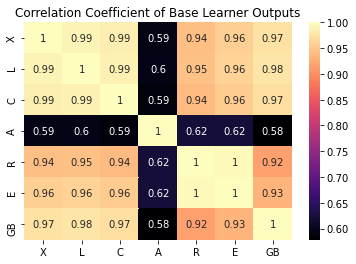

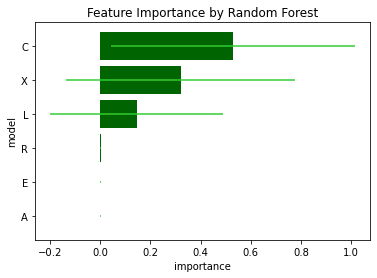

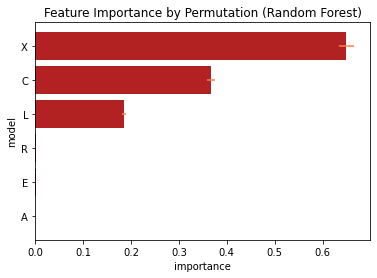

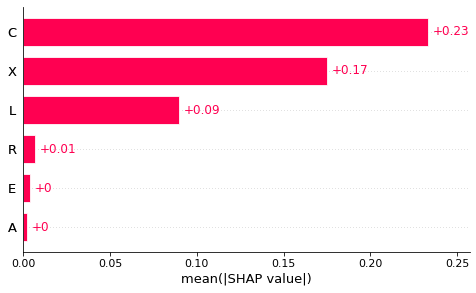

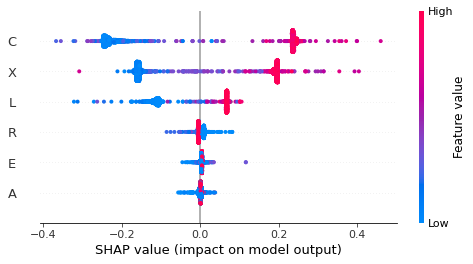

,GLM,forest,permutation,SHAP,total_rank
C,3.0,1.0,2.0,1.0,1.5
X,2.0,2.0,1.0,2.0,1.5
L,1.0,3.0,3.0,3.0,3.0
R,4.0,4.0,4.0,4.0,4.0
E,5.0,5.0,5.0,5.0,5.0
A,6.0,6.0,6.0,6.0,6.0


In [234]:
rank_importance(temp)

  0%|          | 0/10 [00:00<?, ?it/s]


 Dataset 0:
0.3496401743028367
Precision: 0.0 
Recall: 0.0 
Aging Rate: 4.110658938627862e-05

 Dataset 1:
0.3708122005590107
Precision: 0.0015811412965358632 
Recall: 0.21153846153846154 
Aging Rate: 0.14298927118017019

 Dataset 2:
0.622753512192926
Precision: 0.0012576638893255778 
Recall: 0.3076923076923077 
Aging Rate: 0.2614790150861183

 Dataset 3:
-1.1991478166772485
Precision: 0.0011901219875037191 
Recall: 0.5384615384615384 
Aging Rate: 0.48355736424548856

 Dataset 4:
-1.9775733853271693
Precision: 0.0013477997169620594 
Recall: 0.38461538461538464 
Aging Rate: 0.3049903399514942

 Dataset 5:
-1.7571272617888798
Precision: 0.00135308842432853 
Recall: 0.38461538461538464 
Aging Rate: 0.30379824885929213

 Dataset 6:
3.451496663582264
Precision: 0.0012502976899261729 
Recall: 0.40384615384615385 
Aging Rate: 0.34521313766596784

 Dataset 7:
-1.9292182654453391
Precision: 0.0013662135391761731 
Recall: 0.38461538461538464 
Aging Rate: 0.3008796810128664

 Dataset 8:


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

0.5656471332181178
Precision: 0.0014012143858010276 
Recall: 0.28846153846153844 
Aging Rate: 0.2200230196900563

 Dataset 9:
-1.6122565360216932
Precision: 0.0012661309958607256 
Recall: 0.5 
Aging Rate: 0.42206190652361575


C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
C:\Users\user\anaconda3\envs\aging\lib\site-packages\pandas\core\computation\expressions.py:205: UserWarning: evaluating in Python space becau

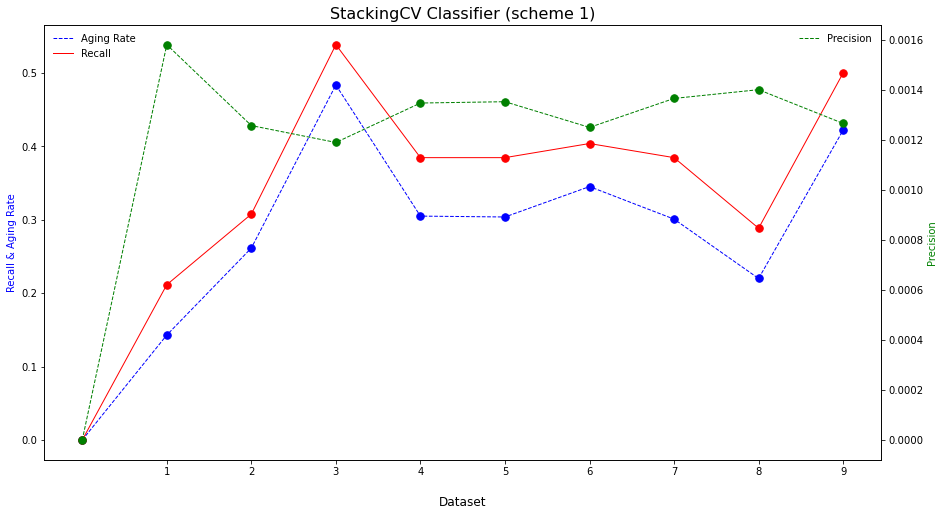

In [9]:
table_setC, coefC = runall_LR(10, train_firstC_x, test_firstC_x, train_firstC_y, test_firstC_y, best_paramC)
line_chart(table_setC, title = 'StackingCV Classifier (scheme 1)')

In [10]:
print(coefC)
table_setC

       set0       set1       set2       set3      set4      set5       set6  \
X  0.349640   0.370812   0.622754  -1.199148 -1.977573 -1.757127   3.451497   
L -6.857907   1.696179  -1.651795  -2.597780 -1.861667 -1.746993  -2.121885   
C -4.395234   1.485231  -0.831850   2.243545 -1.735293 -1.883257  -1.993607   
A  5.008121  -1.740918 -12.720787   9.551696 -0.396684 -0.137791  -4.452847   
R -5.518112   0.646506   9.212797  -7.778546 -2.084409 -2.046647 -10.161817   
E  2.885558 -21.874508 -20.142028 -18.783470 -1.639365 -2.182852  -4.960673   

       set7       set8      set9  
X -1.929218   0.565647 -1.612257  
L -1.882460  -2.389072 -2.410938  
C -1.776752   1.741795  1.905720  
A -0.413268  12.486148  1.656908  
R -1.929679  -1.794598 -7.858686  
E -1.659680 -16.108523 -6.819618  


,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,602.749035,156112.0,259.0,0.0,2.0,52.0,48600.0,0.000000,0.000000,0.000041,0.000000,0.000000
dataset 1,1.000000,2339.0,2339.0,11.0,6946.0,41.0,41656.0,0.001581,0.211538,0.142989,1.479401,0.192081
dataset 2,1.000000,3200.0,3200.0,16.0,12706.0,36.0,35896.0,0.001258,0.307692,0.261479,1.176738,0.239332
dataset 3,1.000000,2595.0,2595.0,28.0,23499.0,24.0,25103.0,0.001190,0.538462,0.483557,1.113542,0.402966
dataset 4,1.000000,2340.0,2340.0,20.0,14819.0,32.0,33783.0,0.001348,0.384615,0.304990,1.261074,0.313785
dataset 5,0.995771,2590.0,2601.0,20.0,14761.0,32.0,33841.0,0.001353,0.384615,0.303798,1.266022,0.314625
dataset 6,0.810135,2590.0,3197.0,21.0,16775.0,31.0,31827.0,0.001250,0.403846,0.345213,1.169846,0.312842
dataset 7,1.000000,2590.0,2590.0,20.0,14619.0,32.0,33983.0,0.001366,0.384615,0.300880,1.278303,0.316704
dataset 8,1.000000,2590.0,2590.0,15.0,10690.0,37.0,37912.0,0.001401,0.288462,0.220023,1.311052,0.241645
dataset 9,10.000000,2590.0,259.0,26.0,20509.0,26.0,28093.0,0.001266,0.500000,0.422062,1.184660,0.390730


### regressor


 Dataset 0:
Best Threshold: -0.0004037302304253597 

Recall: [0.71153846] ,   Precision: [0.00108105] ,   Aging Rate: [0.70345706]

 Dataset 1:
Best Threshold: 0.29863241441534255 

Recall: [0.71153846] ,   Precision: [0.00138132] ,   Aging Rate: [0.55054055]

 Dataset 2:
Best Threshold: 0.2437240478150728 

Recall: [0.71153846] ,   Precision: [0.00127389] ,   Aging Rate: [0.59697044]

 Dataset 3:
Best Threshold: 0.13116978738441404 

Recall: [0.71153846] ,   Precision: [0.00130798] ,   Aging Rate: [0.5814116]

 Dataset 4:
Best Threshold: 0.16309541264996644 

Recall: [0.71153846] ,   Precision: [0.00134209] ,   Aging Rate: [0.56663378]

 Dataset 5:
Best Threshold: 0.10208191308994277 

Recall: [0.71153846] ,   Precision: [0.00121315] ,   Aging Rate: [0.62685493]

 Dataset 6:
Best Threshold: 0.35166482706823804 

Recall: [0.71153846] ,   Precision: [0.00125224] ,   Aging Rate: [0.6072882]

 Dataset 7:
Best Threshold: 0.17651305751754268 

Recall: [0.71153846] ,   Precision: [0.0012387

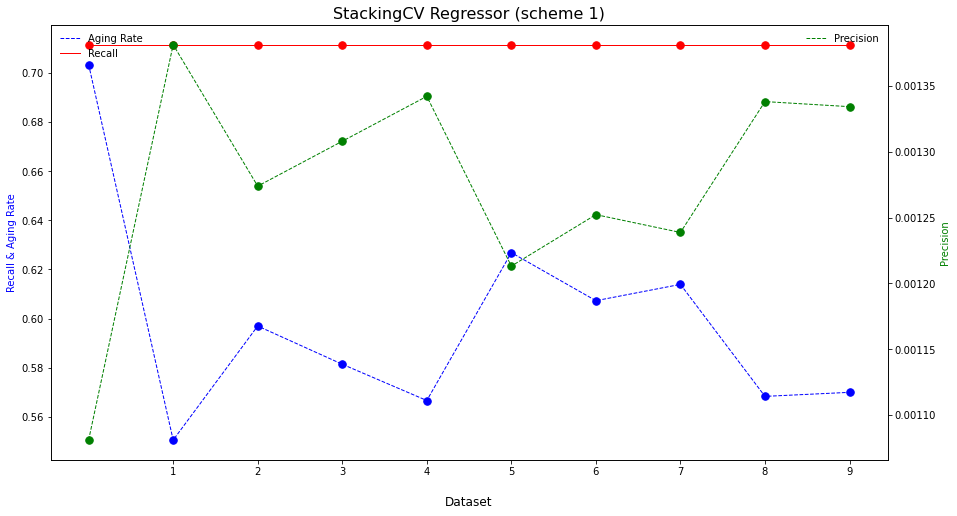

In [16]:
pr_dict, table_setR, coefR = runall_RidgeR(10, train_firstR_x, test_firstR_x, train_firstR_y, test_firstR_y, 
                                           best_paramR, thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'StackingCV Regressor (scheme 1)')

       set0      set1      set2      set3      set4      set5      set6  \
X  0.190537  0.170864  0.119050  0.192132  0.087070  0.305386  0.311519   
L  0.317505  0.138596  0.977677  0.747342  0.551333  0.610693  0.326522   
C  0.181039  0.785115 -0.073913  0.087835  0.282701  0.059302  0.303983   
A -0.035389 -0.046648 -0.048794  0.001981 -0.064909 -0.032214 -0.118546   
R  0.468274 -0.061170  0.036964 -0.050810  0.091530  0.037958  0.201297   
E -0.095275 -0.005918 -0.025322  0.005182  0.000949  0.003669 -0.073714   

       set7      set8      set9  
X  0.254251  0.132834  0.271484  
L  0.628975  0.588554  0.424234  
C  0.224024  0.232005  0.463322  
A  0.002314 -0.003681 -0.060340  
R -0.075917  0.056752 -0.130313  
E -0.048155 -0.010032  0.001616  


,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,-0.000404,156112.0,259.0,602.749035,37.0,34189.0,15.0,14413.0,0.001081,0.711538,0.703457,1.011488,0.497276
dataset 1,0.298632,2339.0,2339.0,1.000000,37.0,26749.0,15.0,21853.0,0.001381,0.711538,0.550541,1.292436,0.590303
dataset 2,0.243724,3200.0,3200.0,1.000000,37.0,29008.0,15.0,19594.0,0.001274,0.711538,0.596970,1.191916,0.558398
dataset 3,0.131170,2595.0,2595.0,1.000000,37.0,28251.0,15.0,20351.0,0.001308,0.711538,0.581412,1.223812,0.568678
dataset 4,0.163095,2340.0,2340.0,1.000000,37.0,27532.0,15.0,21070.0,0.001342,0.711538,0.566634,1.255729,0.578817
dataset 5,0.102082,2590.0,2601.0,0.995771,37.0,30462.0,15.0,18140.0,0.001213,0.711538,0.626855,1.135093,0.539709
dataset 6,0.351665,2590.0,3197.0,0.810135,37.0,29510.0,15.0,19092.0,0.001252,0.711538,0.607288,1.171665,0.551794
dataset 7,0.176513,2590.0,2590.0,1.000000,37.0,29833.0,15.0,18769.0,0.001239,0.711538,0.613927,1.158995,0.547631
dataset 8,0.127957,2590.0,2590.0,1.000000,37.0,27614.0,15.0,20988.0,0.001338,0.711538,0.568319,1.252005,0.577642
dataset 9,0.202535,2590.0,259.0,10.000000,37.0,27694.0,15.0,20908.0,0.001334,0.711538,0.569963,1.248393,0.576500


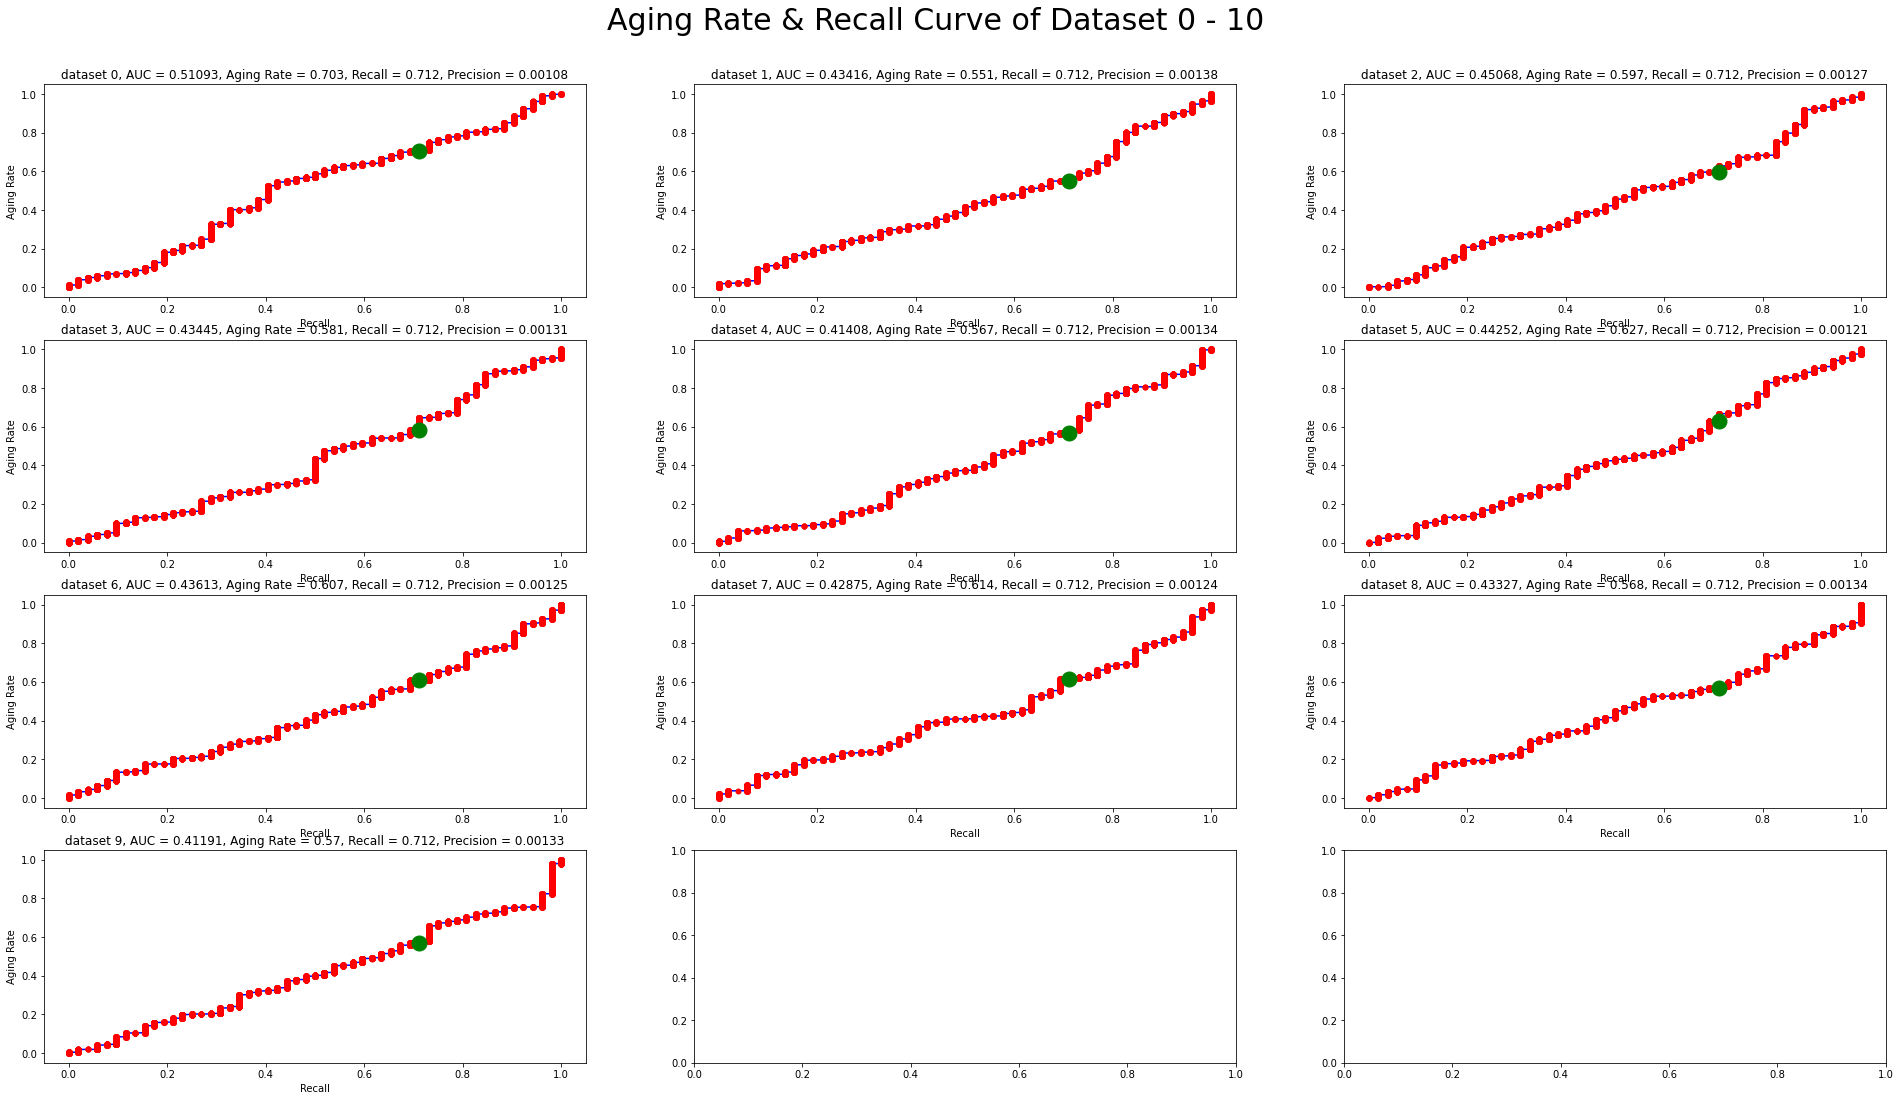

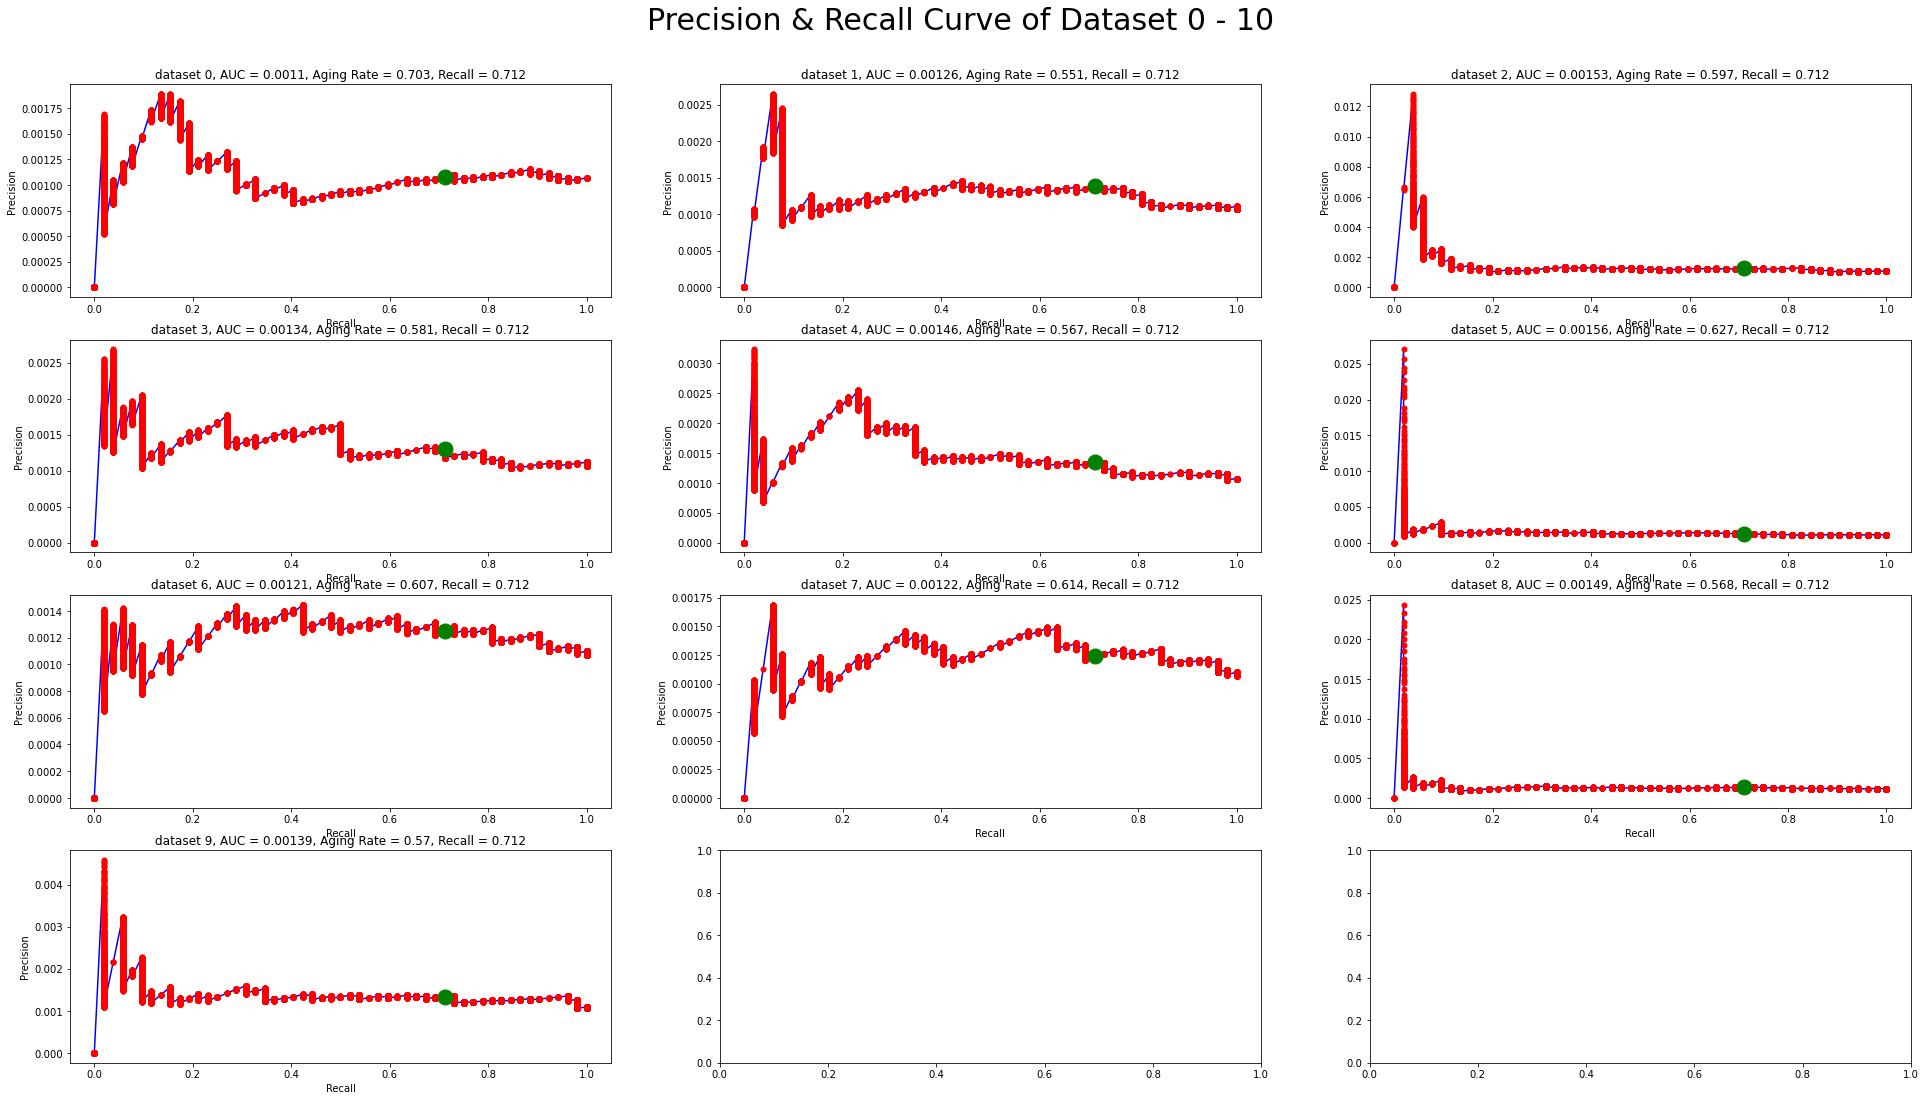

In [18]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
print(coefR)
table_setR

### export

In [13]:
savedate = '20211019'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setR['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'StackingCV 1'
table_setR['model'] = 'StackingCV 1'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'StackingCV_1')
with pd.ExcelWriter(f'{savedate}_Regressor.xlsx', mode = 'a') as writer:
    table_setR.to_excel(writer, sheet_name = 'StackingCV_1')